# DR Suite Diagnostics (PCA, NMF, FA, FactoSig)

This notebook loads array-only DR outputs saved by `scripts/run_dr_suite.py` and performs:

- Variance explained and factor score variance diagnostics
- Gene communality distributions and summaries
- GSEA per factor (Hallmark by default), results saved under the experiment directory
- Counts of significant pathways per factor and comparison across methods
- Cross-method factor alignment via loading correlations

Set `EXP_DIR` below to the experiment you want to analyze.


In [1]:
from pathlib import Path
import os
import json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Optional: for UMAP visualizations (scores only)
try:
    import umap
except Exception:
    umap = None

# Configuration
# Set to your latest experiment directory (printed by the run script)
EXP_DIR = Path("/home/minhang/mds_project/sc_classification/scripts/experiments/20251109_205901_dr_suite_100_none__94e6712c")
K = 100
METHODS = ["pca", "fa", "nmf", "factosig"]
# Hallmark gene sets (update if needed)
HALLMARK_GMT = Path("/home/minhang/mds_project/data/cohort_adata/gene_sets/h.all.v2024.1.Hs.symbols.gmt")
# GSEA settings
GSEA_THREADS = 4
GSEA_PERM = 1000
GSEA_MIN_SIZE = 10
GSEA_MAX_SIZE = 5000
N_FACTORS_GSEA = K  # set lower to speed up testing

ANALYSIS_DIR = EXP_DIR / "analysis"
FACTOR_INTP_DIR = ANALYSIS_DIR / "factor_interpretation"
SUMMARY_PLOTS_DIR = ANALYSIS_DIR / "summary_plots"
FACTOR_INTP_DIR.mkdir(parents=True, exist_ok=True)
SUMMARY_PLOTS_DIR.mkdir(parents=True, exist_ok=True)

print(f"Experiment: {EXP_DIR}")


Experiment: /home/minhang/mds_project/sc_classification/scripts/experiments/20251109_205901_dr_suite_100_none__94e6712c


In [2]:
def load_method(exp_dir: Path, method: str, k: int):
    mdir = exp_dir / "models" / f"{method}_{k}"
    data = {
        "method": method,
        "dir": mdir,
        "scores": None,
        "loadings": None,
        "obs_names": None,
        "var_names": None,
        "extras": {},
        "metrics": {},
    }
    # Arrays
    data["scores"] = np.load(mdir / "scores.npy")
    data["loadings"] = np.load(mdir / "loadings.npy")
    # Names
    with open(mdir / "obs_names.txt", "r") as f:
        data["obs_names"] = [ln.strip() for ln in f]
    with open(mdir / "var_names.txt", "r") as f:
        data["var_names"] = [ln.strip() for ln in f]
    # Extras
    for fname, key in [
        ("psi.npy", "psi"),
        ("explained_variance.npy", "explained_variance"),
        ("explained_variance_ratio.npy", "explained_variance_ratio"),
        ("singular_values.npy", "singular_values"),
    ]:
        p = mdir / fname
        if p.exists():
            data["extras"][key] = np.load(p)
    # Reconstruction error
    rec_json = mdir / "reconstruction_error.json"
    if rec_json.exists():
        try:
            data["extras"]["reconstruction_error"] = json.loads(rec_json.read_text()).get("reconstruction_error")
        except Exception:
            pass
    # Metrics
    met_json = mdir / "dr_metrics.json"
    if met_json.exists():
        try:
            data["metrics"] = json.loads(met_json.read_text())
        except Exception:
            pass
    return data

DR = {m: load_method(EXP_DIR, m, K) for m in METHODS}
for m, d in DR.items():
    print(m, d["scores"].shape, d["loadings"].shape)


pca (49480, 100) (15679, 100)
fa (49480, 100) (15679, 100)
nmf (49480, 100) (15679, 100)
factosig (49480, 100) (15679, 100)


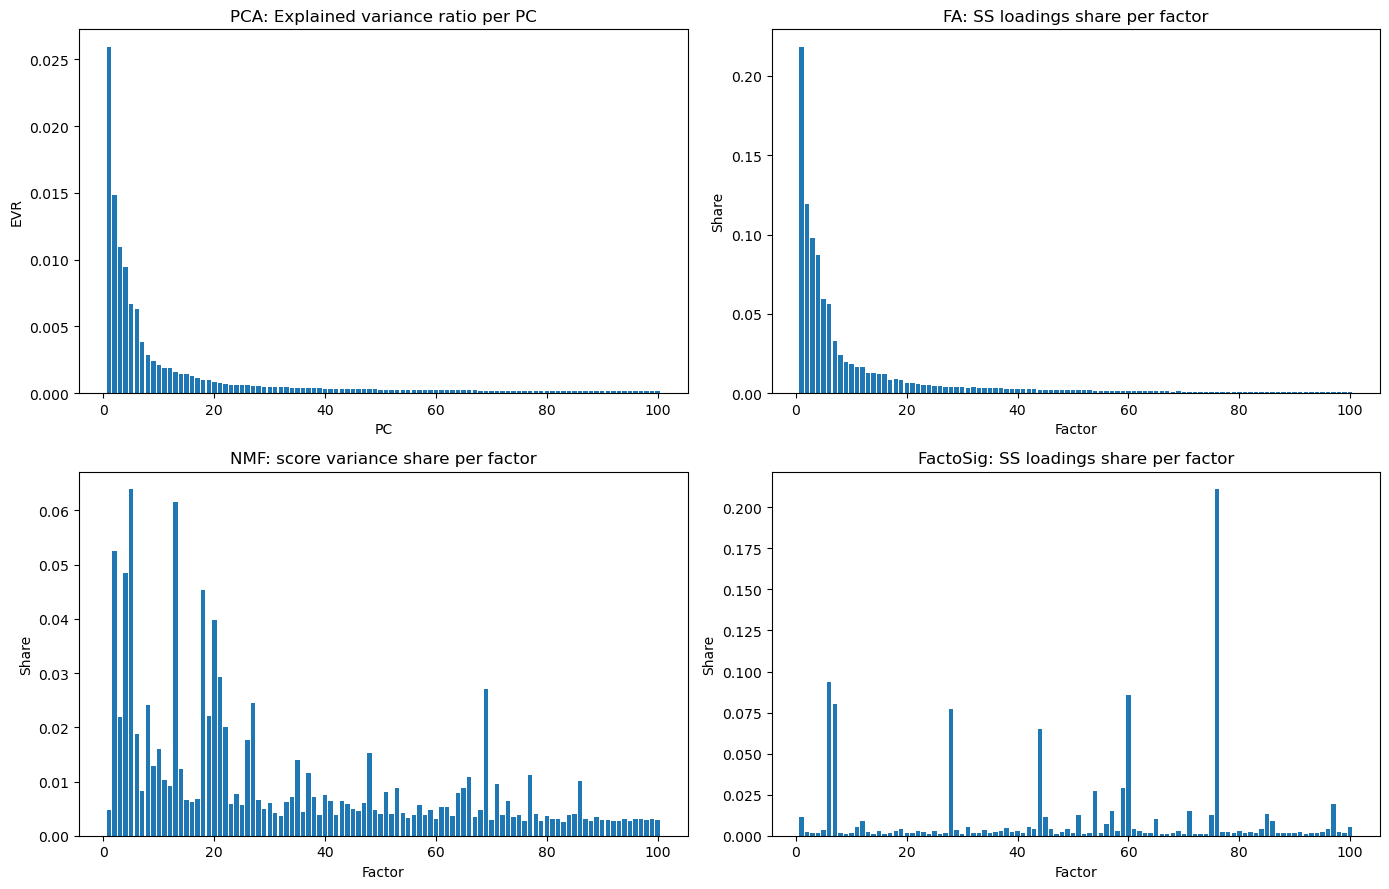

pca {
  "total_ss": 99.99999999999997,
  "top10_ss_share": 0.10000000000000052
}
fa {
  "total_ss": 1804.0236409054971,
  "top10_ss_share": 0.7331098434166028
}
nmf {
  "total_ss": 403188.01902351377,
  "top10_ss_share": 0.4216272233295991
}
nmf reconstruction_error: 11576.301668693799
factosig {
  "total_ss": 1977.4439697265625,
  "top10_ss_share": 0.7048899814515796
}


In [ ]:
# Variance explained / factor score variance diagnostics
fig, axes = plt.subplots(2, 2, figsize=(14, 9))
axes = axes.ravel()

# PCA: explained variance ratio per component
pca = DR.get("pca")
if pca and "explained_variance_ratio" in pca["extras"]:
    evr = pca["extras"]["explained_variance_ratio"]
    axes[0].bar(np.arange(1, len(evr)+1), evr)
    axes[0].set_title("PCA: Explained variance ratio per PC")
    axes[0].set_xlabel("PC")
    axes[0].set_ylabel("EVR") # means explained variance ratio
else:
    axes[0].text(0.5, 0.5, "No EVR available", ha='center')
    axes[0].set_title("PCA")

# FA: share via SS loadings per factor
fa = DR.get("fa")
if fa is not None:
    L = fa["loadings"]
    ss = (L**2).sum(axis=0)
    share = ss / ss.sum()
    axes[1].bar(np.arange(1, len(share)+1), share)
    axes[1].set_title("FA: SS loadings share per factor")
    axes[1].set_xlabel("Factor")
    axes[1].set_ylabel("Share")

# NMF: factor score variances as proxy
nmf = DR.get("nmf")
if nmf is not None:
    Z = nmf["scores"]
    var_scores = np.var(Z, axis=0)
    share = var_scores / var_scores.sum()
    axes[2].bar(np.arange(1, len(share)+1), share)
    axes[2].set_title("NMF: score variance share per factor")
    axes[2].set_xlabel("Factor")
    axes[2].set_ylabel("Share")

# FactoSig: share via SS loadings per factor
fs = DR.get("factosig")
if fs is not None:
    L = fs["loadings"]
    ss = (L**2).sum(axis=0)
    share = ss / ss.sum()
    axes[3].bar(np.arange(1, len(share)+1), share)
    axes[3].set_title("FactoSig: SS loadings share per factor")
    axes[3].set_xlabel("Factor")
    axes[3].set_ylabel("Share")

plt.tight_layout()
plt.show()

# Print overall metrics if present
for m in METHODS:
    met = DR[m]["metrics"] if m in DR else {}
    if met:
        print(m, json.dumps(met, indent=2))
    # NMF reconstruction error
    if m == "nmf" and "reconstruction_error" in DR[m]["extras"]:
        print("nmf reconstruction_error:", DR[m]["extras"]["reconstruction_error"])


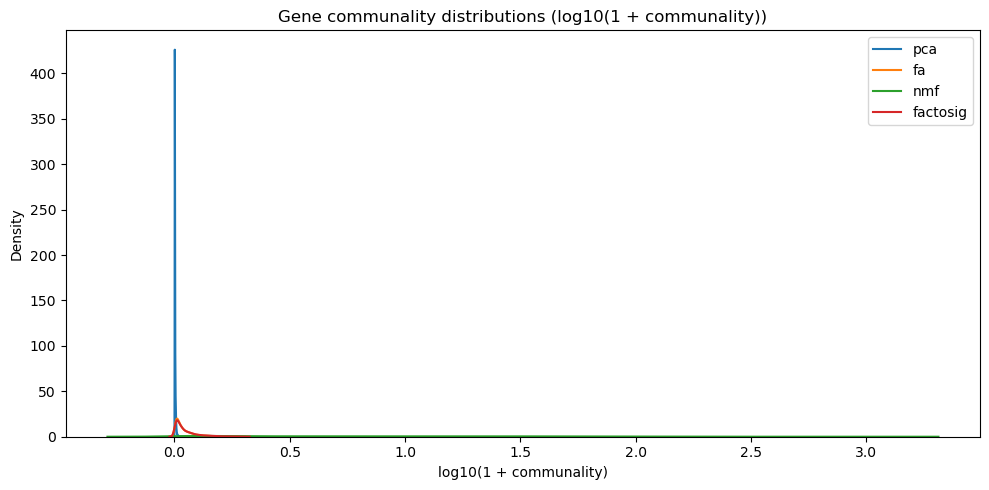

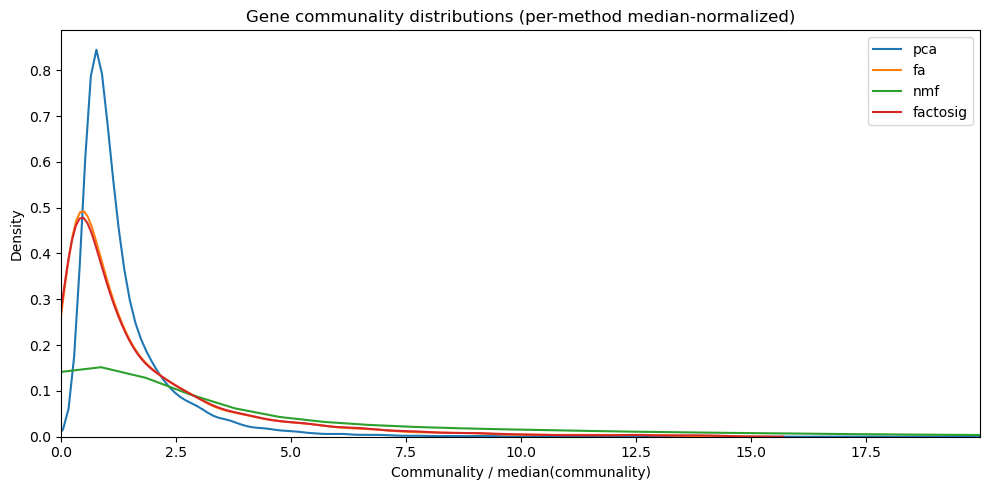

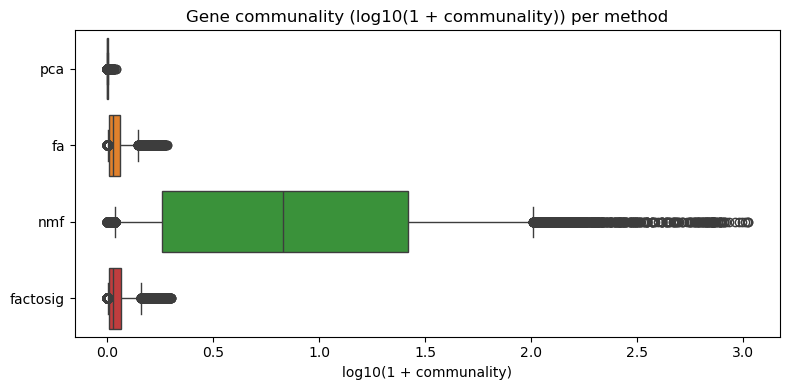

In [7]:
# Improved communality visualization: log-scale and per-method normalization
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Compute per-gene communality for each method
comm = {}
for m in METHODS:
    L = DR[m]["loadings"]
    comm[m] = (L**2).sum(axis=1)

comm_raw_df = pd.DataFrame({m: comm[m] for m in METHODS}, index=DR[METHODS[0]]["var_names"])  # genes × methods

# 1) Log10(1 + communality) KDE (robust across scales)
comm_log = {m: np.log10(1.0 + comm[m]) for m in METHODS}
fig, ax = plt.subplots(figsize=(10, 5))
for m in METHODS:
    sns.kdeplot(comm_log[m], ax=ax, label=m, fill=False)
ax.set_title("Gene communality distributions (log10(1 + communality))")
ax.set_xlabel("log10(1 + communality)")
ax.legend()
plt.tight_layout(); plt.show()

# 2) Per-method normalized communality (divide by median) to compare shapes
comm_norm = {m: comm[m] / (np.median(comm[m]) + 1e-12) for m in METHODS}
fig, ax = plt.subplots(figsize=(10, 5))
for m in METHODS:
    sns.kdeplot(comm_norm[m], ax=ax, label=m, fill=False)
ax.set_xlim(0, np.quantile(np.concatenate([comm_norm[m] for m in METHODS]), 0.99))
ax.set_title("Gene communality distributions (per-method median-normalized)")
ax.set_xlabel("Communality / median(communality)")
ax.legend()
plt.tight_layout(); plt.show()

# 3) Boxplots on log-scale (per method)
comm_log_df = pd.DataFrame({m: np.log10(1.0 + comm[m]) for m in METHODS})
plt.figure(figsize=(8, 4))
sns.boxplot(data=comm_log_df, orient='h', whis=[5, 95])
plt.title("Gene communality (log10(1 + communality)) per method")
plt.xlabel("log10(1 + communality)")
plt.tight_layout(); plt.show()


Running/reading GSEA for pca ...
Running/reading GSEA for fa ...


2025-11-10 05:44:13,518 [WARNING] Duplicated values found in preranked stats: 10.03% of genes
The order of those genes will be arbitrary, which may produce unexpected results.


Running/reading GSEA for nmf ...


2025-11-10 05:44:15,568 [WARNING] Duplicated values found in preranked stats: 12.74% of genes
The order of those genes will be arbitrary, which may produce unexpected results.
2025-11-10 05:44:17,632 [WARNING] Duplicated values found in preranked stats: 13.84% of genes
The order of those genes will be arbitrary, which may produce unexpected results.
2025-11-10 05:44:19,680 [WARNING] Duplicated values found in preranked stats: 13.86% of genes
The order of those genes will be arbitrary, which may produce unexpected results.
2025-11-10 05:44:21,712 [WARNING] Duplicated values found in preranked stats: 15.74% of genes
The order of those genes will be arbitrary, which may produce unexpected results.
2025-11-10 05:44:23,763 [WARNING] Duplicated values found in preranked stats: 10.22% of genes
The order of those genes will be arbitrary, which may produce unexpected results.
2025-11-10 05:44:25,818 [WARNING] Duplicated values found in preranked stats: 9.22% of genes
The order of those genes wi

Running/reading GSEA for factosig ...


2025-11-10 05:47:45,602 [WARNING] Duplicated values found in preranked stats: 0.01% of genes
The order of those genes will be arbitrary, which may produce unexpected results.
2025-11-10 05:47:49,707 [WARNING] Duplicated values found in preranked stats: 0.01% of genes
The order of those genes will be arbitrary, which may produce unexpected results.
2025-11-10 05:47:51,778 [WARNING] Duplicated values found in preranked stats: 0.01% of genes
The order of those genes will be arbitrary, which may produce unexpected results.
2025-11-10 05:47:53,835 [WARNING] Duplicated values found in preranked stats: 0.01% of genes
The order of those genes will be arbitrary, which may produce unexpected results.
2025-11-10 05:47:59,970 [WARNING] Duplicated values found in preranked stats: 0.01% of genes
The order of those genes will be arbitrary, which may produce unexpected results.
2025-11-10 05:48:02,030 [WARNING] Duplicated values found in preranked stats: 0.01% of genes
The order of those genes will be

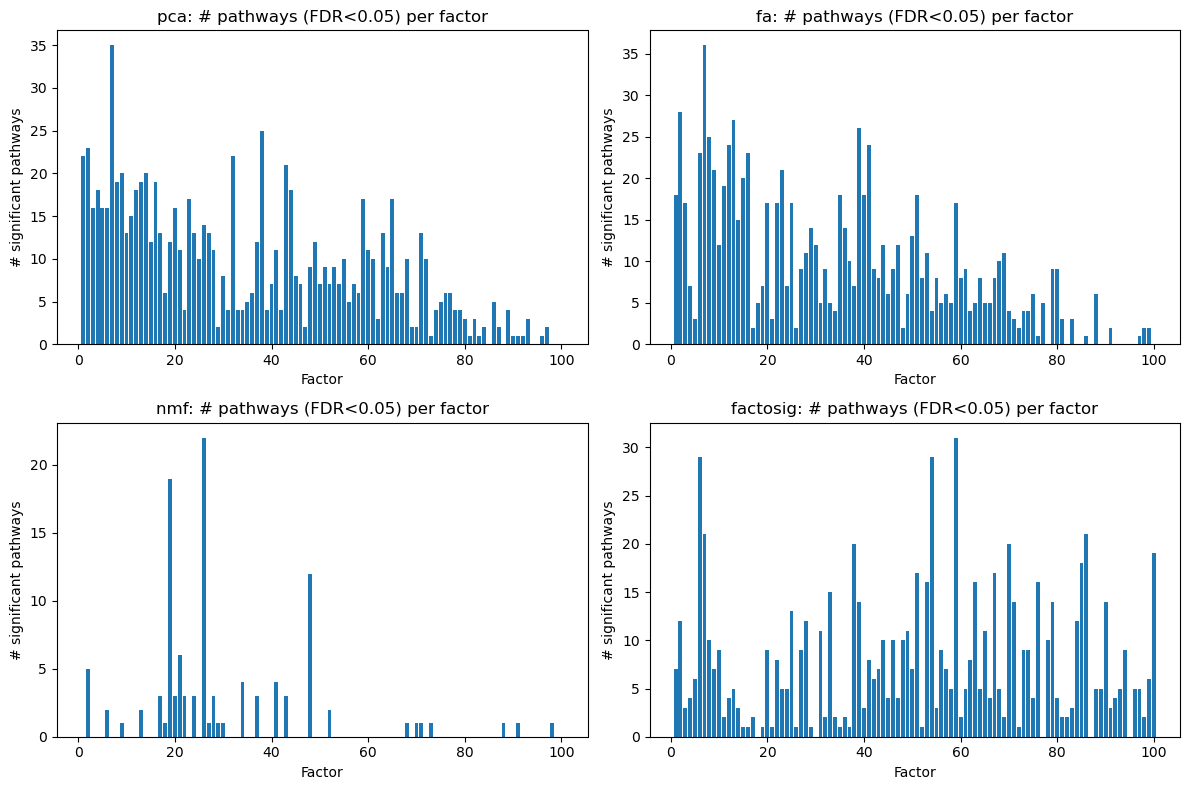

In [5]:
# GSEA per factor using Hallmark (preranked by loadings)
from typing import Optional

try:
    import gseapy as gp
except Exception as e:
    print("Install gseapy to run GSEA: pip install gseapy")
    gp = None


def run_or_read_prerank(series: pd.Series, gene_sets: str, out_dir: Path) -> Optional[pd.DataFrame]:
    out_dir.mkdir(parents=True, exist_ok=True)
    report_csv = out_dir / "gseapy.gene_set.prerank.report.csv"
    if report_csv.exists():
        try:
            df = pd.read_csv(report_csv, sep="\t")
        except Exception:
            df = pd.read_csv(report_csv)
        return df
    if gp is None:
        return None
    df_rnk = series.reset_index()
    df_rnk.columns = ["gene", "score"]
    res = gp.prerank(
        rnk=df_rnk,
        gene_sets=str(gene_sets),
        threads=GSEA_THREADS,
        permutation_num=GSEA_PERM,
        outdir=str(out_dir),
        seed=0,
        min_size=GSEA_MIN_SIZE,
        max_size=GSEA_MAX_SIZE,
        no_plot=True,
        format="png",
    )
    return res.res2d.copy()

# Build rankings and run GSEA for each method/factor
GSEA_COUNTS = {}
for m in METHODS:
    print(f"Running/reading GSEA for {m} ...")
    L = DR[m]["loadings"]
    genes = np.array(DR[m]["var_names"])  # shape (p,)
    out_root = FACTOR_INTP_DIR / f"{m}_gsea"
    out_root.mkdir(parents=True, exist_ok=True)
    n_factors = min(L.shape[1], N_FACTORS_GSEA)
    counts = []
    for j in range(n_factors):
        rank = pd.Series(L[:, j], index=genes).sort_values(ascending=False)
        out_dir = out_root / f"{m}{j+1}"
        df = run_or_read_prerank(rank, HALLMARK_GMT, out_dir)
        if df is None:
            continue
        # tolerate column naming differences
        qcols = [c for c in ["FDR q-val", "fdr", "fdr_q-val", "fdr_q_value"] if c in df.columns]
        if qcols:
            qcol = qcols[0]
            n_sig = int((df[qcol] < 0.05).sum())
        else:
            n_sig = np.nan
        counts.append({"factor": j, "n_sig": n_sig})
    GSEA_COUNTS[m] = pd.DataFrame(counts)

# Plot counts per method
fig, axes = plt.subplots(2, 2, figsize=(12, 8))
axes = axes.ravel()
for ax, m in zip(axes, METHODS):
    dfc = GSEA_COUNTS.get(m, pd.DataFrame())
    if dfc.empty:
        ax.text(0.5, 0.5, f"No GSEA results for {m}", ha='center')
        ax.set_title(m)
        continue
    ax.bar(dfc["factor"].values + 1, dfc["n_sig"].values)
    ax.set_title(f"{m}: # pathways (FDR<0.05) per factor")
    ax.set_xlabel("Factor")
    ax.set_ylabel("# significant pathways")
plt.tight_layout(); plt.show()


In [8]:
# GSEA: create summary barplots per factor using ExperimentAnalyzer helper
from sc_classification.utils.experiment_analysis import ExperimentAnalyzer

experiments_base_dir = EXP_DIR.parent
analyzer = ExperimentAnalyzer(str(experiments_base_dir))

for m in METHODS:
    print(f"Creating GSEA summary plots for {m} ...")
    out_root = FACTOR_INTP_DIR / f"{m}_gsea"
    n_factors = DR[m]["loadings"].shape[1]
    for j in range(n_factors):
        factor_name = f"{m.upper()} Factor {j+1}"
        gsea_dir = out_root / f"{m}{j+1}"
        csv_path = gsea_dir / "gseapy.gene_set.prerank.report.csv"
        plot_path = gsea_dir / f"GSEA_summary_barplot_{m}{j+1}.png"
        if not csv_path.exists():
            continue
        analyzer._plot_gsea_results(
            csv_path=str(csv_path),
            factor_name=factor_name,
            gene_set=str(HALLMARK_GMT),
            output_path=str(plot_path),
        )
print("Done.")

Creating GSEA summary plots for pca ...


/home/minhang/mds_project/sc_classification/src/sc_classification/utils/experiment_analysis.py:2027: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x='NES', y='Term', data=combined, palette=colors, orient='h')
/home/minhang/mds_project/sc_classification/src/sc_classification/utils/experiment_analysis.py:2027: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x='NES', y='Term', data=combined, palette=colors, orient='h')
/home/minhang/mds_project/sc_classification/src/sc_classification/utils/experiment_analysis.py:2027: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the 

Creating GSEA summary plots for fa ...


/home/minhang/mds_project/sc_classification/src/sc_classification/utils/experiment_analysis.py:2027: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x='NES', y='Term', data=combined, palette=colors, orient='h')
/home/minhang/mds_project/sc_classification/src/sc_classification/utils/experiment_analysis.py:2027: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x='NES', y='Term', data=combined, palette=colors, orient='h')
/home/minhang/mds_project/sc_classification/src/sc_classification/utils/experiment_analysis.py:2027: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the 

Creating GSEA summary plots for nmf ...


/home/minhang/mds_project/sc_classification/src/sc_classification/utils/experiment_analysis.py:2027: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x='NES', y='Term', data=combined, palette=colors, orient='h')
/home/minhang/mds_project/sc_classification/src/sc_classification/utils/experiment_analysis.py:2027: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x='NES', y='Term', data=combined, palette=colors, orient='h')
/home/minhang/mds_project/sc_classification/src/sc_classification/utils/experiment_analysis.py:2027: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the 

Creating GSEA summary plots for factosig ...


/home/minhang/mds_project/sc_classification/src/sc_classification/utils/experiment_analysis.py:2027: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x='NES', y='Term', data=combined, palette=colors, orient='h')
/home/minhang/mds_project/sc_classification/src/sc_classification/utils/experiment_analysis.py:2027: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x='NES', y='Term', data=combined, palette=colors, orient='h')
/home/minhang/mds_project/sc_classification/src/sc_classification/utils/experiment_analysis.py:2027: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the 

Done.


### Cross-DR-Methods factor alignments

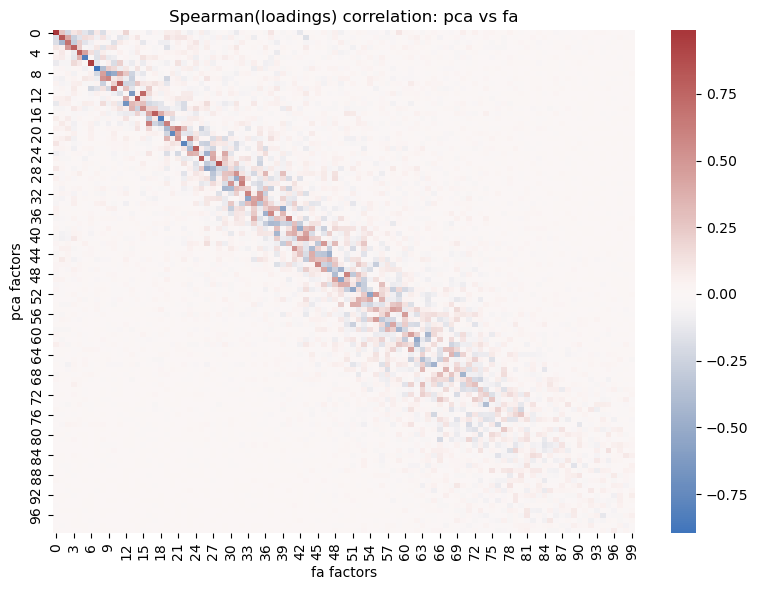

pca→fa best median rho: 0.372, mean: 0.387
fa→pca best median rho: 0.378, mean: 0.393


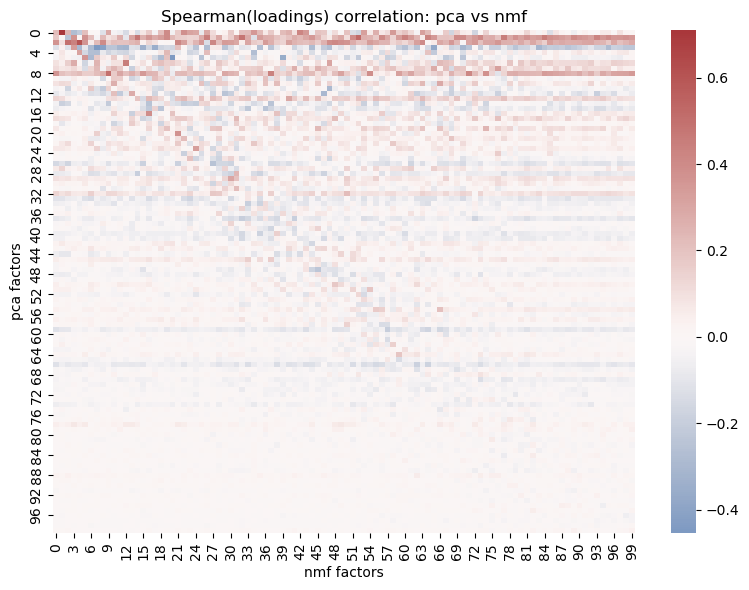

pca→nmf best median rho: 0.102, mean: 0.146
nmf→pca best median rho: 0.352, mean: 0.364


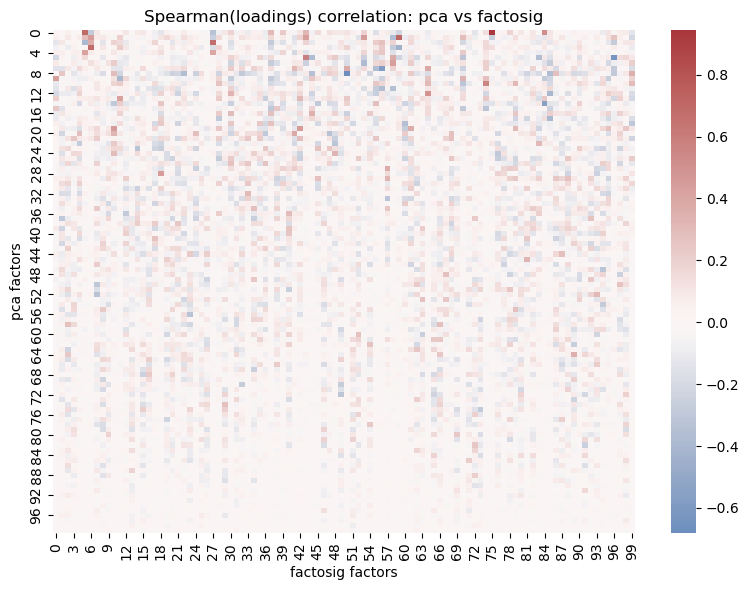

pca→factosig best median rho: 0.242, mean: 0.269
factosig→pca best median rho: 0.264, mean: 0.303


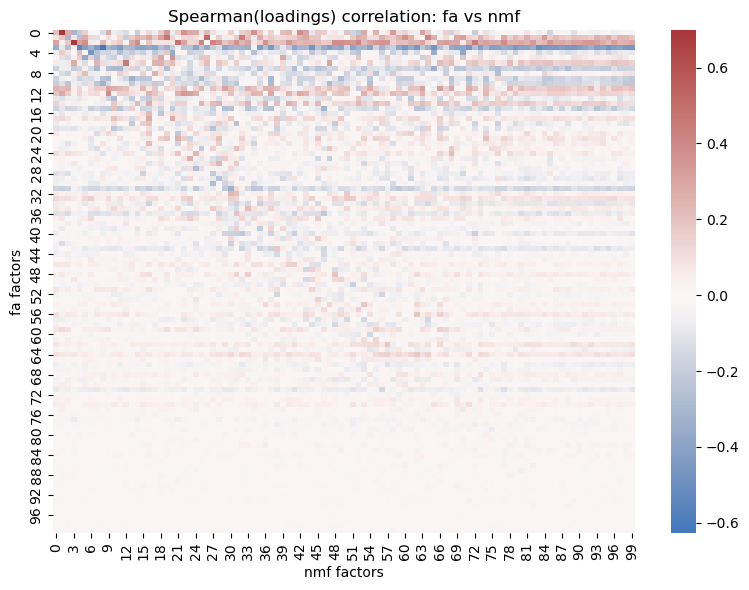

fa→nmf best median rho: 0.108, mean: 0.136
nmf→fa best median rho: 0.307, mean: 0.323


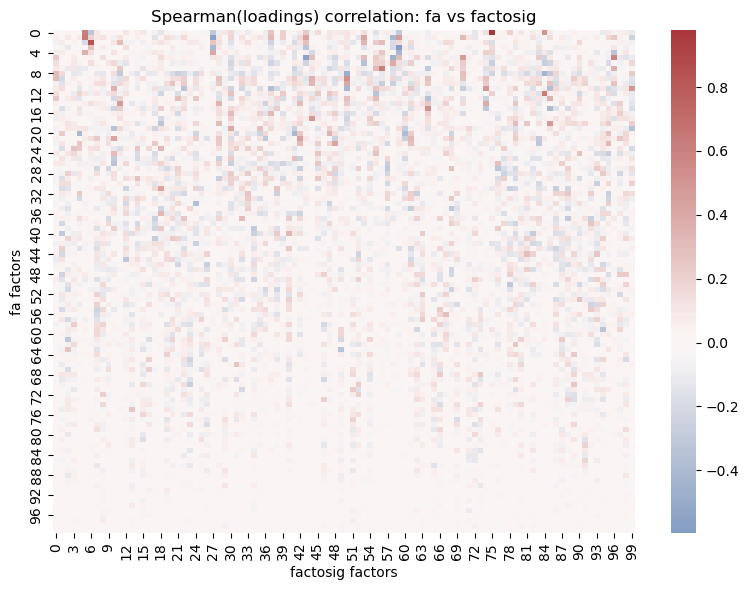

fa→factosig best median rho: 0.236, mean: 0.268
factosig→fa best median rho: 0.255, mean: 0.307


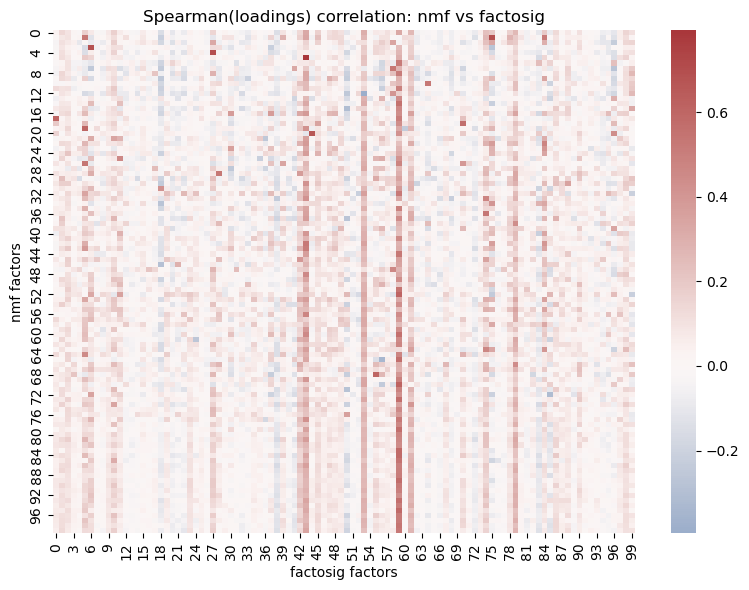

nmf→factosig best median rho: 0.478, mean: 0.483
factosig→nmf best median rho: 0.226, mean: 0.278


In [5]:
# Cross-method factor alignment (loading correlations)
from itertools import combinations

PAIR_RESULTS = {}

for a, b in combinations(METHODS, 2):
    La = DR[a]["loadings"]  # (p, ka)
    Lb = DR[b]["loadings"]  # (p, kb)
    # correlate factors by gene loadings; use Spearman or Pearson
    # we use Spearman for robustness
    import scipy.stats as stats
    ka, kb = La.shape[1], Lb.shape[1]
    corr = np.zeros((ka, kb))
    for i in range(ka):
        for j in range(kb):
            rho, _ = stats.spearmanr(La[:, i], Lb[:, j])
            corr[i, j] = rho
    PAIR_RESULTS[(a, b)] = corr
    # Plot heatmap
    plt.figure(figsize=(8, 6))
    sns.heatmap(corr, cmap='vlag', center=0)
    plt.title(f"Spearman(loadings) correlation: {a} vs {b}")
    plt.xlabel(f"{b} factors")
    plt.ylabel(f"{a} factors")
    plt.tight_layout()
    plot_path = SUMMARY_PLOTS_DIR / f"corr_{a}_vs_{b}.png"
    plt.savefig(plot_path, dpi=150)
    plt.show()
    # Report best match per factor
    best_a = corr.max(axis=1)
    best_b = corr.max(axis=0)
    print(f"{a}→{b} best median rho: {np.median(best_a):.3f}, mean: {np.mean(best_a):.3f}")
    print(f"{b}→{a} best median rho: {np.median(best_b):.3f}, mean: {np.mean(best_b):.3f}")


### Integrate back to adata and plot UMAP

In [2]:
# Attach DR arrays back to AnnData for UMAP and downstream plots
import scanpy as sc
from sc_classification.utils.experiment_manager import ExperimentManager

# Load adata from the path saved in config.yaml
cfg = json.loads((EXP_DIR / "config.yaml").read_text()) if False else None  # placeholder
# Robust load via YAML
import yaml
with open(EXP_DIR / "config.yaml", "r") as f:
    cfg = yaml.safe_load(f)
input_h5ad = cfg.get('preprocessing', {}).get('used_input_h5ad')
print("Input h5ad:", input_h5ad)

adata0 = sc.read_h5ad(input_h5ad)
# Recreate cohort filter consistent with run (MRD + patients with malignant)
# (same filtering logic as driver script)
if 'timepoint_type' in adata0.obs.columns:
    adata0 = adata0[adata0.obs['timepoint_type'] == 'MRD'].copy()
else:
    for c in ['sample', 'Sample', 'SAMPLE']:
        if c in adata0.obs.columns:
            mask = adata0.obs[c].astype(str).str.contains('MRD', case=False, na=False)
            adata0 = adata0[mask].copy()
            break
label_col = next(c for c in ['CN.label','cnLabel','cn_label','cnlabel'] if c in adata0.obs.columns)
adata0 = adata0[adata0.obs[label_col].isin(['cancer','normal'])].copy()
if 'patient' in adata0.obs.columns:
    has_mal = adata0.obs[adata0.obs[label_col] == 'cancer']['patient'].unique()
    adata0 = adata0[adata0.obs['patient'].isin(has_mal)].copy()
print("Cohort after filtering:", adata0.shape)

# Attach using Experiment.attach_dr_to_adata (name-based alignment)
em = ExperimentManager(str(EXP_DIR.parent))
exp_id = EXP_DIR.name
exp = em.load_experiment(exp_id)

method_keys = {
    'pca': ('X_pca', 'PCA_loadings', None),
    'fa': ('X_fa', 'FA_loadings', 'fa_psi'),
    'nmf': ('X_nmf', 'NMF_components', None),
    'factosig': ('X_factosig', 'FACTOSIG_loadings', 'FACTOSIG_psi')
}

adata = adata0.copy()
for m, (obsm_key, varm_key, var_psi_key) in method_keys.items():
    try:
        adata = exp.attach_dr_to_adata(
            adata,
            dr_method=m,
            n_components=K,
            obsm_key=obsm_key,
            varm_key=varm_key,
            var_psi_key=var_psi_key,
            strict_name_match=False,
        )
        print(f"Attached {m} to adata: {obsm_key}, {varm_key}")
    except Exception as e:
        print(f"Attach failed for {m}: {e}")

AD = adata  # keep a handle

Input h5ad: /home/minhang/mds_project/data/cohort_adata/adata_mrd_standardized_oct7.h5ad
Cohort after filtering: (49480, 15679)
Loading experiment from: /home/minhang/mds_project/sc_classification/scripts/experiments/20251109_205901_dr_suite_100_none__94e6712c
Attached pca to adata: X_pca, PCA_loadings
Attached fa to adata: X_fa, FA_loadings
Attached nmf to adata: X_nmf, NMF_components
Attached factosig to adata: X_factosig, FACTOSIG_loadings


In [4]:
AD.write_h5ad(EXP_DIR / "post_dr_integration_mrd.h5ad", compression="gzip")

Attributes available: ['CN.label', 'patient', 'predicted.annotation']


/home/minhang/miniconda3/envs/sc-factosig-gpu/lib/python3.10/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


Computed UMAP for pca: (49480, 2)


/tmp/ipykernel_3066695/4198137662.py:27: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(AD.obs[a]) or AD.obs[a].dtype == object:


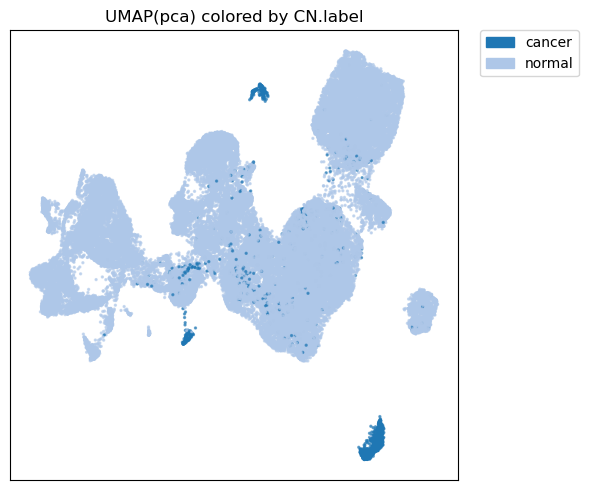

/tmp/ipykernel_3066695/4198137662.py:27: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(AD.obs[a]) or AD.obs[a].dtype == object:


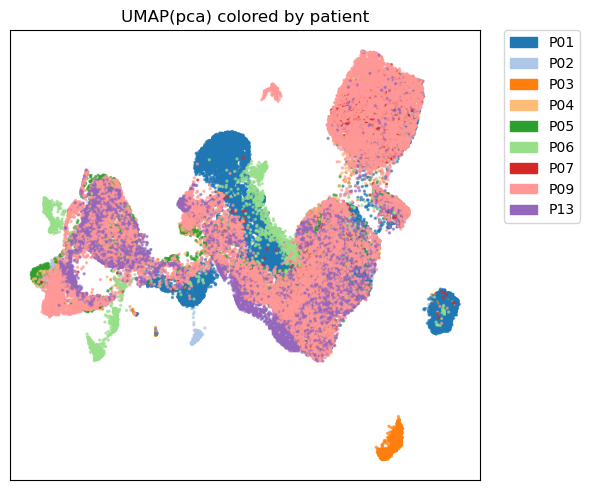

/tmp/ipykernel_3066695/4198137662.py:27: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(AD.obs[a]) or AD.obs[a].dtype == object:


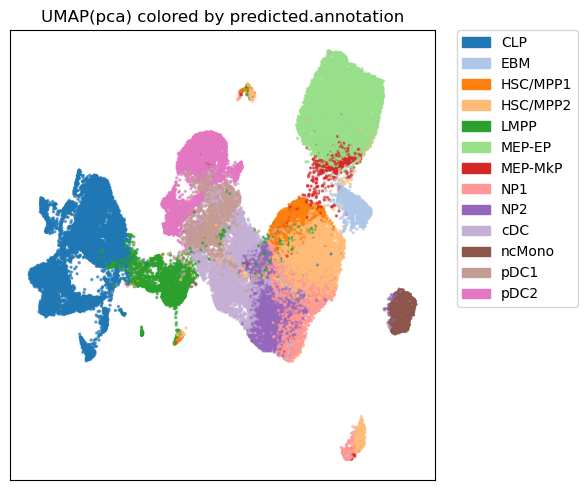

/home/minhang/miniconda3/envs/sc-factosig-gpu/lib/python3.10/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


Computed UMAP for fa: (49480, 2)


/tmp/ipykernel_3066695/4198137662.py:27: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(AD.obs[a]) or AD.obs[a].dtype == object:


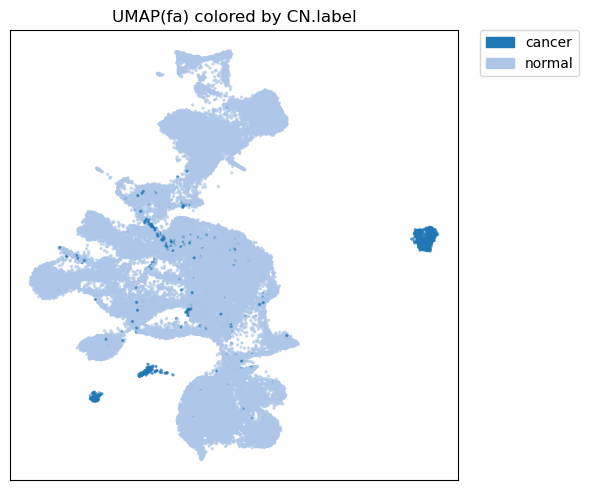

/tmp/ipykernel_3066695/4198137662.py:27: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(AD.obs[a]) or AD.obs[a].dtype == object:


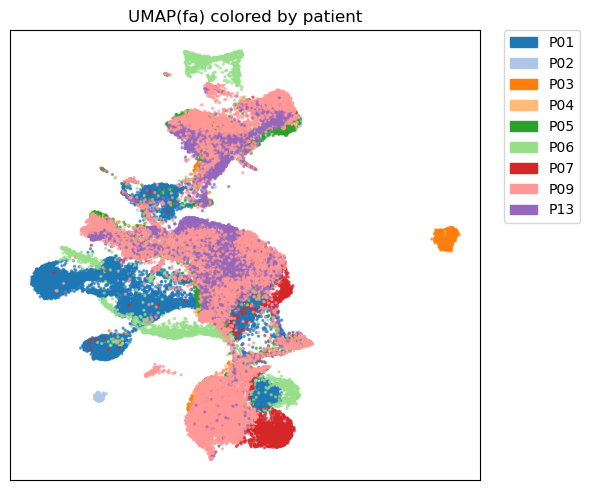

/tmp/ipykernel_3066695/4198137662.py:27: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(AD.obs[a]) or AD.obs[a].dtype == object:


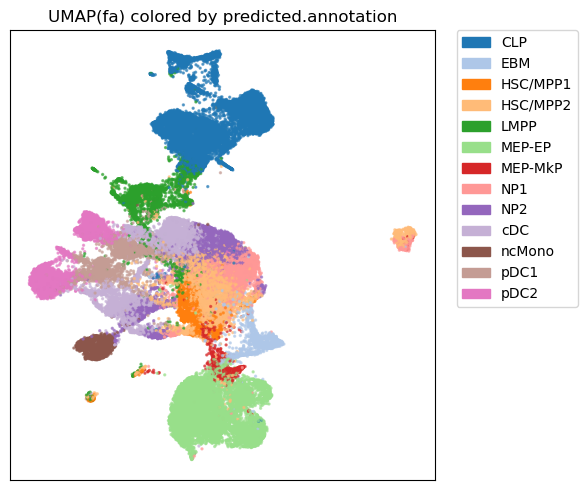

/home/minhang/miniconda3/envs/sc-factosig-gpu/lib/python3.10/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


Computed UMAP for nmf: (49480, 2)


/tmp/ipykernel_3066695/4198137662.py:27: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(AD.obs[a]) or AD.obs[a].dtype == object:


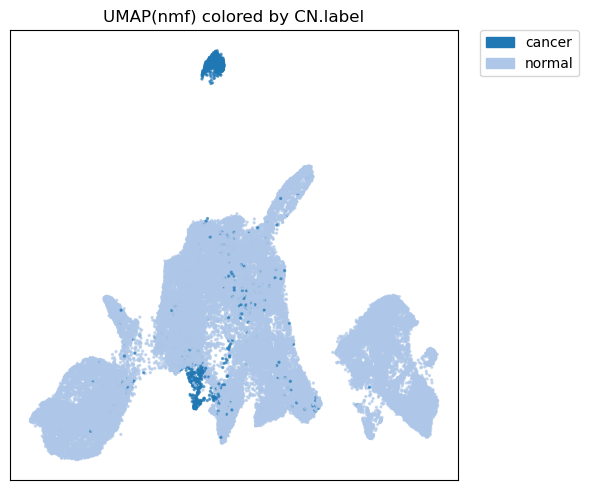

/tmp/ipykernel_3066695/4198137662.py:27: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(AD.obs[a]) or AD.obs[a].dtype == object:


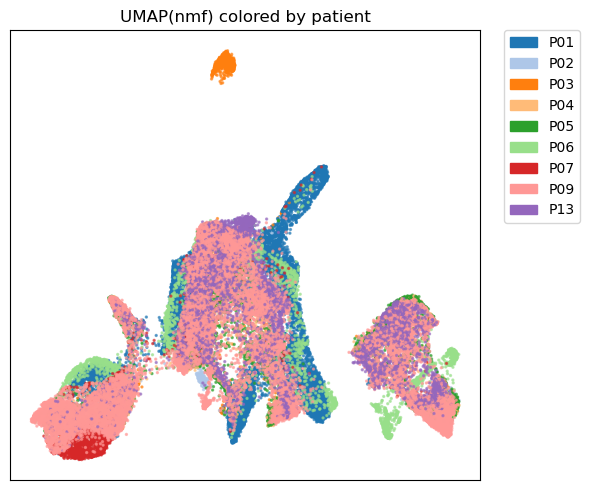

/tmp/ipykernel_3066695/4198137662.py:27: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(AD.obs[a]) or AD.obs[a].dtype == object:


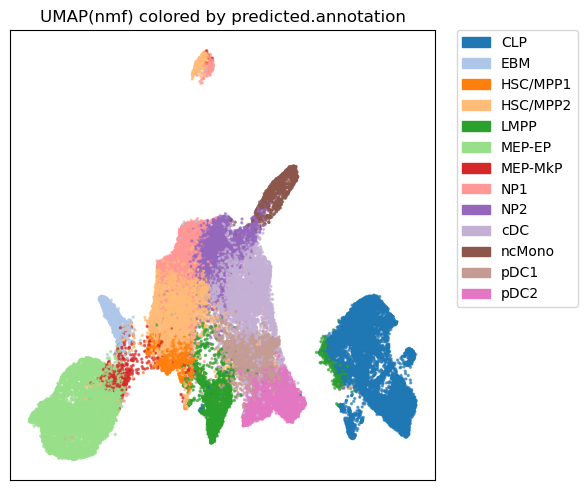

/home/minhang/miniconda3/envs/sc-factosig-gpu/lib/python3.10/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


Computed UMAP for factosig: (49480, 2)


/tmp/ipykernel_3066695/4198137662.py:27: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(AD.obs[a]) or AD.obs[a].dtype == object:


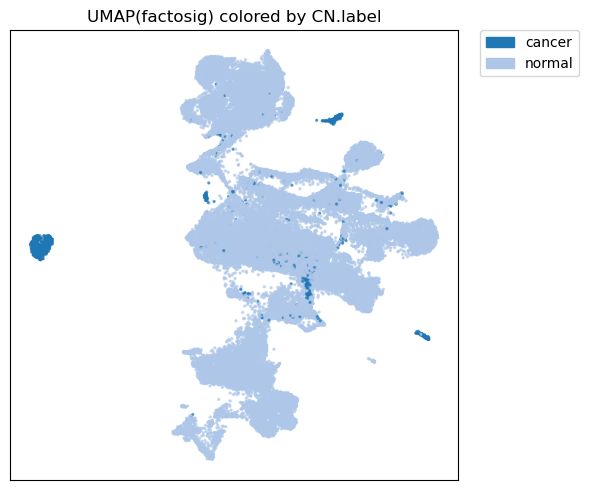

/tmp/ipykernel_3066695/4198137662.py:27: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(AD.obs[a]) or AD.obs[a].dtype == object:


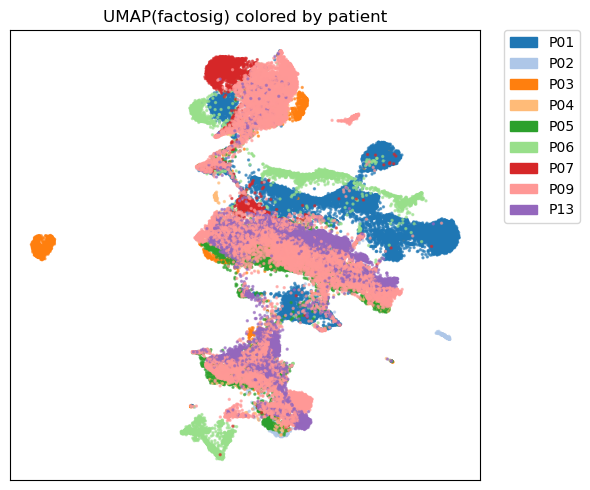

/tmp/ipykernel_3066695/4198137662.py:27: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(AD.obs[a]) or AD.obs[a].dtype == object:


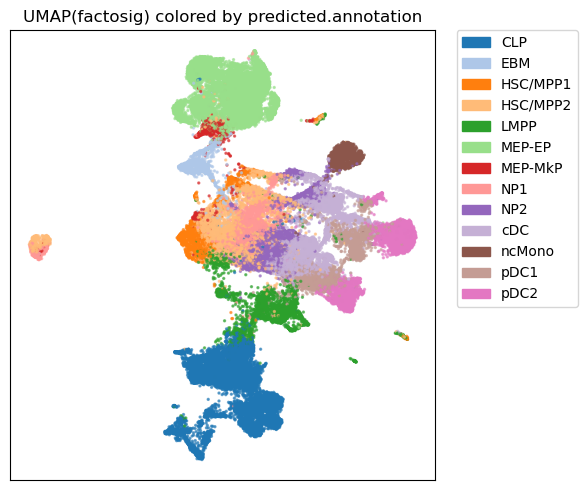

In [18]:
# UMAP based on each DR method; color by attributes
import matplotlib.patches as mpatches
attrs = [c for c in ['CN.label', 'patient', 'predicted.annotation'] if c in AD.obs.columns]
print("Attributes available:", attrs)

# Use umap-learn directly on scores for reproducibility and speed
try:
    import umap
except Exception:
    umap = None

if umap is None:
    print("umap-learn not installed; install via pip install umap-learn")
else:
    for m, (obsm_key, _, _) in method_keys.items():
        if obsm_key not in AD.obsm:
            print(f"Missing {obsm_key}; skipping {m}")
            continue
        Z = AD.obsm[obsm_key]
        reducer = umap.UMAP(n_neighbors=30, min_dist=0.3, random_state=42)
        emb = reducer.fit_transform(Z)
        AD.obsm[f'X_umap_{m}'] = emb
        print(f"Computed UMAP for {m}: {emb.shape}")
        
        for a in attrs:
            plt.figure(figsize=(6, 5))
            if pd.api.types.is_categorical_dtype(AD.obs[a]) or AD.obs[a].dtype == object:
                # categorical palette
                cats = AD.obs[a].astype(str)
                # palette map
                uniq = pd.Index(sorted(cats.unique()))
                cmap = dict(zip(uniq, sns.color_palette("tab20", n_colors=min(len(uniq), 20))))
                colors = cats.map(cmap).apply(lambda c: tuple(c) if isinstance(c, tuple) else (0.5,0.5,0.5))
                colors = np.vstack(colors.values)
                plt.scatter(emb[:,0], emb[:,1], c=colors, s=2, alpha=0.6)
                
                # Create legend
                legend_handles = [mpatches.Patch(color=c, label=l) for l, c in cmap.items()]
                plt.legend(handles=legend_handles, bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)
                
                plt.title(f"UMAP({m}) colored by {a}")
            else:
                sc = plt.scatter(emb[:,0], emb[:,1], c=AD.obs[a].values, s=2, alpha=0.6, cmap='viridis')
                plt.colorbar(sc)
                plt.title(f"UMAP({m}) colored by {a}")
            plt.xticks([]); plt.yticks([])
            plt.tight_layout(); plt.show()


### Single factor Separation Score (signed AUC)

pca          fa         nmf    factosig
count  100.000000  100.000000  100.000000  100.000000
mean     0.067763    0.005180    0.166072    0.096897
std      0.566517    0.572031    0.547140    0.531190
min     -0.848544   -0.771757   -0.703415   -0.686304
25%     -0.525396   -0.533448   -0.528056   -0.515897
50%      0.503533   -0.500979    0.520137    0.508658
75%      0.544067    0.549500    0.569364    0.529307
max      0.761009    0.803819    0.931107    0.841541

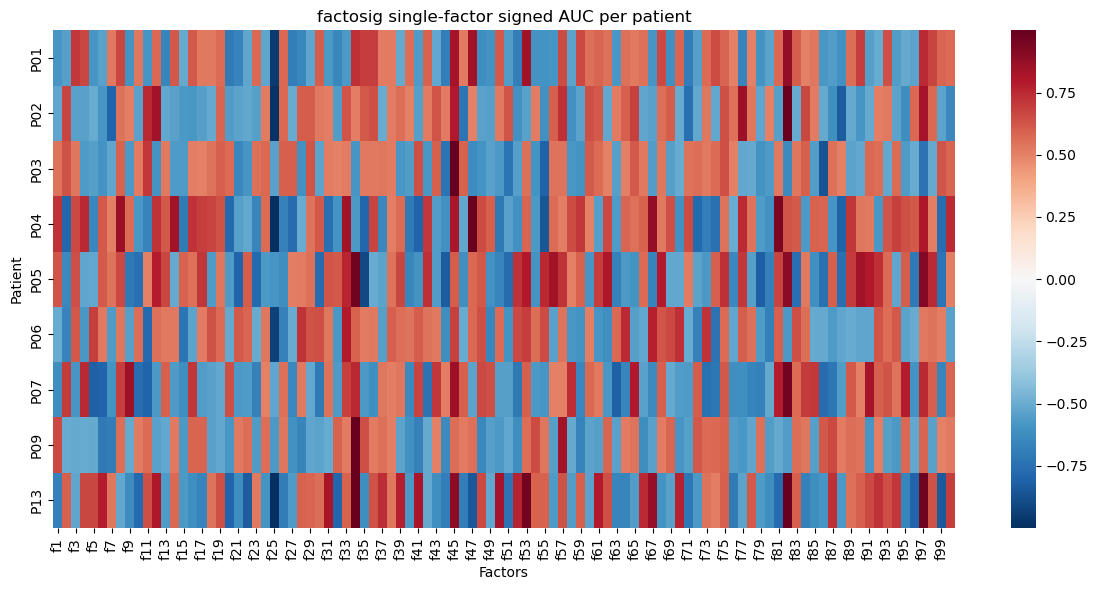

In [14]:
# Single-factor separation score (signed AUC) across all cells and per patient
from sklearn.metrics import roc_auc_score

def signed_auc(y_true: np.ndarray, z: np.ndarray) -> float:
    # AUC in [0,1]; sign by median difference cancer - normal
    auc = roc_auc_score(y_true, z)
    sgn = np.sign(np.median(z[y_true==1]) - np.median(z[y_true==0]))
    auc_signed = sgn * (auc if auc >= 0.5 else (1 - auc))
    return float(auc_signed)

label = AD.obs[label_col].astype(str).map({"normal":0, "cancer":1}).to_numpy()
patients = AD.obs['patient'].astype(str) if 'patient' in AD.obs.columns else pd.Series(['ALL']*AD.n_obs)

sep_all = {}
for m, (obsm_key, _, _) in method_keys.items():
    if obsm_key not in AD.obsm:
        continue
    Z = AD.obsm[obsm_key]
    sep_all[m] = [signed_auc(label, Z[:, j]) for j in range(Z.shape[1])]

sep_all_df = pd.DataFrame(sep_all)
display(sep_all_df.describe())

# Per-patient separation score heatmap for a method (e.g., FactoSig)
def patient_separation_scores(method: str) -> pd.DataFrame:
    Z = AD.obsm[method_keys[method][0]]
    p = AD.obs['patient'].astype(str)
    y = label
    rows = {}
    for pid in sorted(p.unique()):
        idx = np.flatnonzero(p == pid)
        if idx.size < 10:
            continue
        y_p = y[idx]
        Zp = Z[idx, :]
        rows[pid] = [signed_auc(y_p, Zp[:, j]) for j in range(Zp.shape[1])]
    return pd.DataFrame.from_dict(rows, orient='index', columns=[f'f{j+1}' for j in range(Z.shape[1])])

method_for_heatmap = 'factosig'
pat_df = patient_separation_scores(method_for_heatmap)
plt.figure(figsize=(12, max(6, pat_df.shape[0]*0.25)))
sns.heatmap(pat_df, cmap='RdBu_r', center=0)
plt.title(f"{method_for_heatmap} single-factor signed AUC per patient")
plt.xlabel("Factors"); plt.ylabel("Patient")
plt.tight_layout(); plt.show()

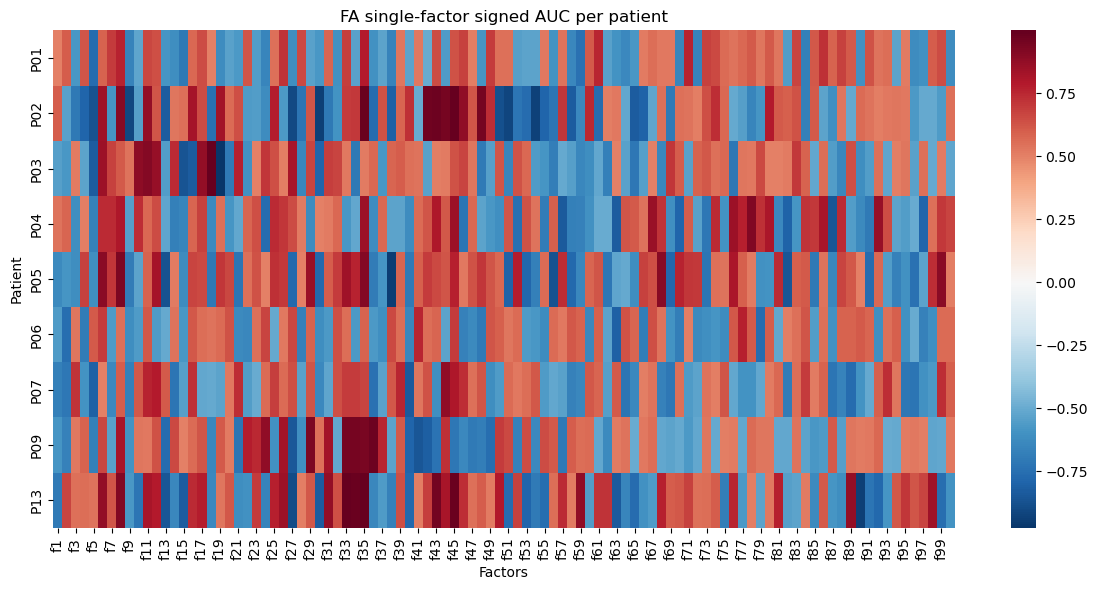

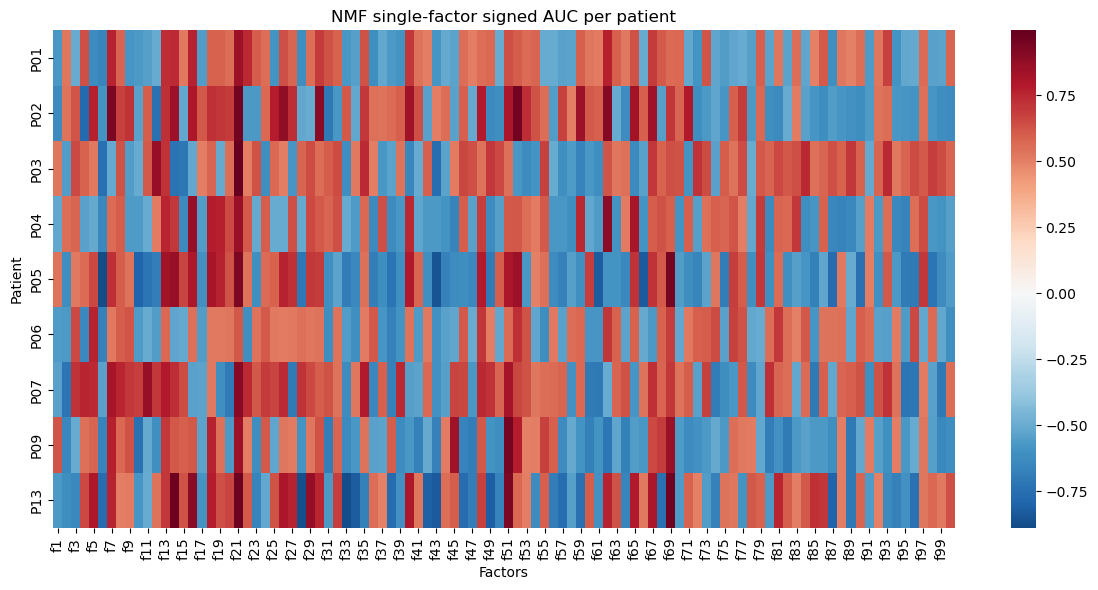

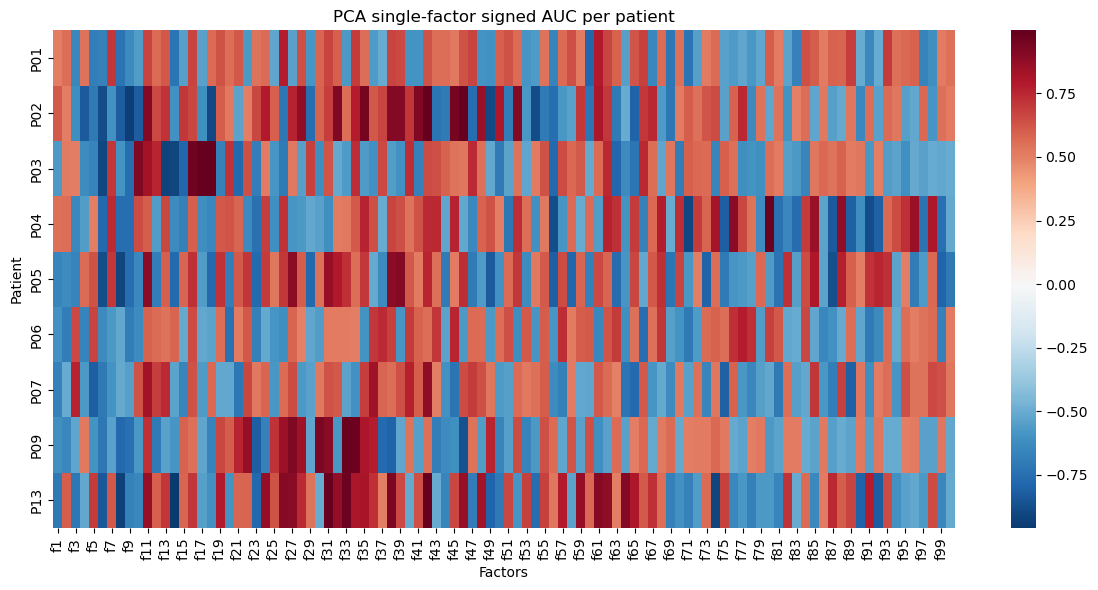

In [15]:
# plot the heatmap of the separation scores of the fa method
pat_df = patient_separation_scores('fa')
plt.figure(figsize=(12, max(6, pat_df.shape[0]*0.25)))
sns.heatmap(pat_df, cmap='RdBu_r', center=0)
plt.title(f"FA single-factor signed AUC per patient")
plt.xlabel("Factors"); plt.ylabel("Patient")
plt.tight_layout(); plt.show()

# plot the heatmap of the separation scores of the nmf method
pat_df = patient_separation_scores('nmf')
plt.figure(figsize=(12, max(6, pat_df.shape[0]*0.25)))
sns.heatmap(pat_df, cmap='RdBu_r', center=0)
plt.title(f"NMF single-factor signed AUC per patient")
plt.xlabel("Factors"); plt.ylabel("Patient")
plt.tight_layout(); plt.show()

# plot the heatmap of the separation scores of the pca method
pat_df = patient_separation_scores('pca')
plt.figure(figsize=(12, max(6, pat_df.shape[0]*0.25)))
sns.heatmap(pat_df, cmap='RdBu_r', center=0)
plt.title(f"PCA single-factor signed AUC per patient")
plt.xlabel("Factors"); plt.ylabel("Patient")
plt.tight_layout(); plt.show()


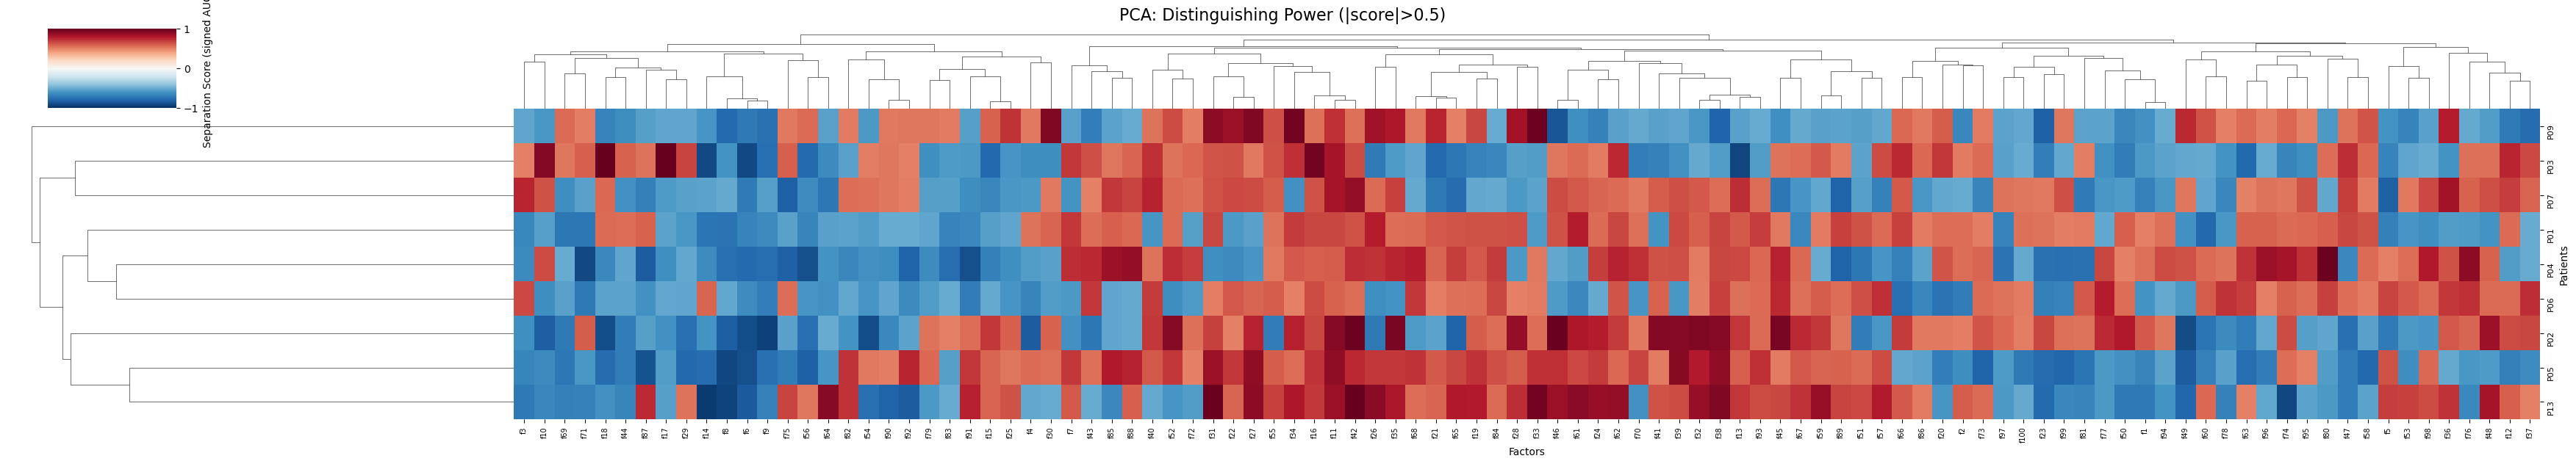

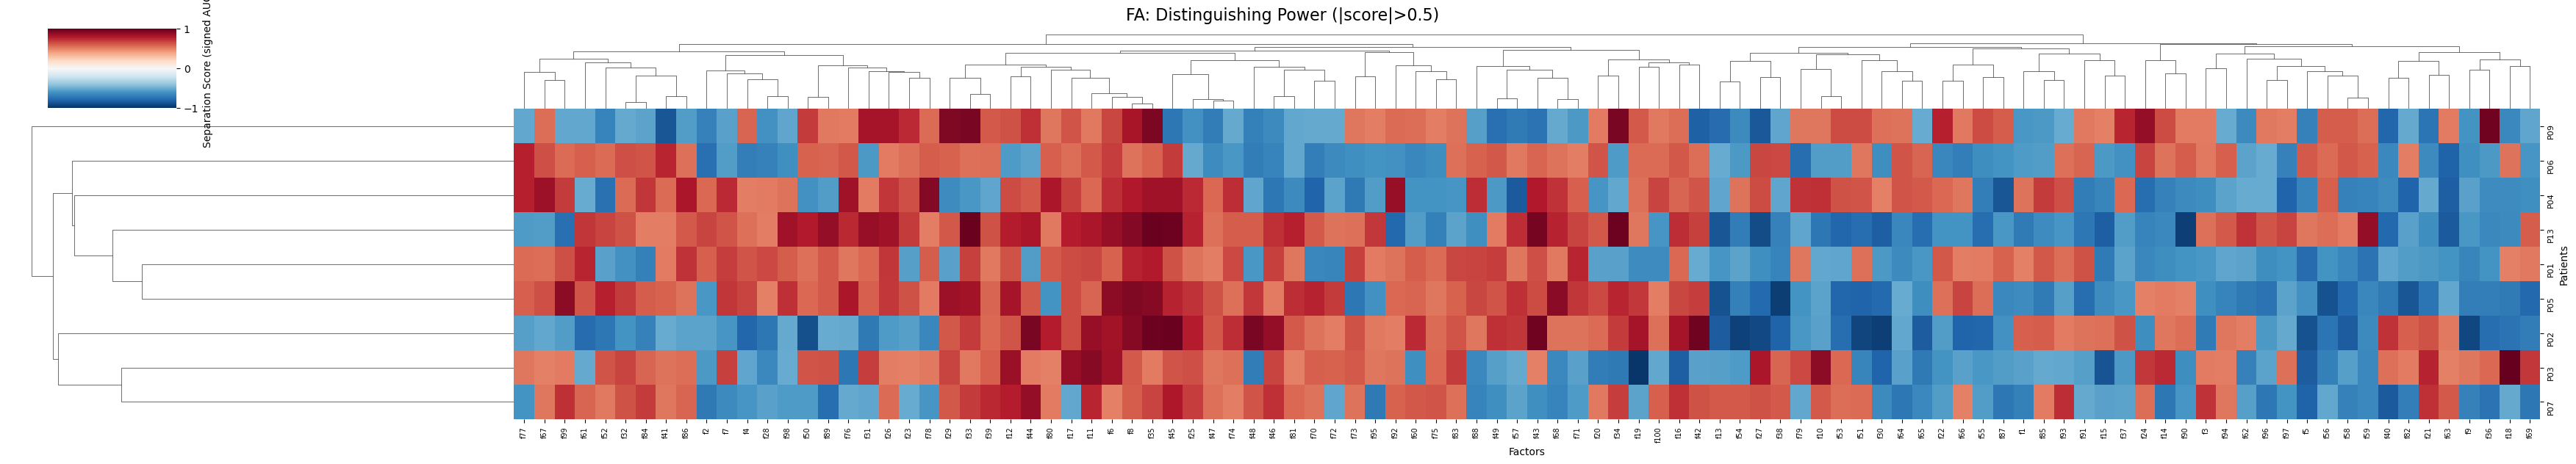

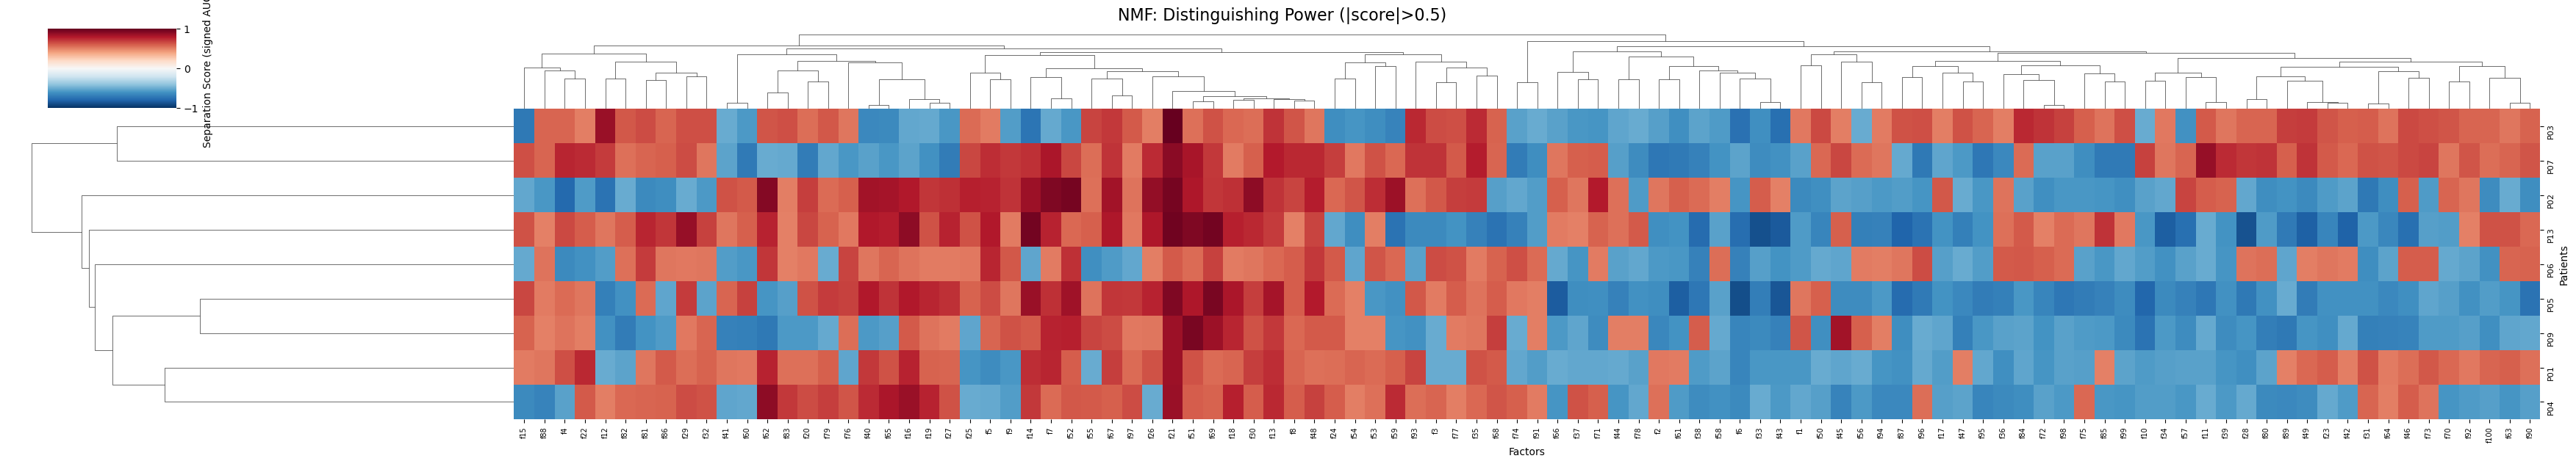

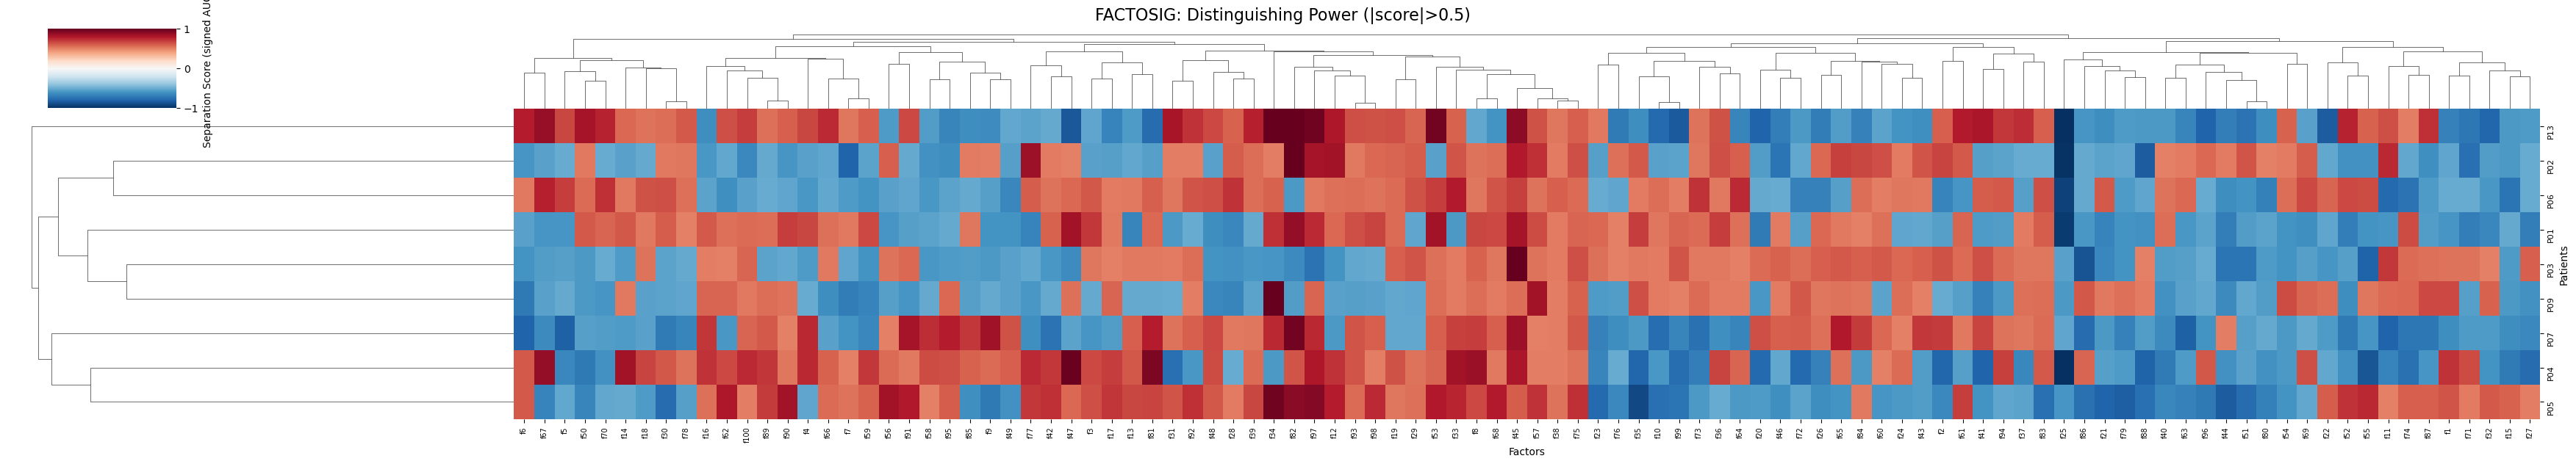

In [16]:
# Clustered heatmaps for per-patient signed AUC (stronger colors)

def plot_clustered_signed_auc(scores_df: pd.DataFrame,
                              abs_threshold: float = 0.5,
                              patients_to_exclude=None,
                              title: str = "",
                              figsize_scale=(0.35, 0.5),
                              center=0):
    import seaborn as sns
    if patients_to_exclude is None:
        patients_to_exclude = []
    filt_df = scores_df.loc[:, (scores_df.abs() > abs_threshold).any(axis=0)]
    if filt_df.empty:
        print("No factors pass the |score| threshold; plotting all factors instead.")
        filt_df = scores_df.copy()
    filt_df = filt_df.drop(index=patients_to_exclude, errors="ignore")
    heatmap_data = filt_df.fillna(0.0)

    w = max(12, heatmap_data.shape[1] * figsize_scale[0])
    h = max(6, heatmap_data.shape[0] * figsize_scale[1])
    cg = sns.clustermap(
        heatmap_data,
        method="average",
        metric="euclidean",
        cmap="RdBu_r",
        center=center,
        vmin=-1, vmax=1,
        figsize=(w, h),
        cbar_kws={"label": "Separation Score (signed AUC)"},
    )
    cg.fig.suptitle(title or f"Factors with any |score| > {abs_threshold}", fontsize=16, y=1.03)
    cg.ax_heatmap.set_title("")
    plt.setp(cg.ax_heatmap.get_xticklabels(), fontsize=7, rotation=90)
    plt.setp(cg.ax_heatmap.get_yticklabels(), fontsize=8)
    cg.ax_heatmap.set_xlabel("Factors")
    cg.ax_heatmap.set_ylabel("Patients")
    plt.show()

# Build per-patient signed AUC for each method and plot
for m in METHODS:
    if 'patient' not in AD.obs.columns or method_keys[m][0] not in AD.obsm:
        continue
    df_pat = patient_separation_scores(m)
    plot_clustered_signed_auc(
        df_pat,
        abs_threshold=0.5,
        patients_to_exclude=[],
        title=f"{m.upper()}: Distinguishing Power (|score|>0.5)",
        figsize_scale=(0.35, 0.6),
        center=0,
    )

### Corr matrix with CN.label

/home/minhang/miniconda3/envs/sc-factosig-gpu/lib/python3.10/site-packages/seaborn/matrix.py:560: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)
/home/minhang/miniconda3/envs/sc-factosig-gpu/lib/python3.10/site-packages/seaborn/matrix.py:560: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)


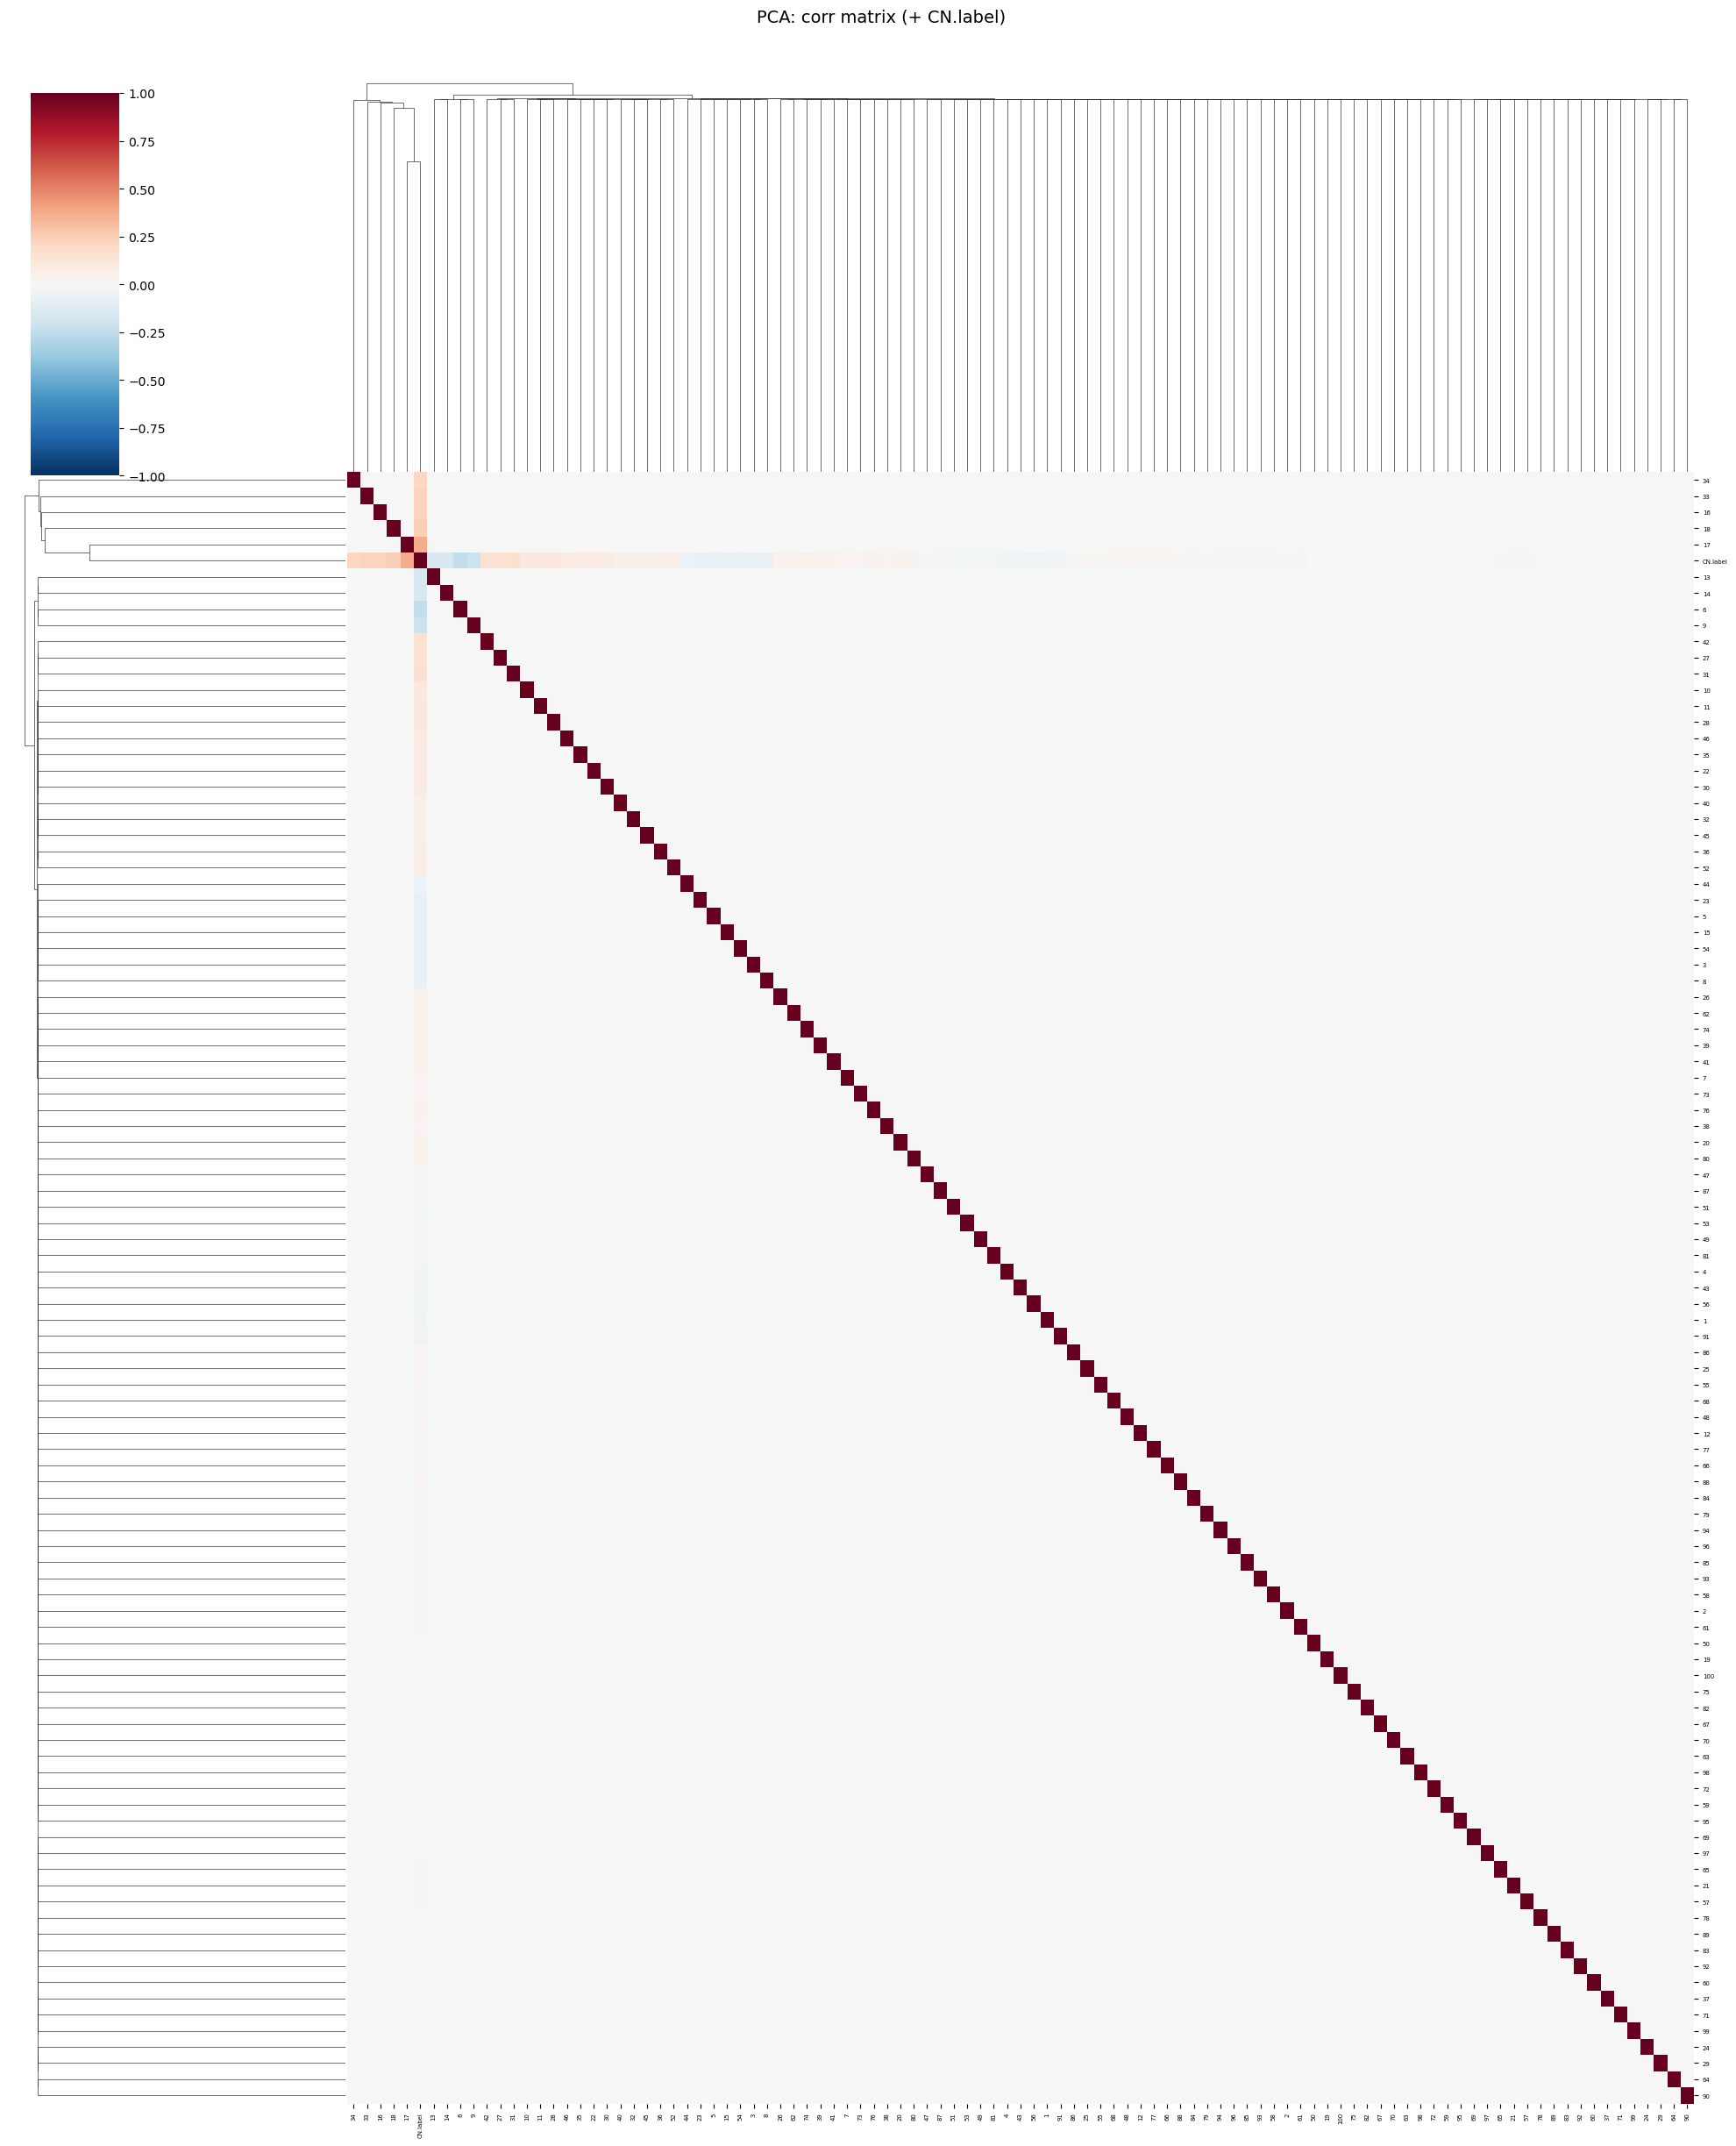

/home/minhang/miniconda3/envs/sc-factosig-gpu/lib/python3.10/site-packages/seaborn/matrix.py:560: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)
/home/minhang/miniconda3/envs/sc-factosig-gpu/lib/python3.10/site-packages/seaborn/matrix.py:560: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)


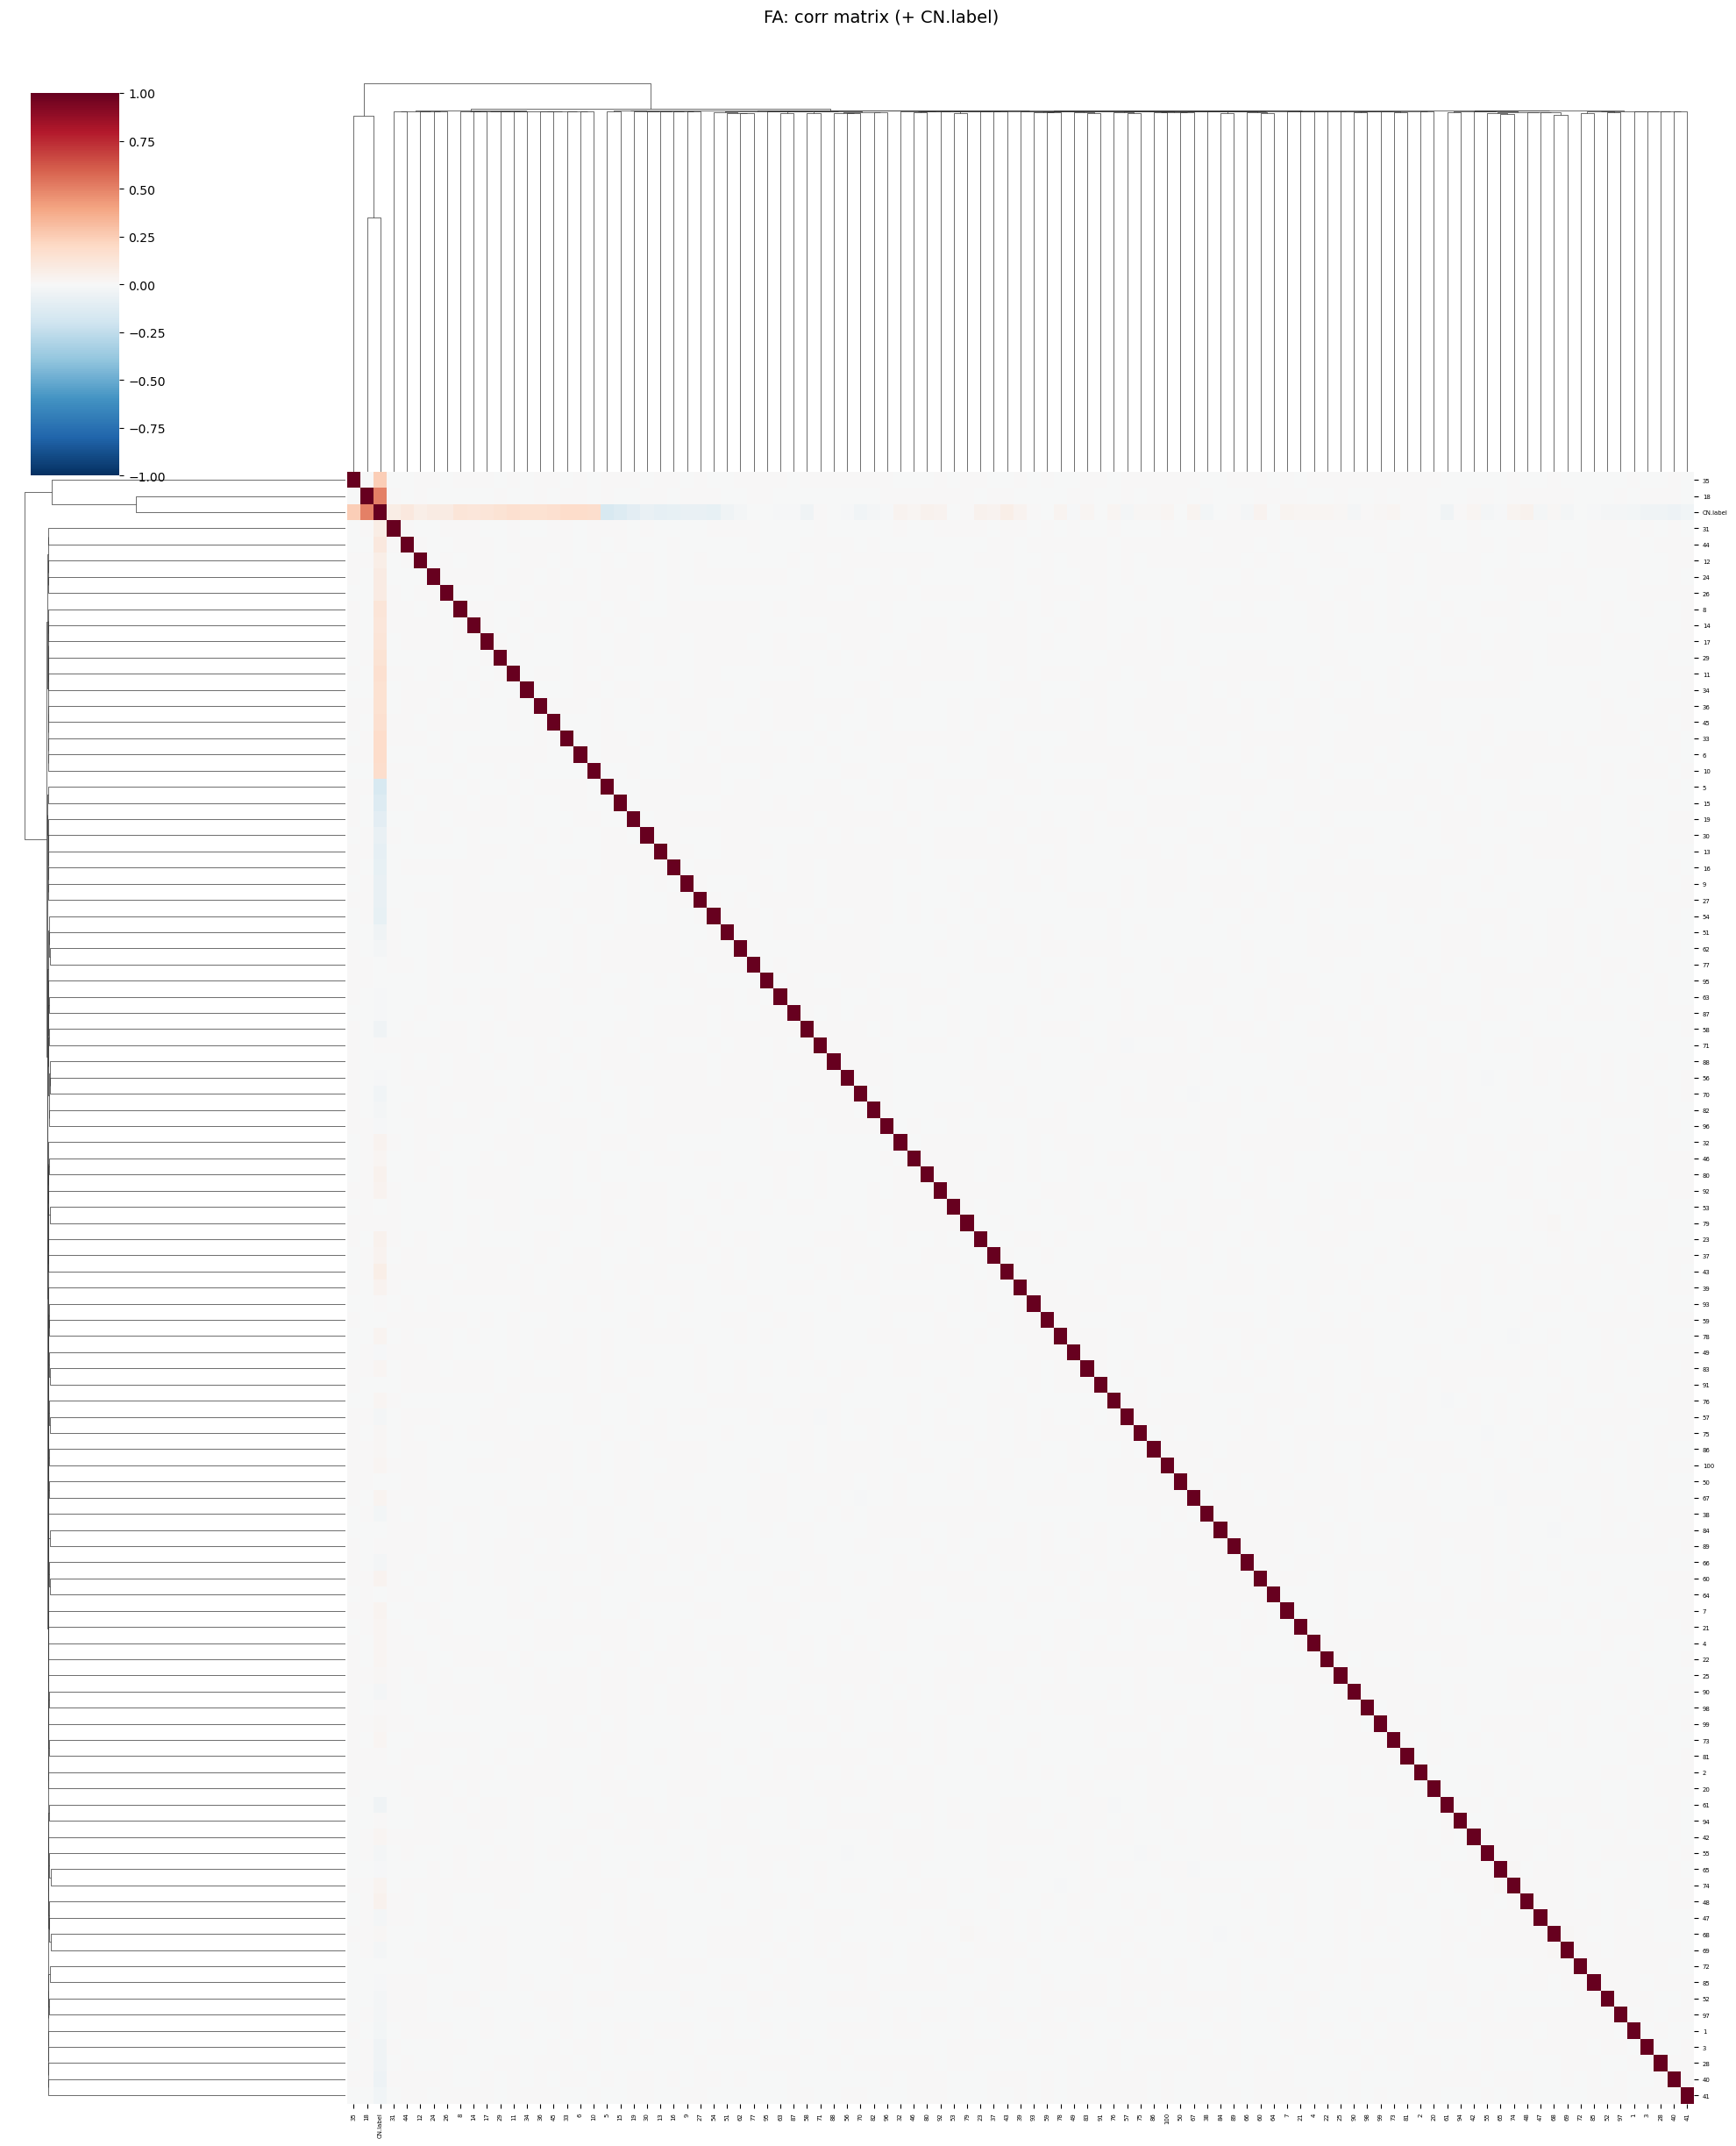

/home/minhang/miniconda3/envs/sc-factosig-gpu/lib/python3.10/site-packages/seaborn/matrix.py:560: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)
/home/minhang/miniconda3/envs/sc-factosig-gpu/lib/python3.10/site-packages/seaborn/matrix.py:560: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)


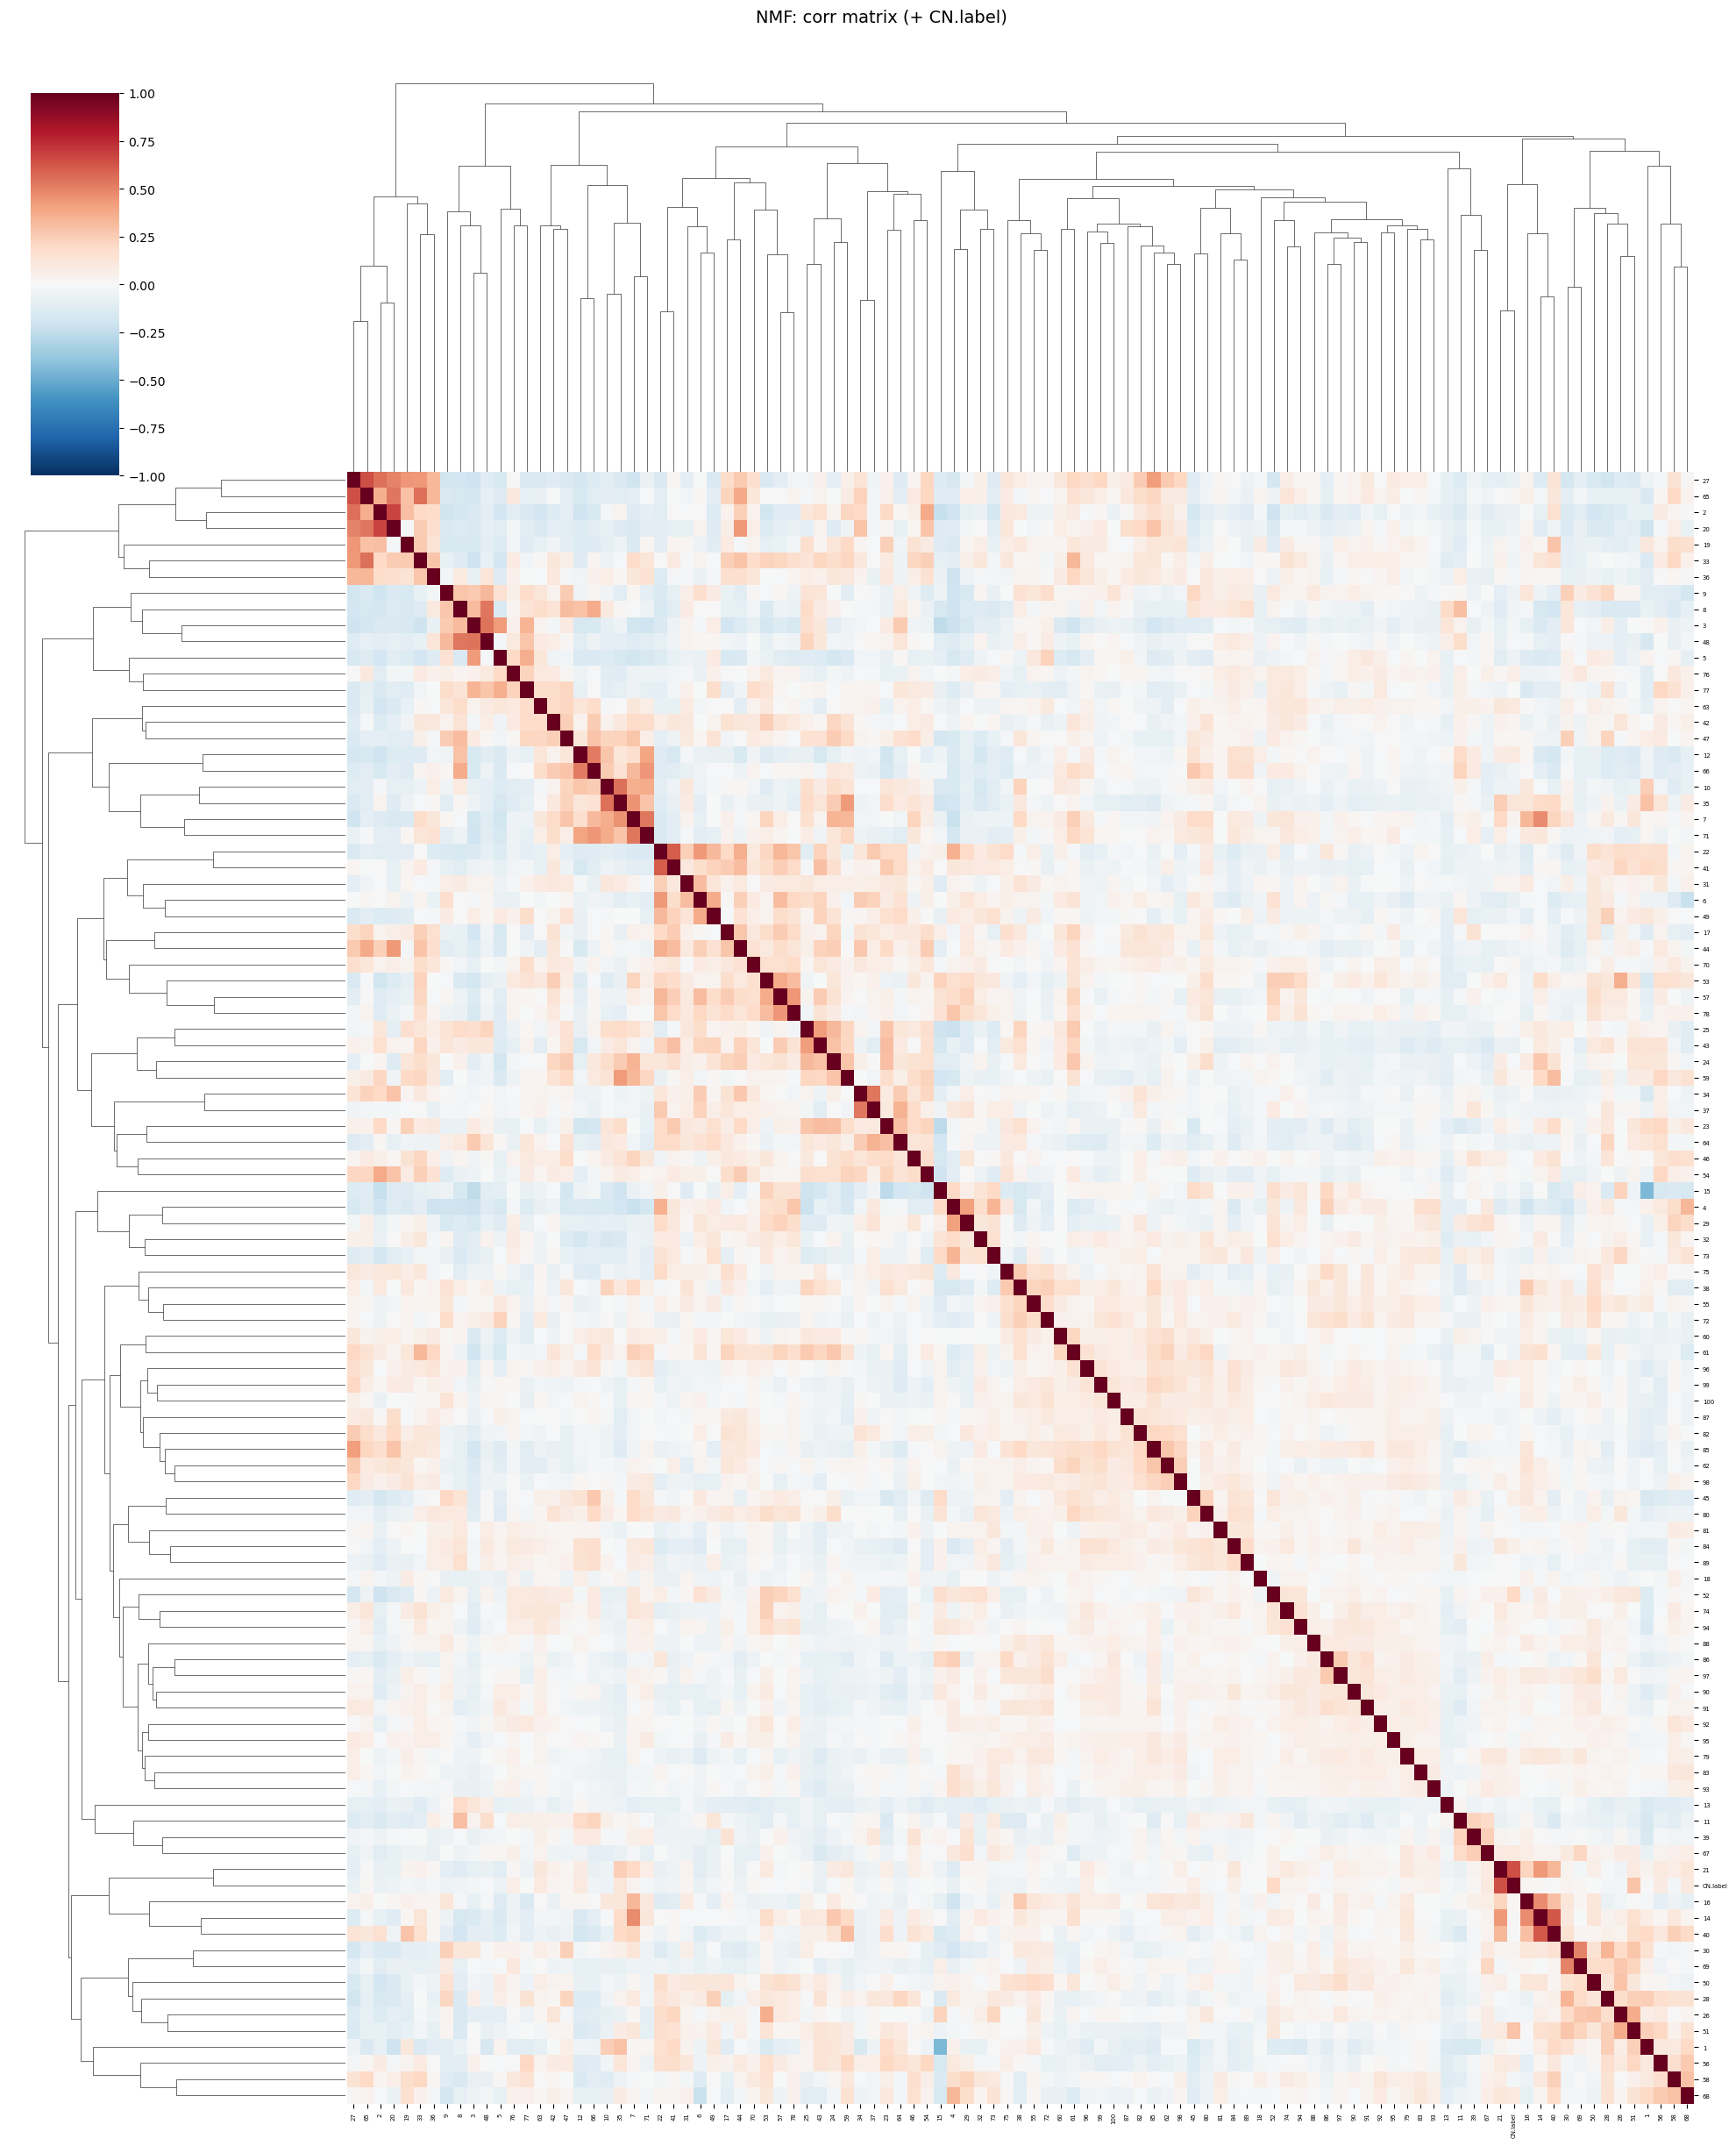

/home/minhang/miniconda3/envs/sc-factosig-gpu/lib/python3.10/site-packages/seaborn/matrix.py:560: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)
/home/minhang/miniconda3/envs/sc-factosig-gpu/lib/python3.10/site-packages/seaborn/matrix.py:560: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)


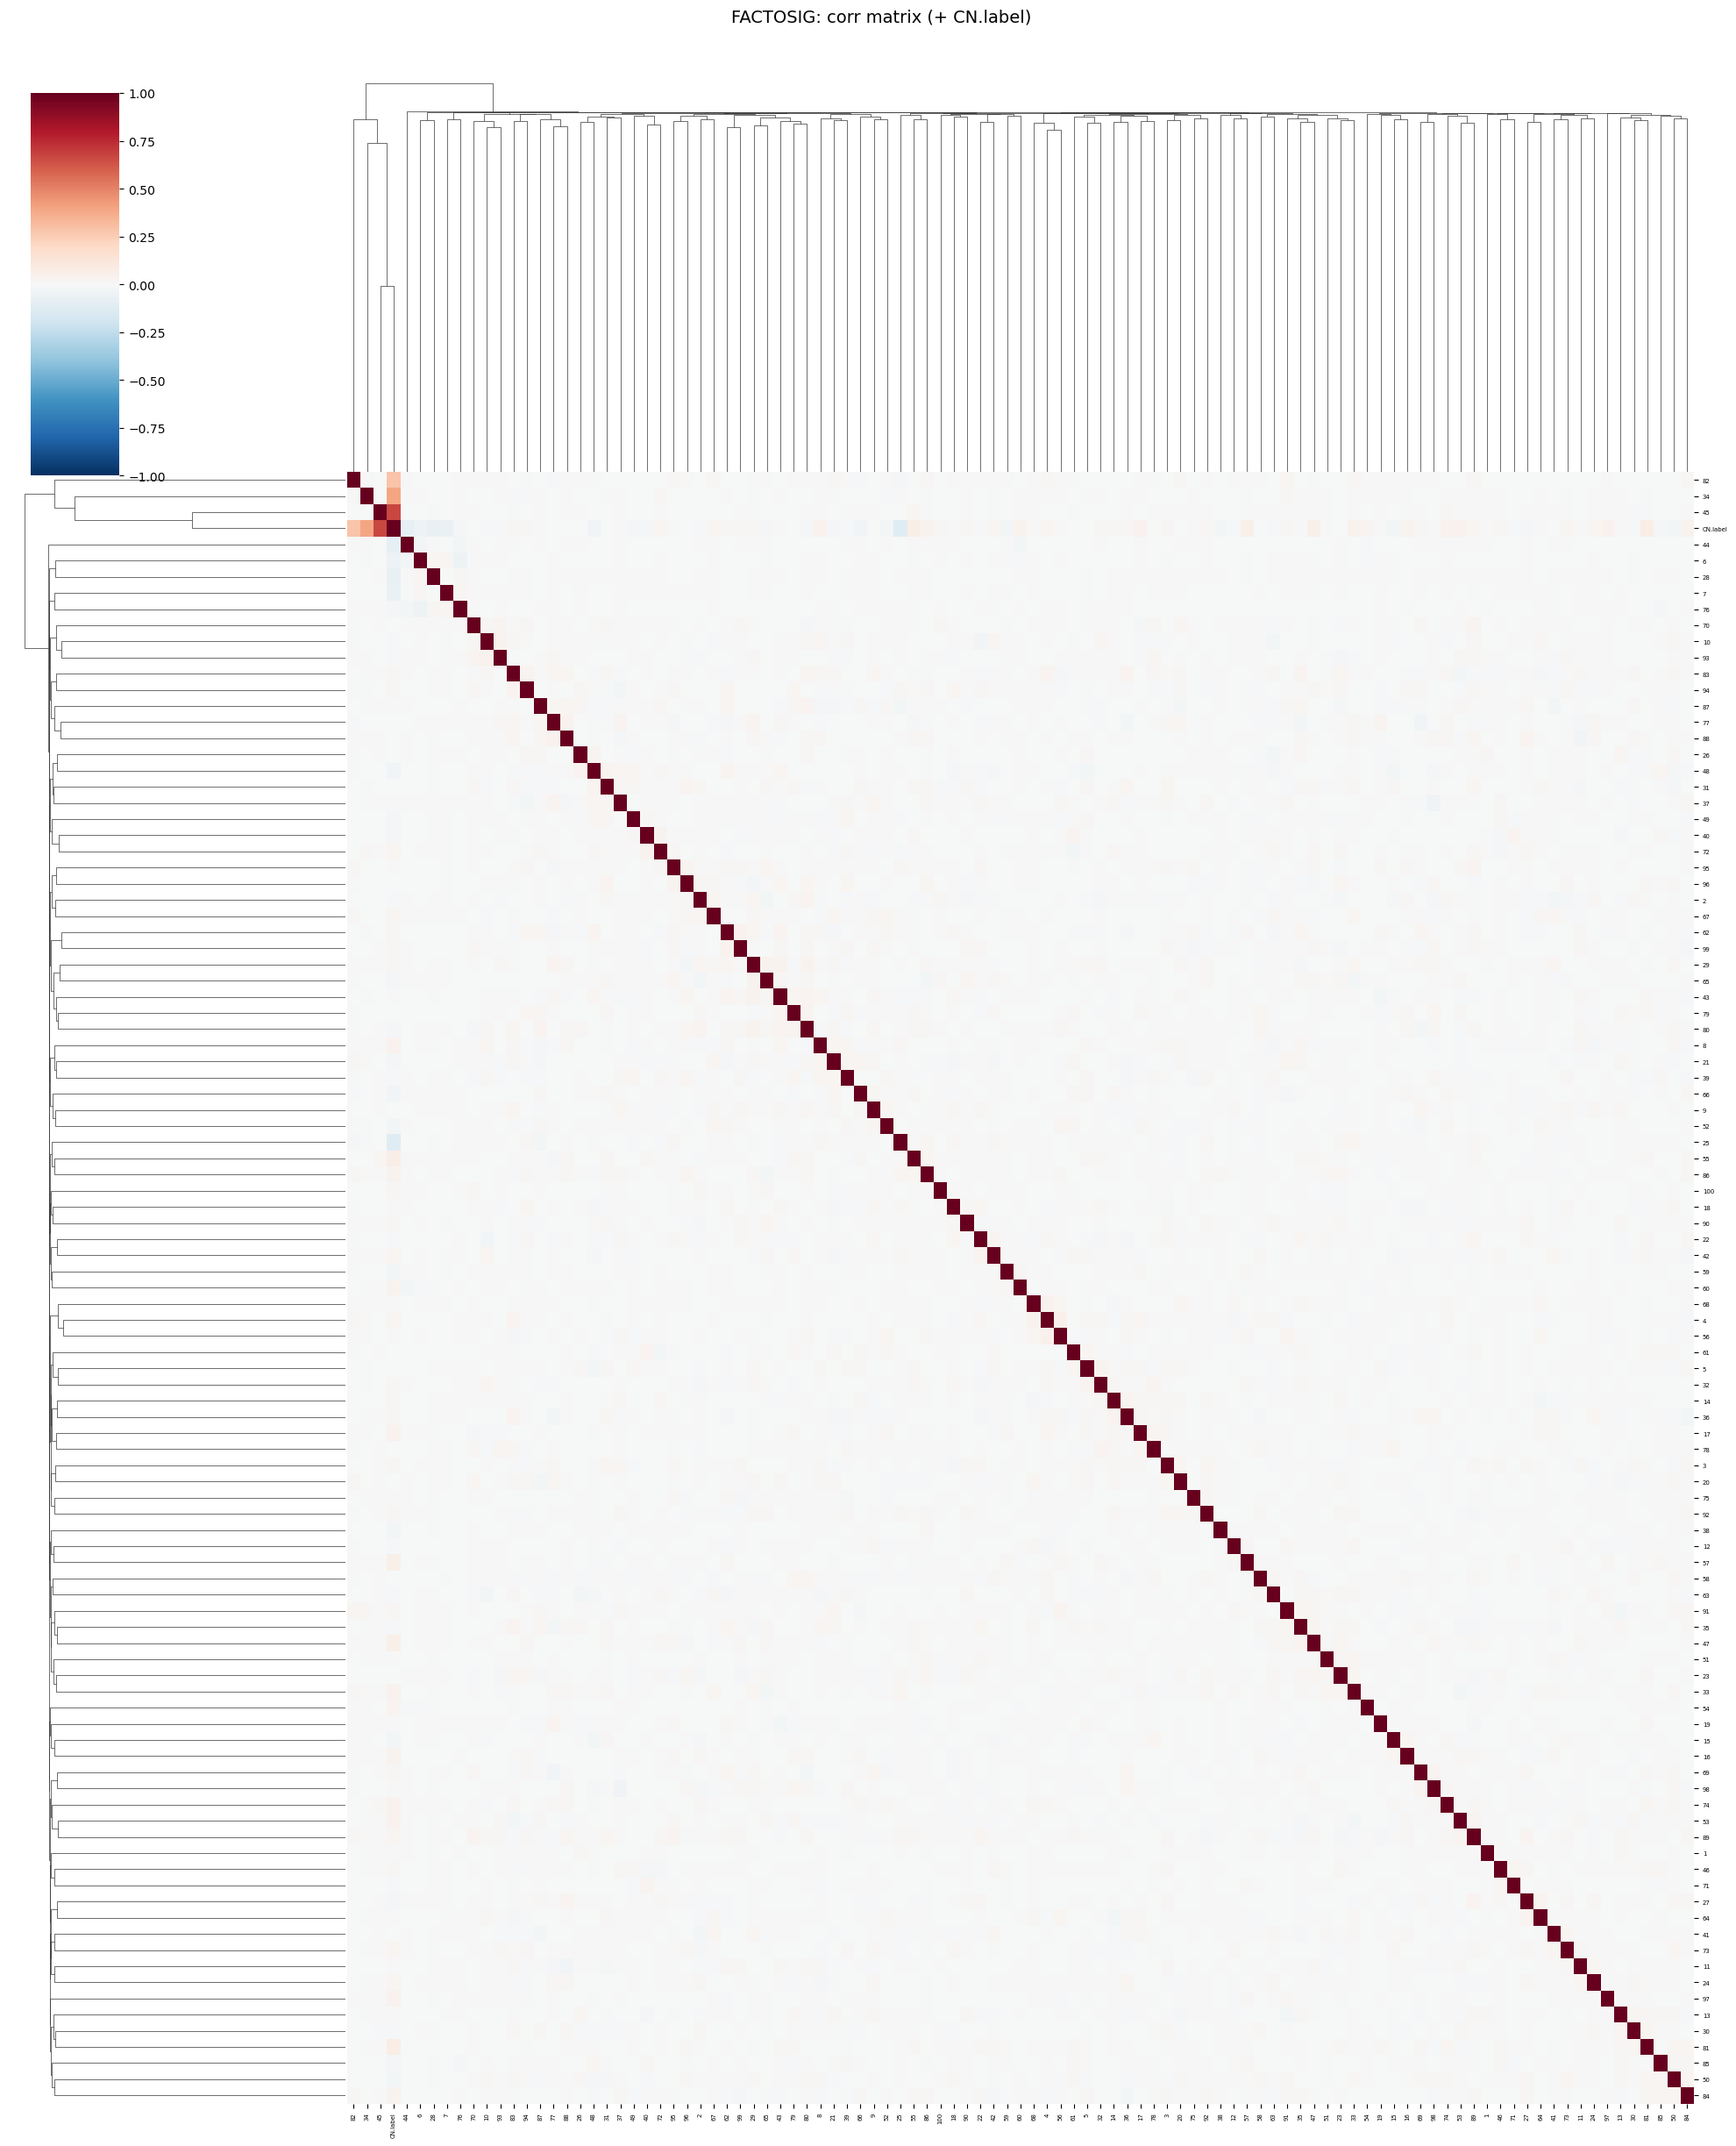

/home/minhang/miniconda3/envs/sc-factosig-gpu/lib/python3.10/site-packages/seaborn/matrix.py:560: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)
/home/minhang/miniconda3/envs/sc-factosig-gpu/lib/python3.10/site-packages/seaborn/matrix.py:560: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)


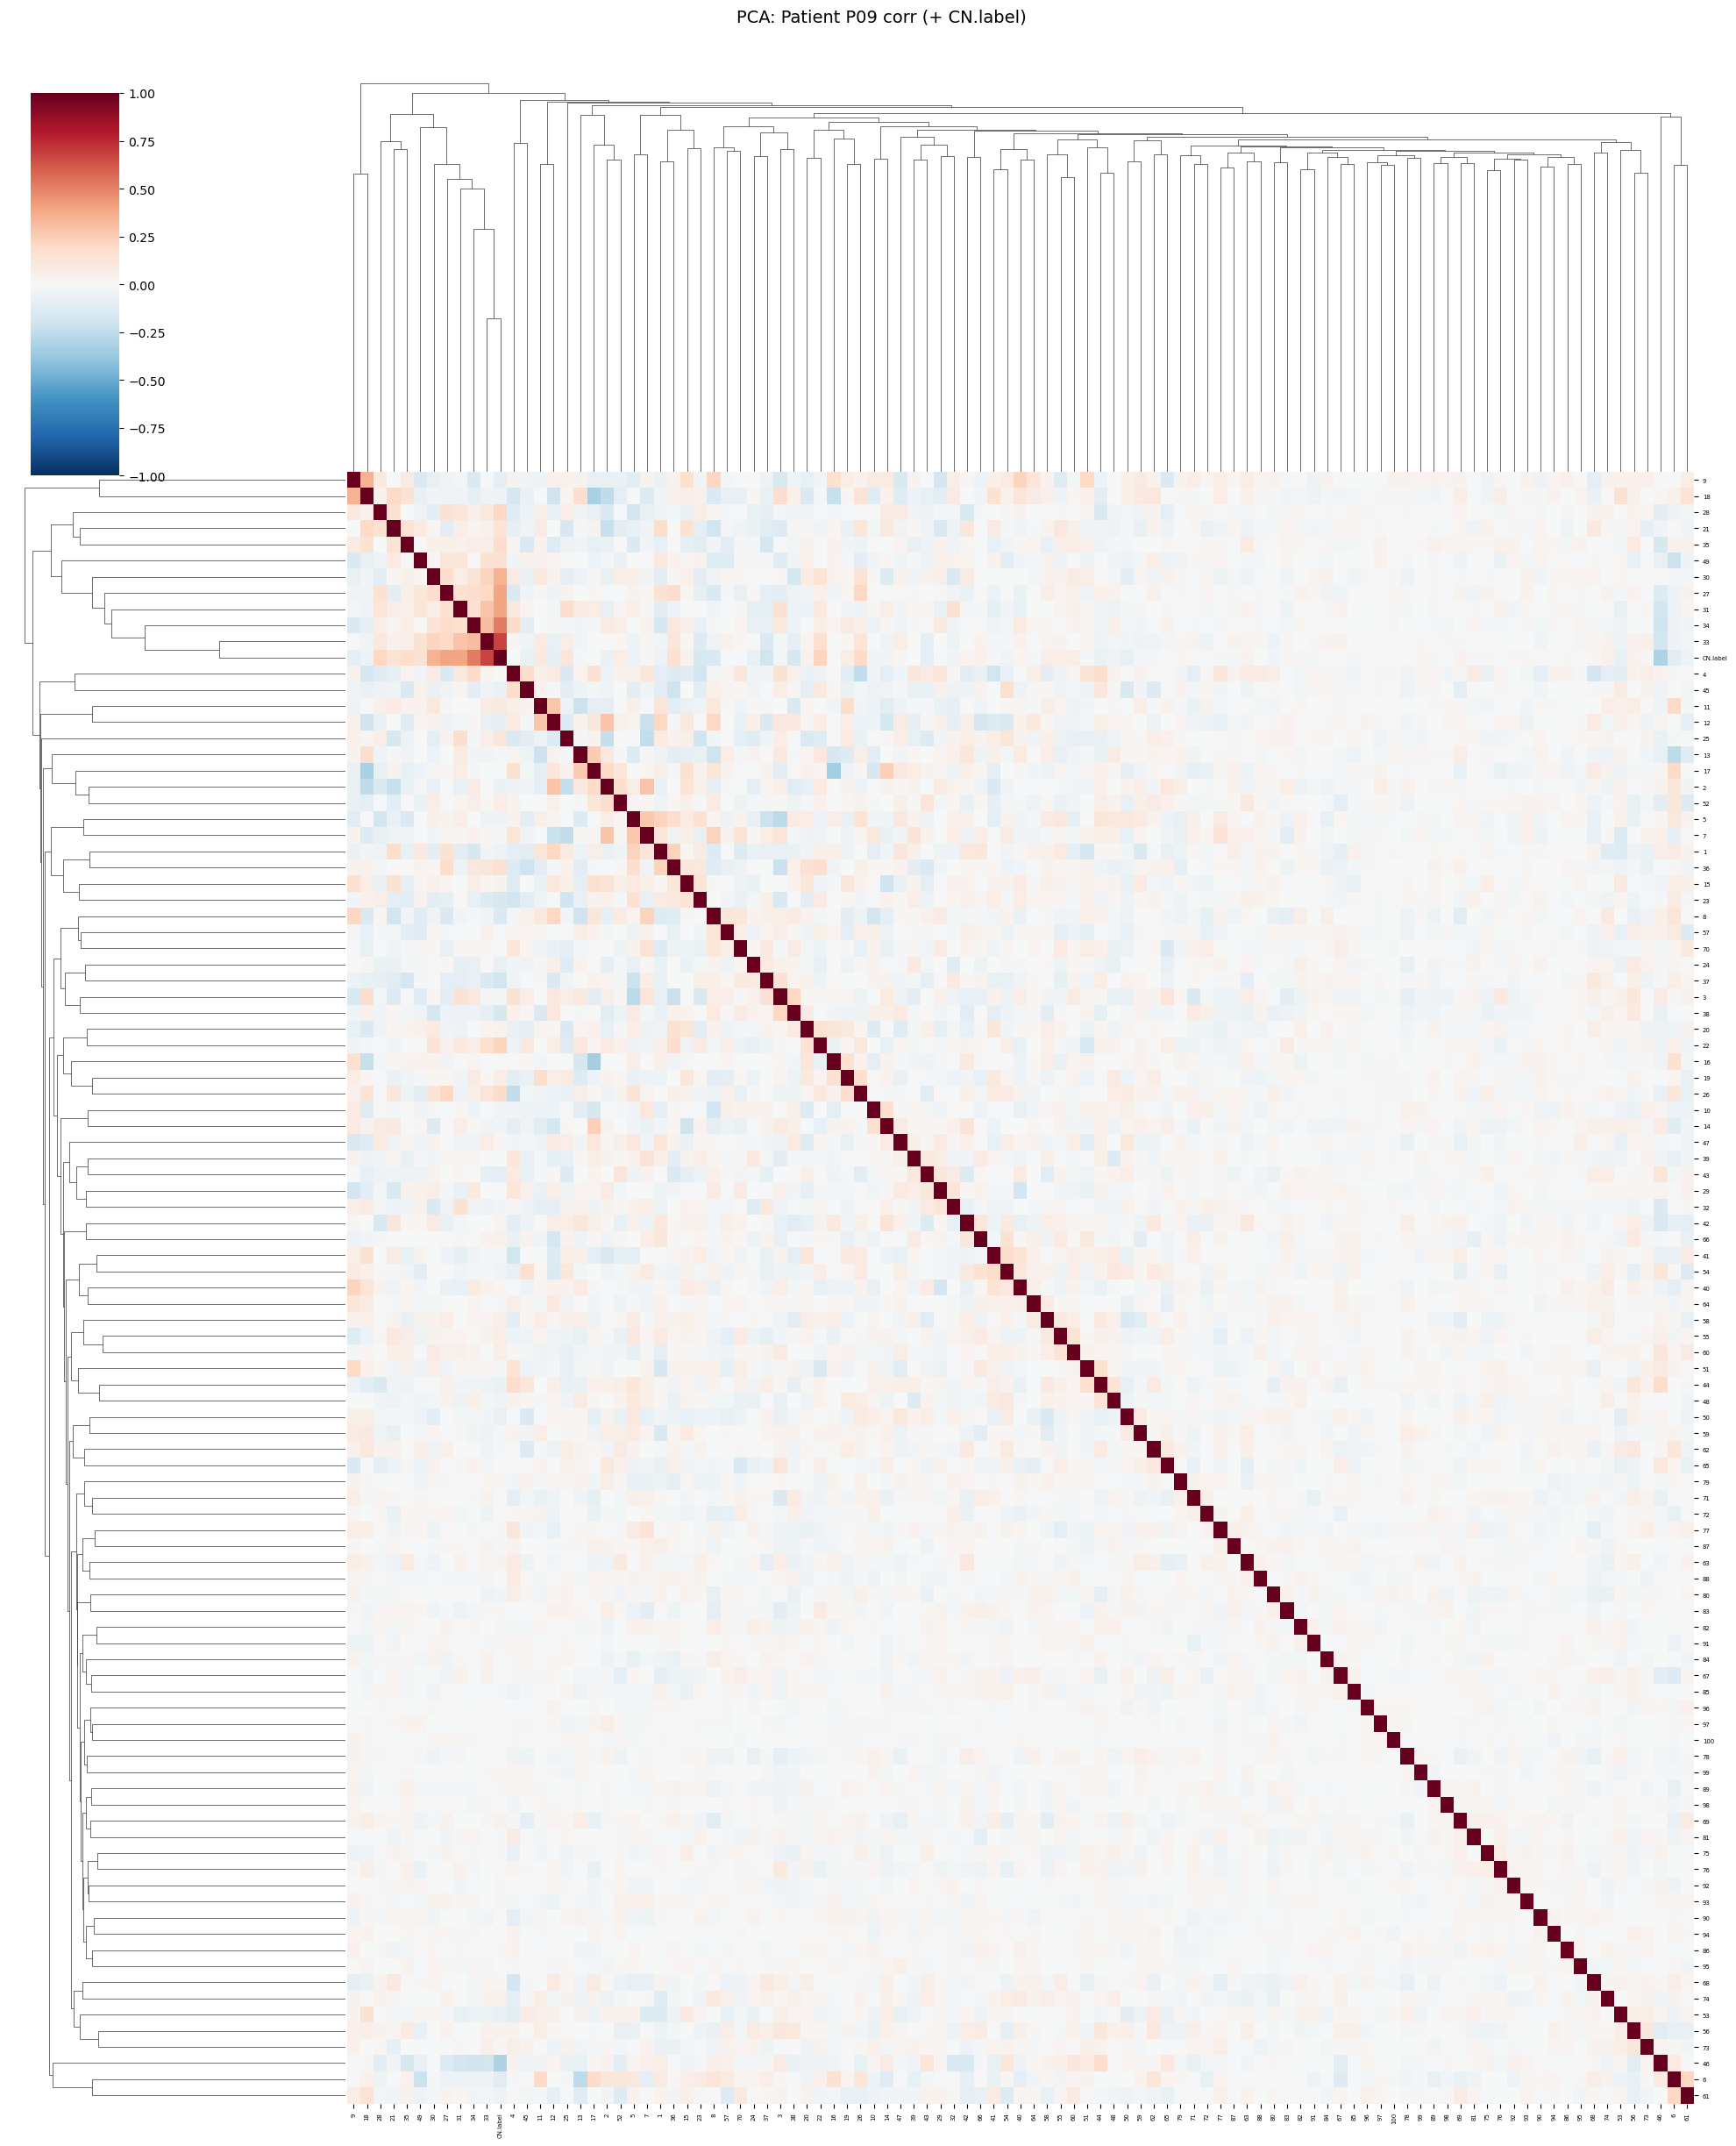

/home/minhang/miniconda3/envs/sc-factosig-gpu/lib/python3.10/site-packages/seaborn/matrix.py:560: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)
/home/minhang/miniconda3/envs/sc-factosig-gpu/lib/python3.10/site-packages/seaborn/matrix.py:560: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)


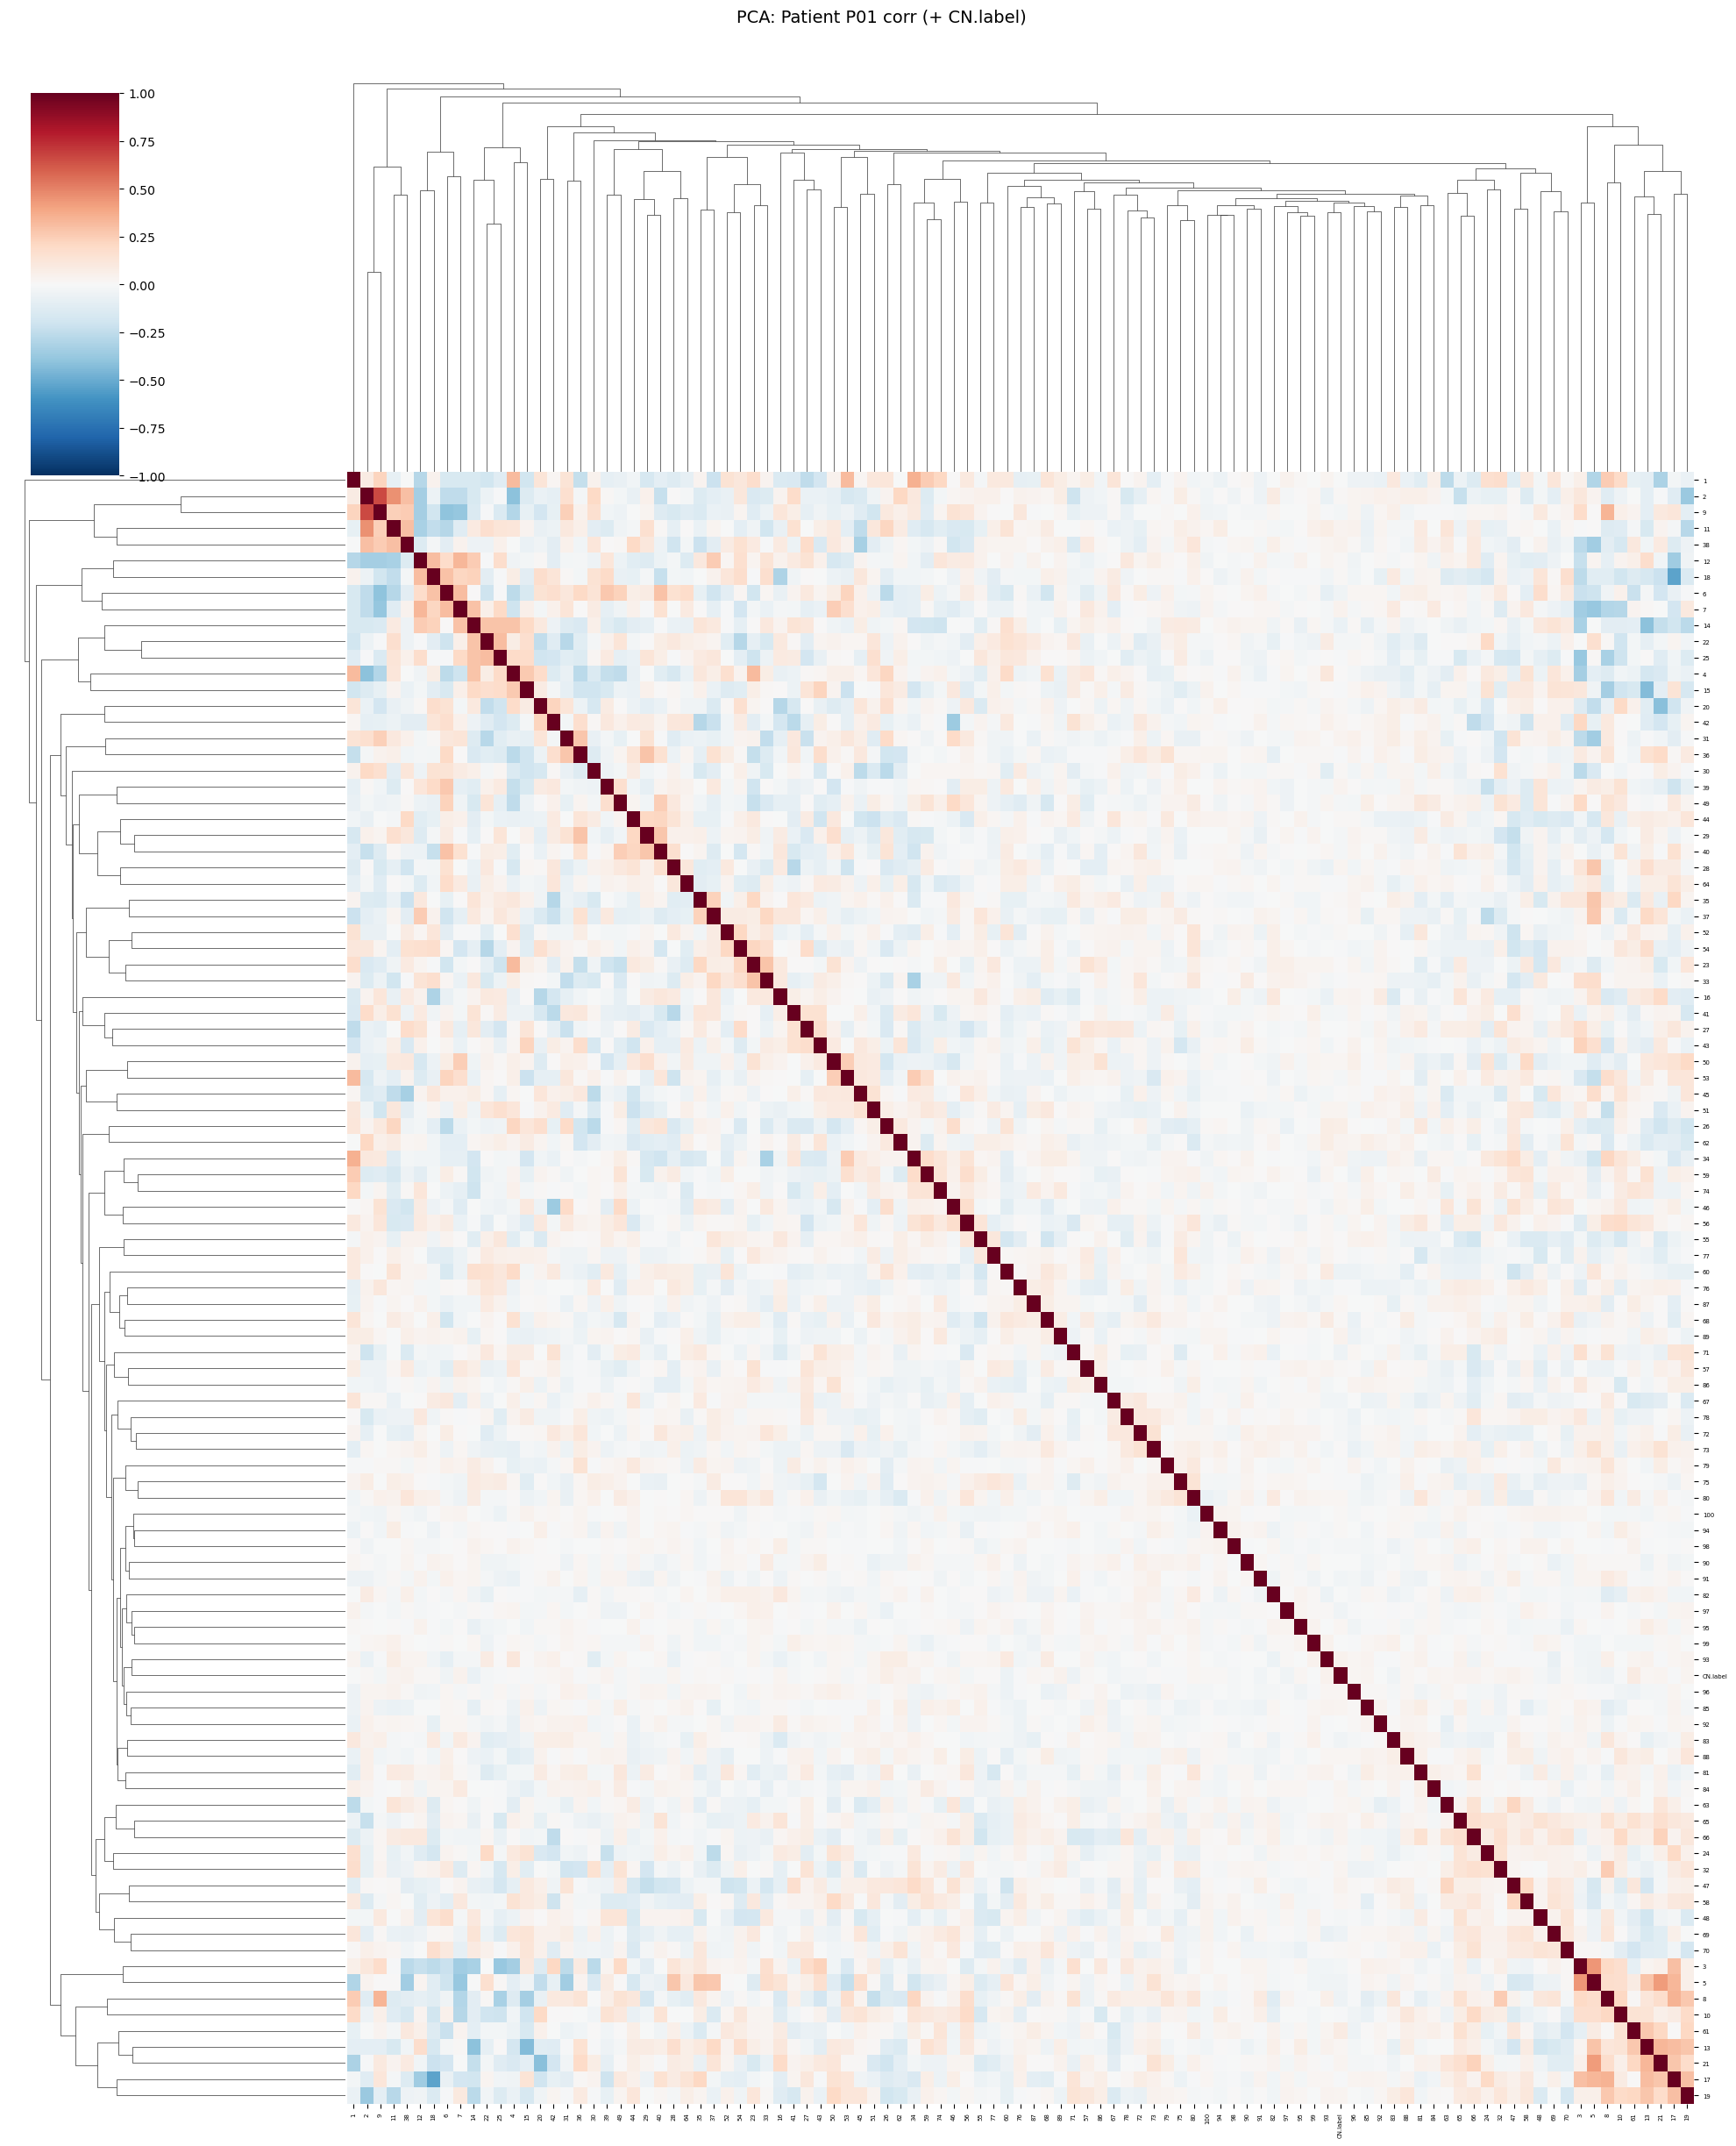

/home/minhang/miniconda3/envs/sc-factosig-gpu/lib/python3.10/site-packages/seaborn/matrix.py:560: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)
/home/minhang/miniconda3/envs/sc-factosig-gpu/lib/python3.10/site-packages/seaborn/matrix.py:560: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)


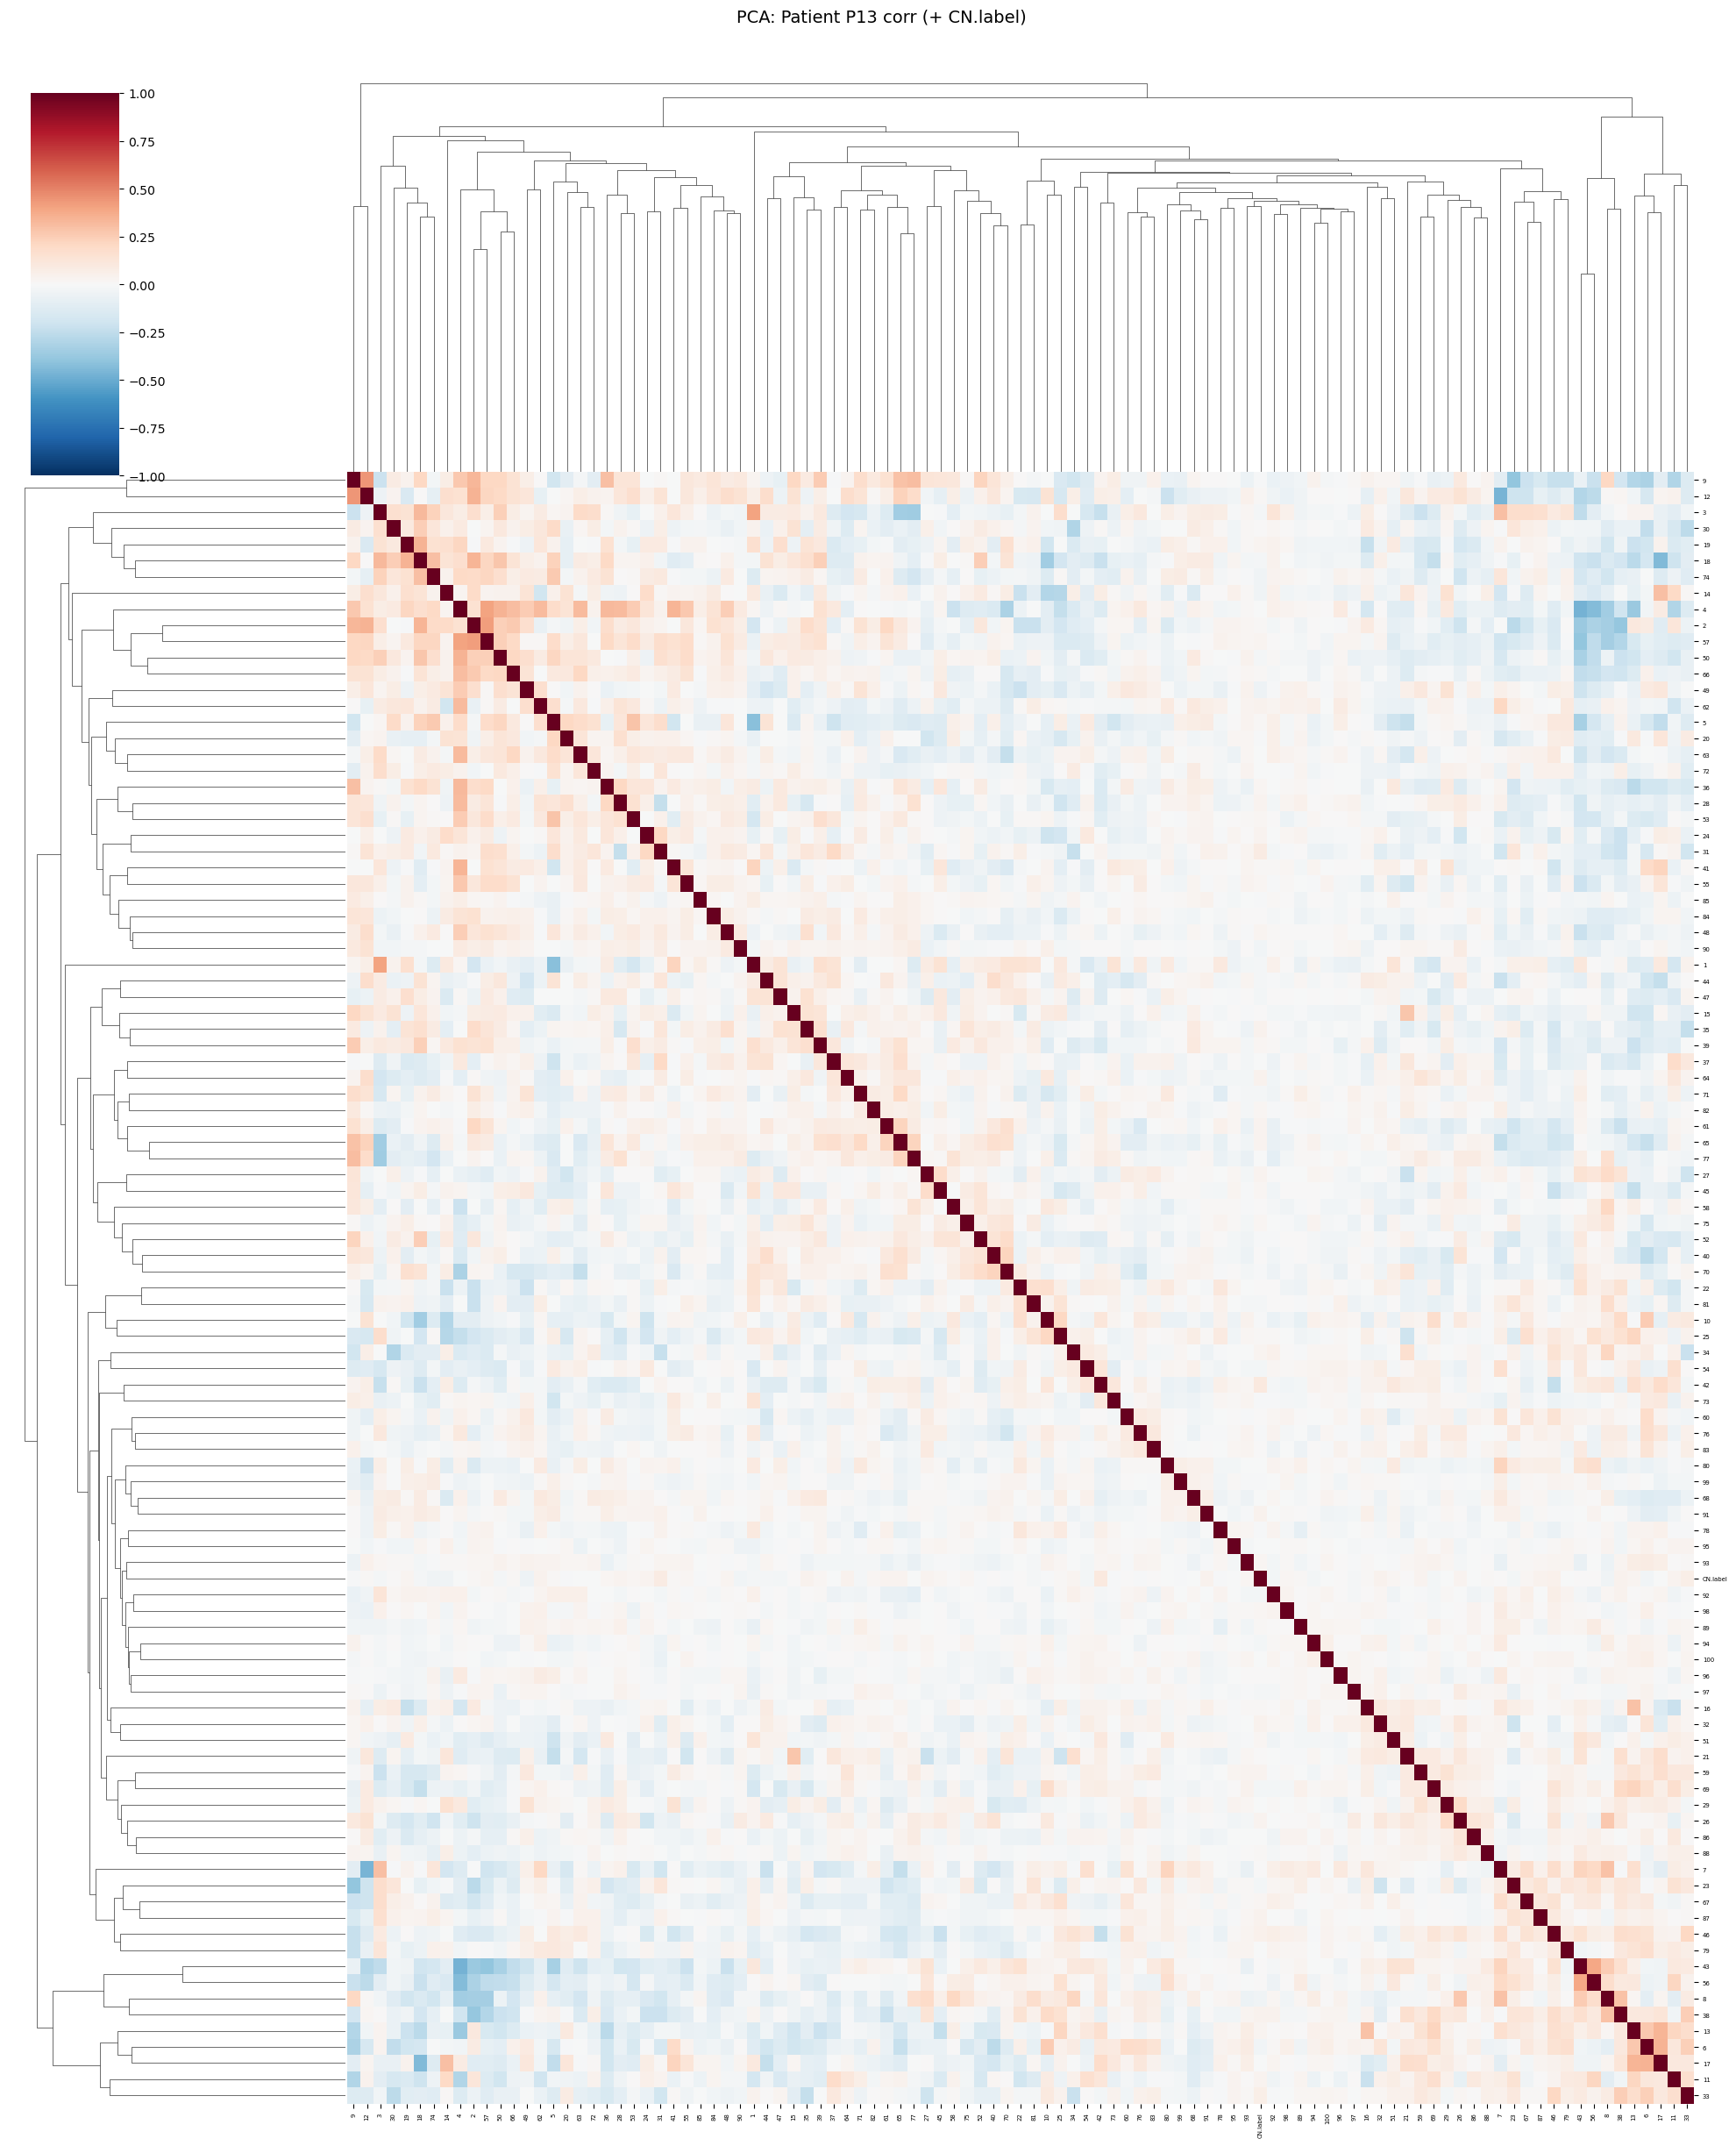

/home/minhang/miniconda3/envs/sc-factosig-gpu/lib/python3.10/site-packages/seaborn/matrix.py:560: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)
/home/minhang/miniconda3/envs/sc-factosig-gpu/lib/python3.10/site-packages/seaborn/matrix.py:560: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)


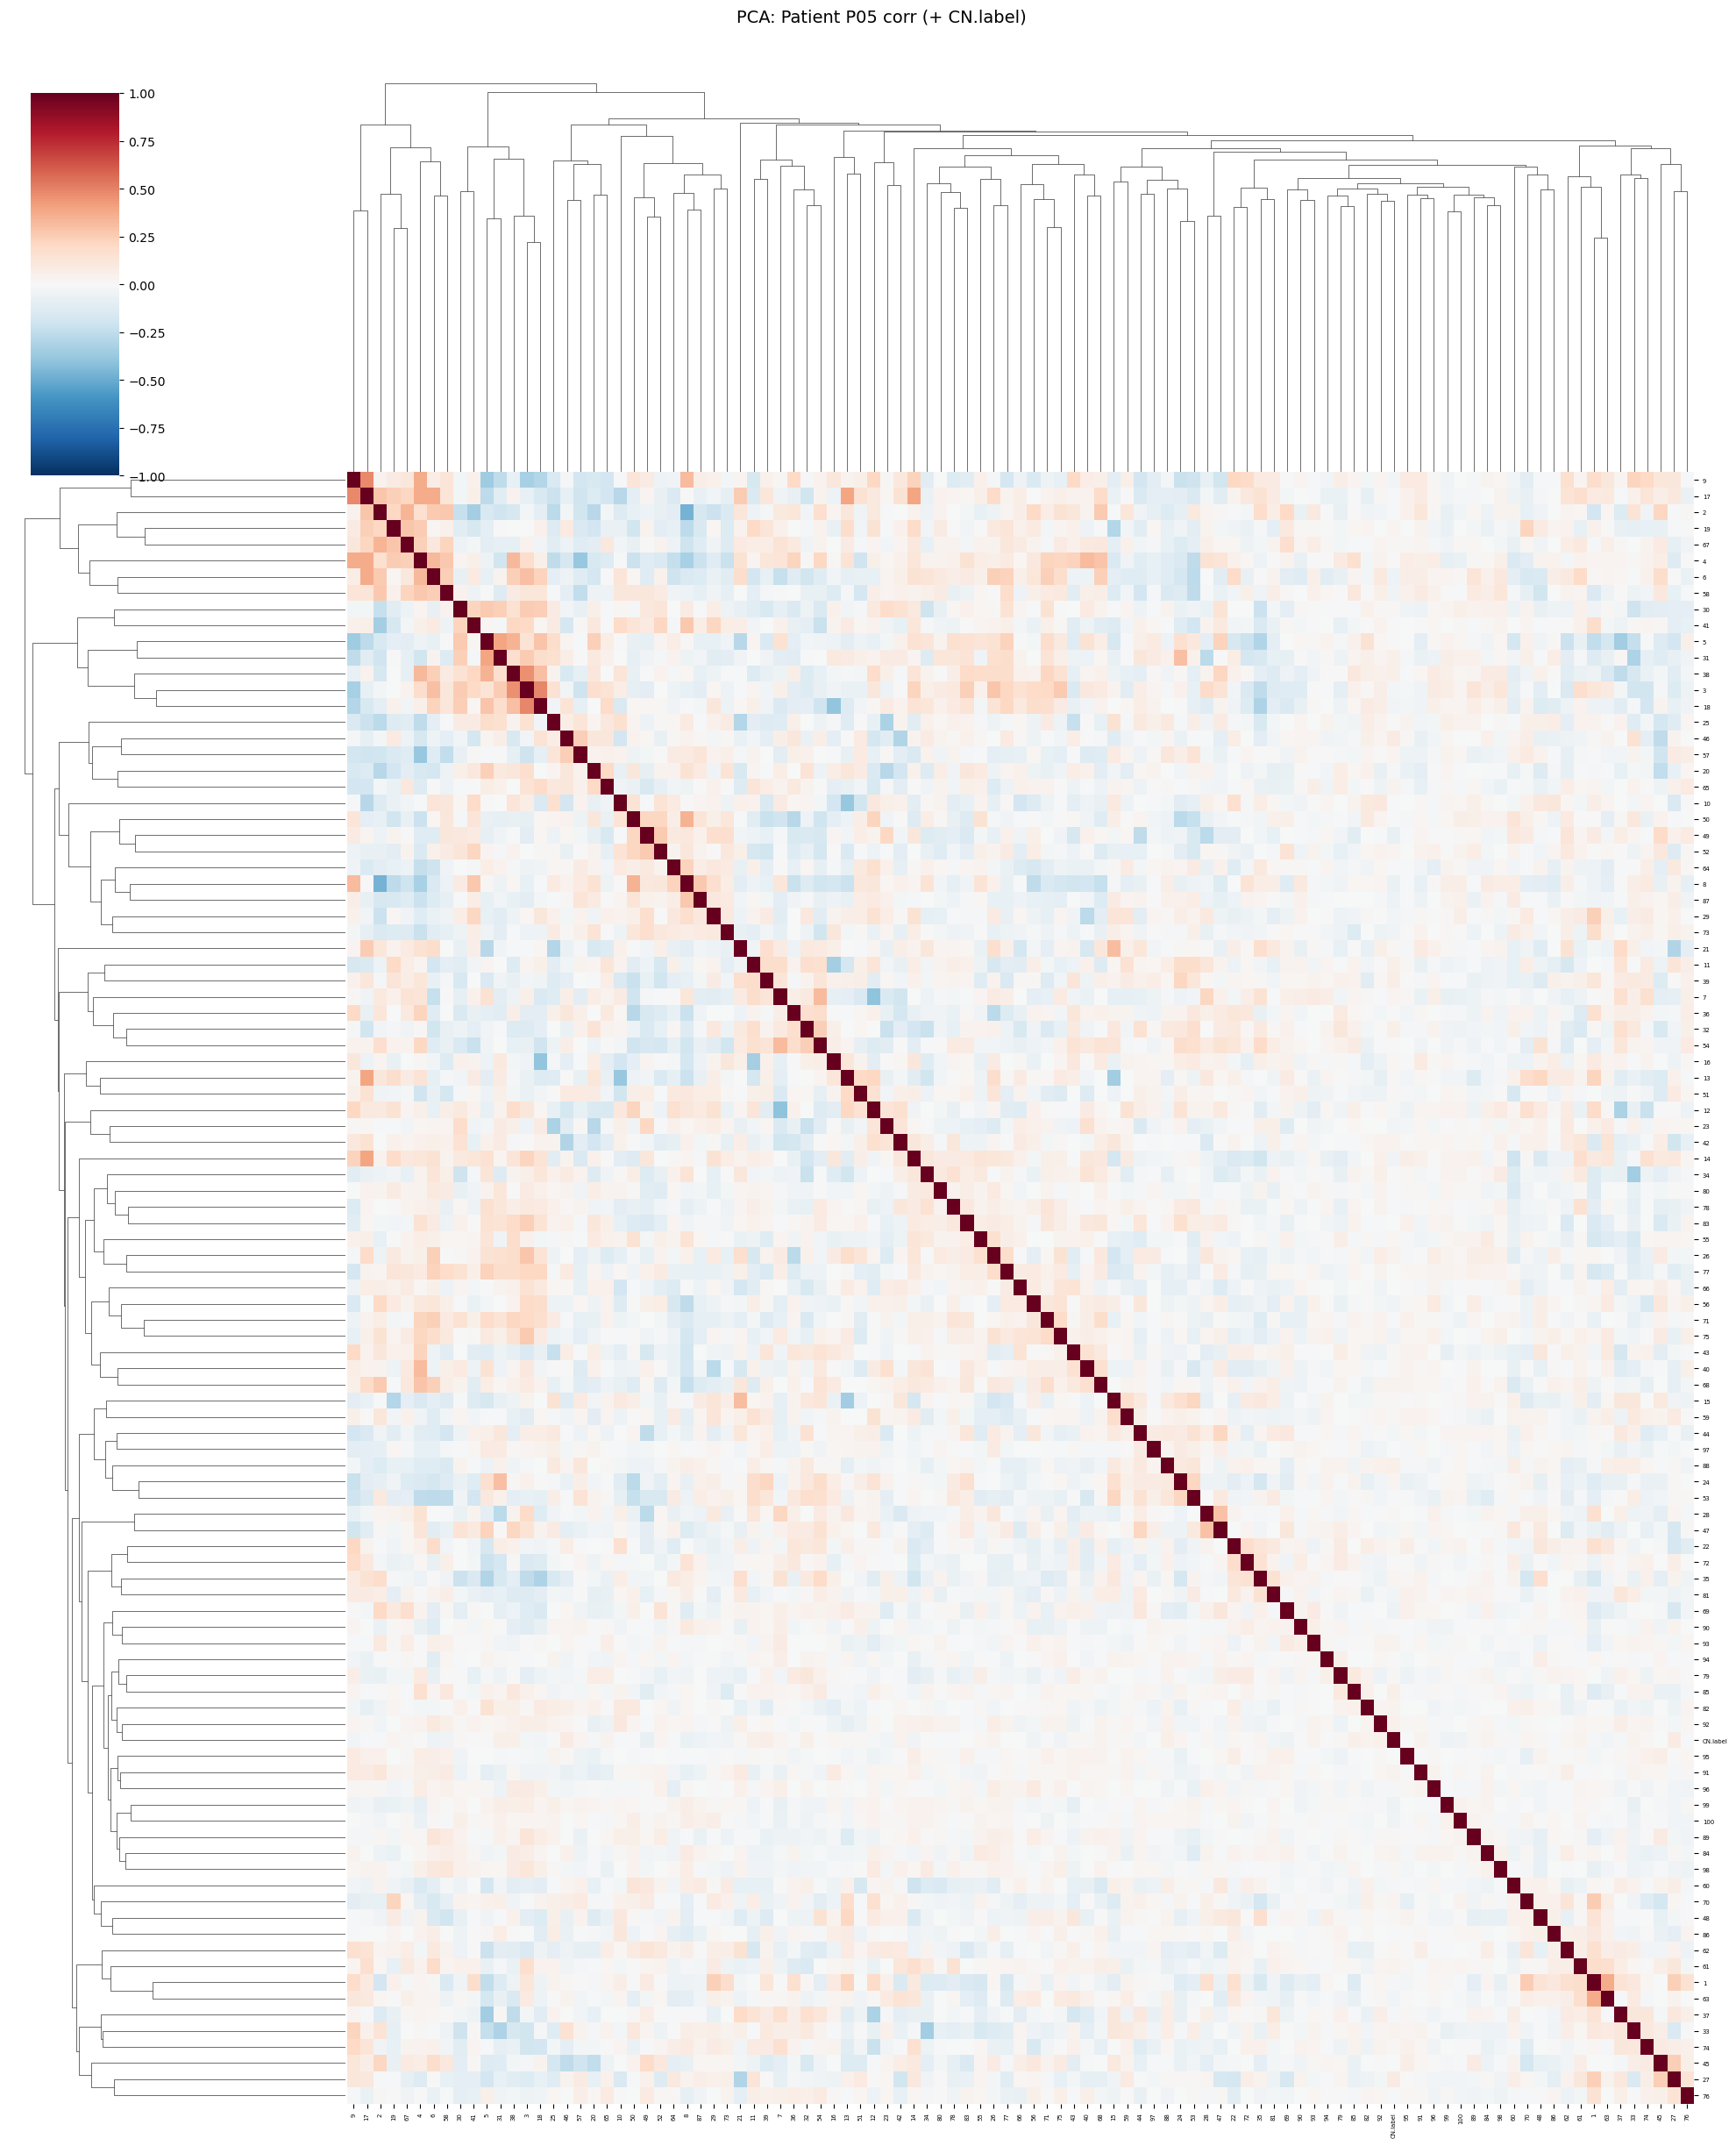

/home/minhang/miniconda3/envs/sc-factosig-gpu/lib/python3.10/site-packages/seaborn/matrix.py:560: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)
/home/minhang/miniconda3/envs/sc-factosig-gpu/lib/python3.10/site-packages/seaborn/matrix.py:560: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)


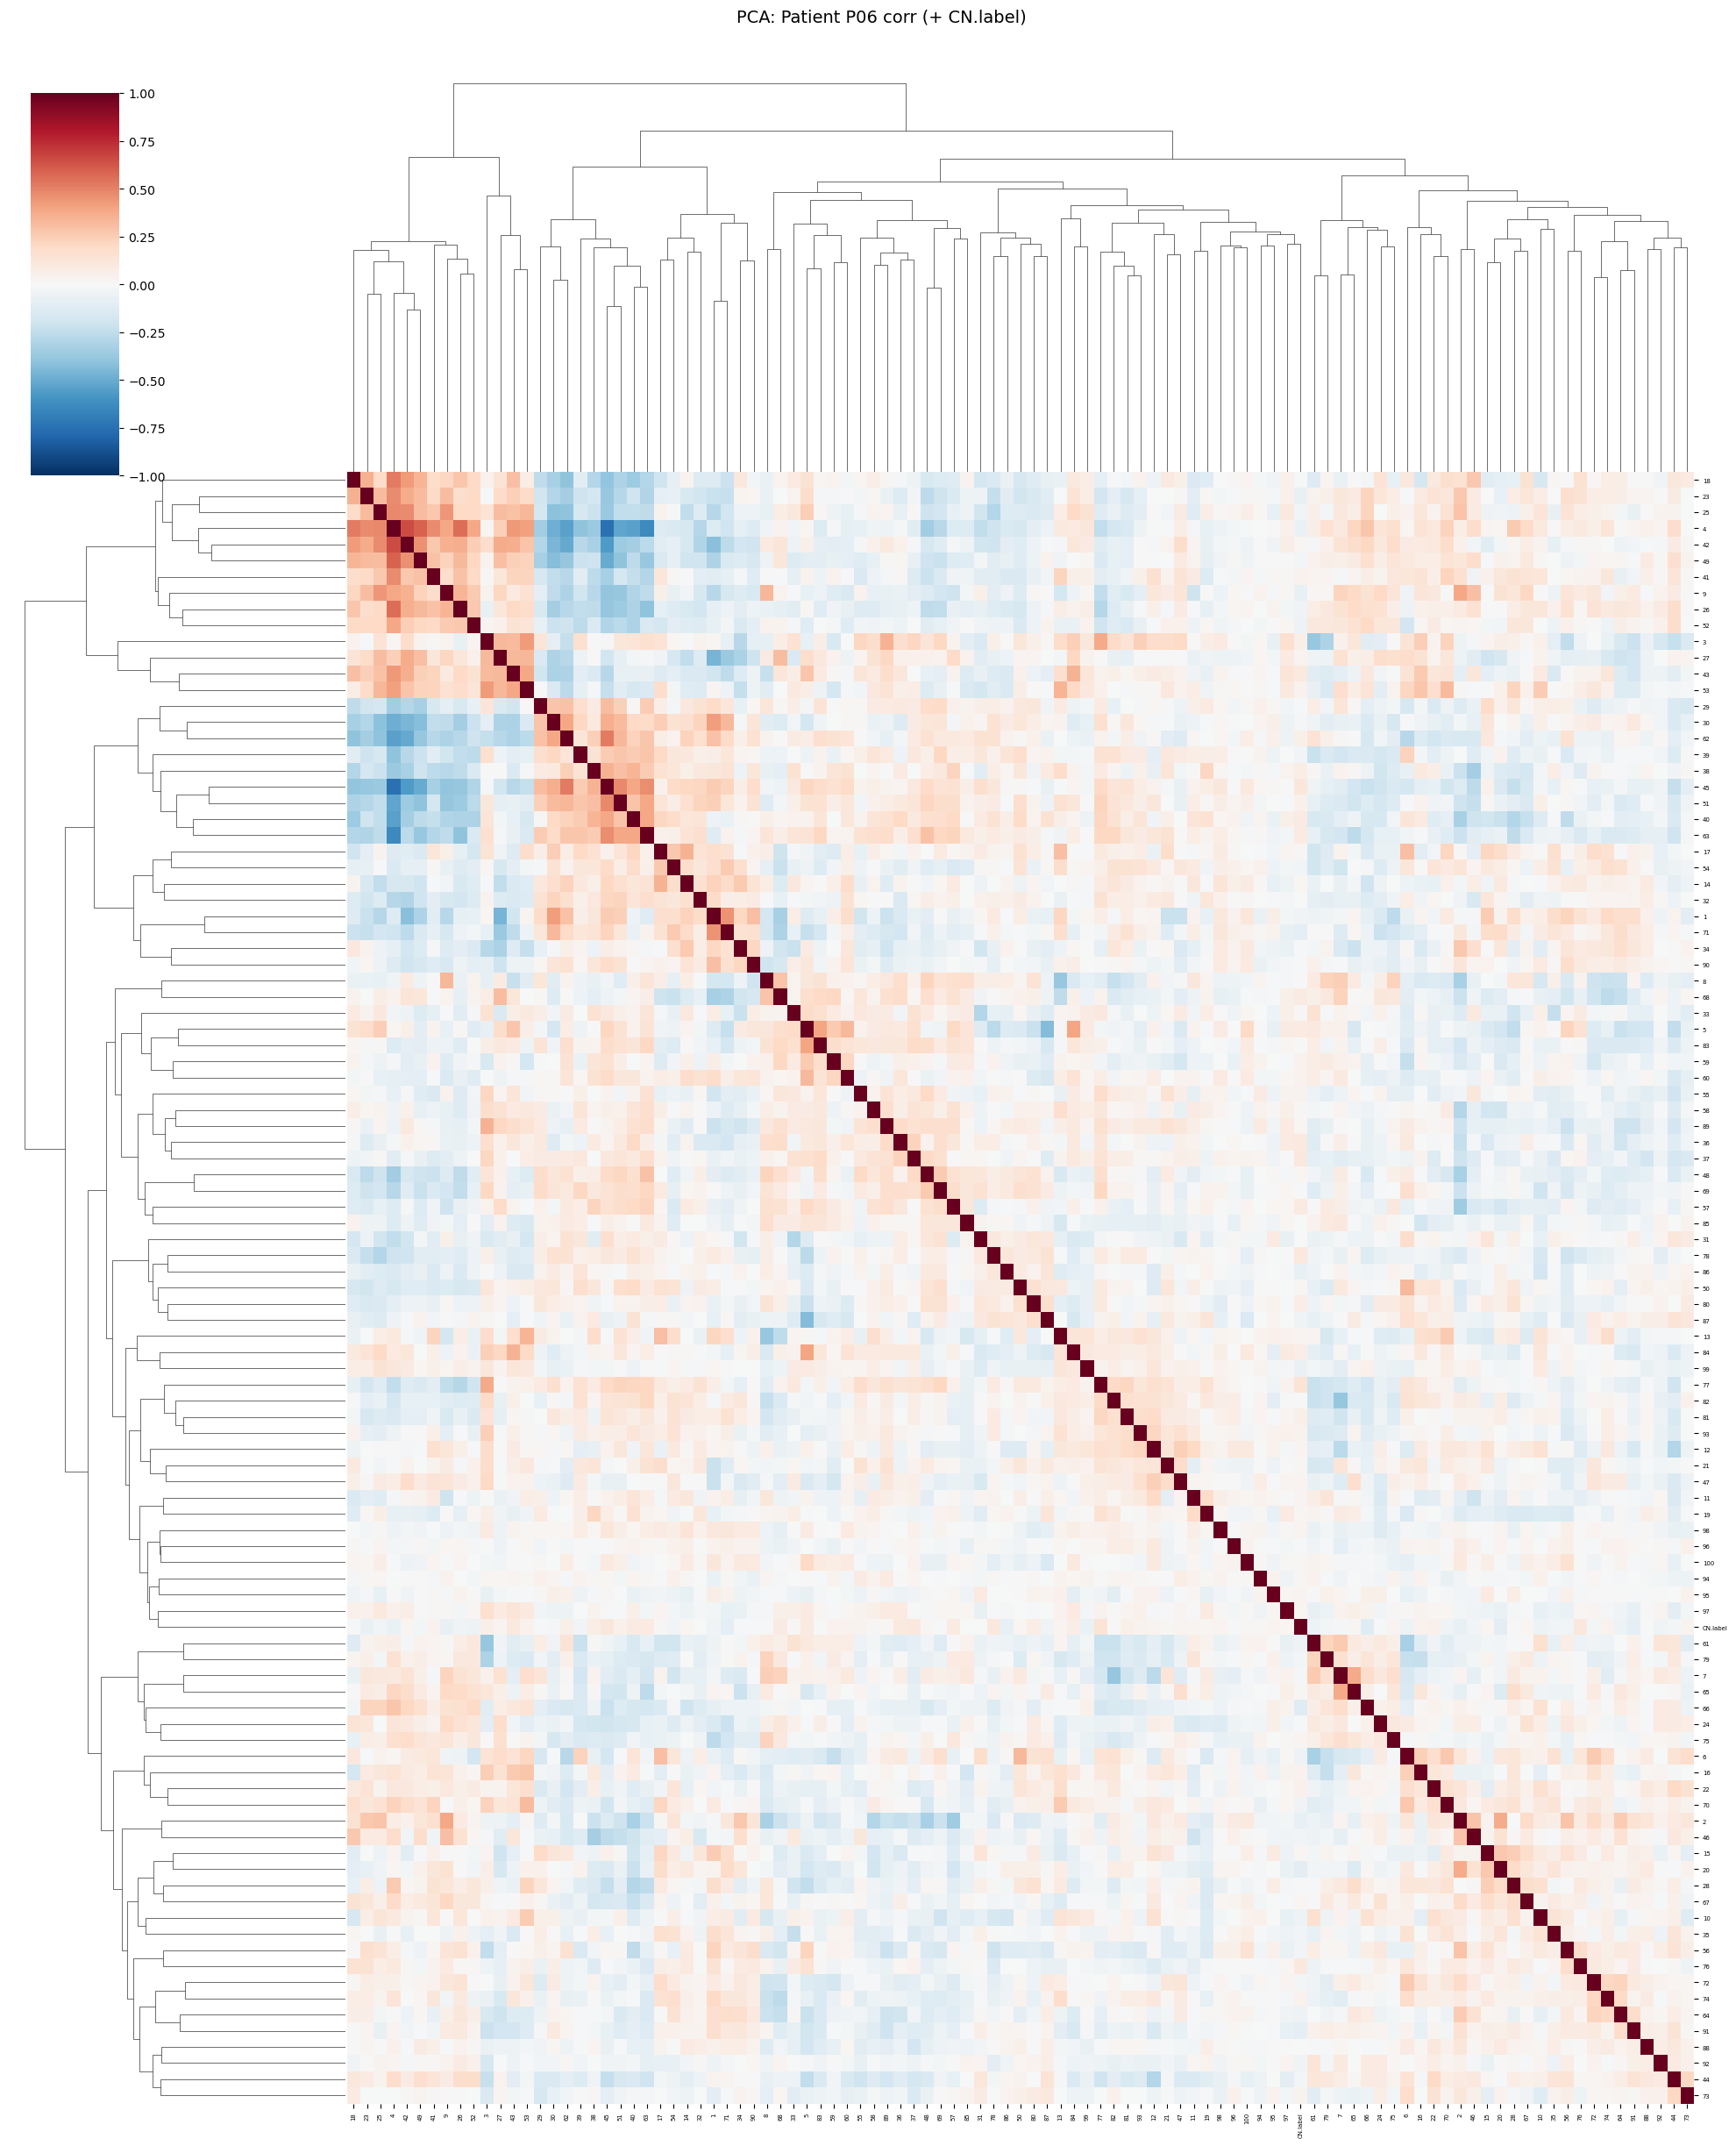

/home/minhang/miniconda3/envs/sc-factosig-gpu/lib/python3.10/site-packages/seaborn/matrix.py:560: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)
/home/minhang/miniconda3/envs/sc-factosig-gpu/lib/python3.10/site-packages/seaborn/matrix.py:560: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)


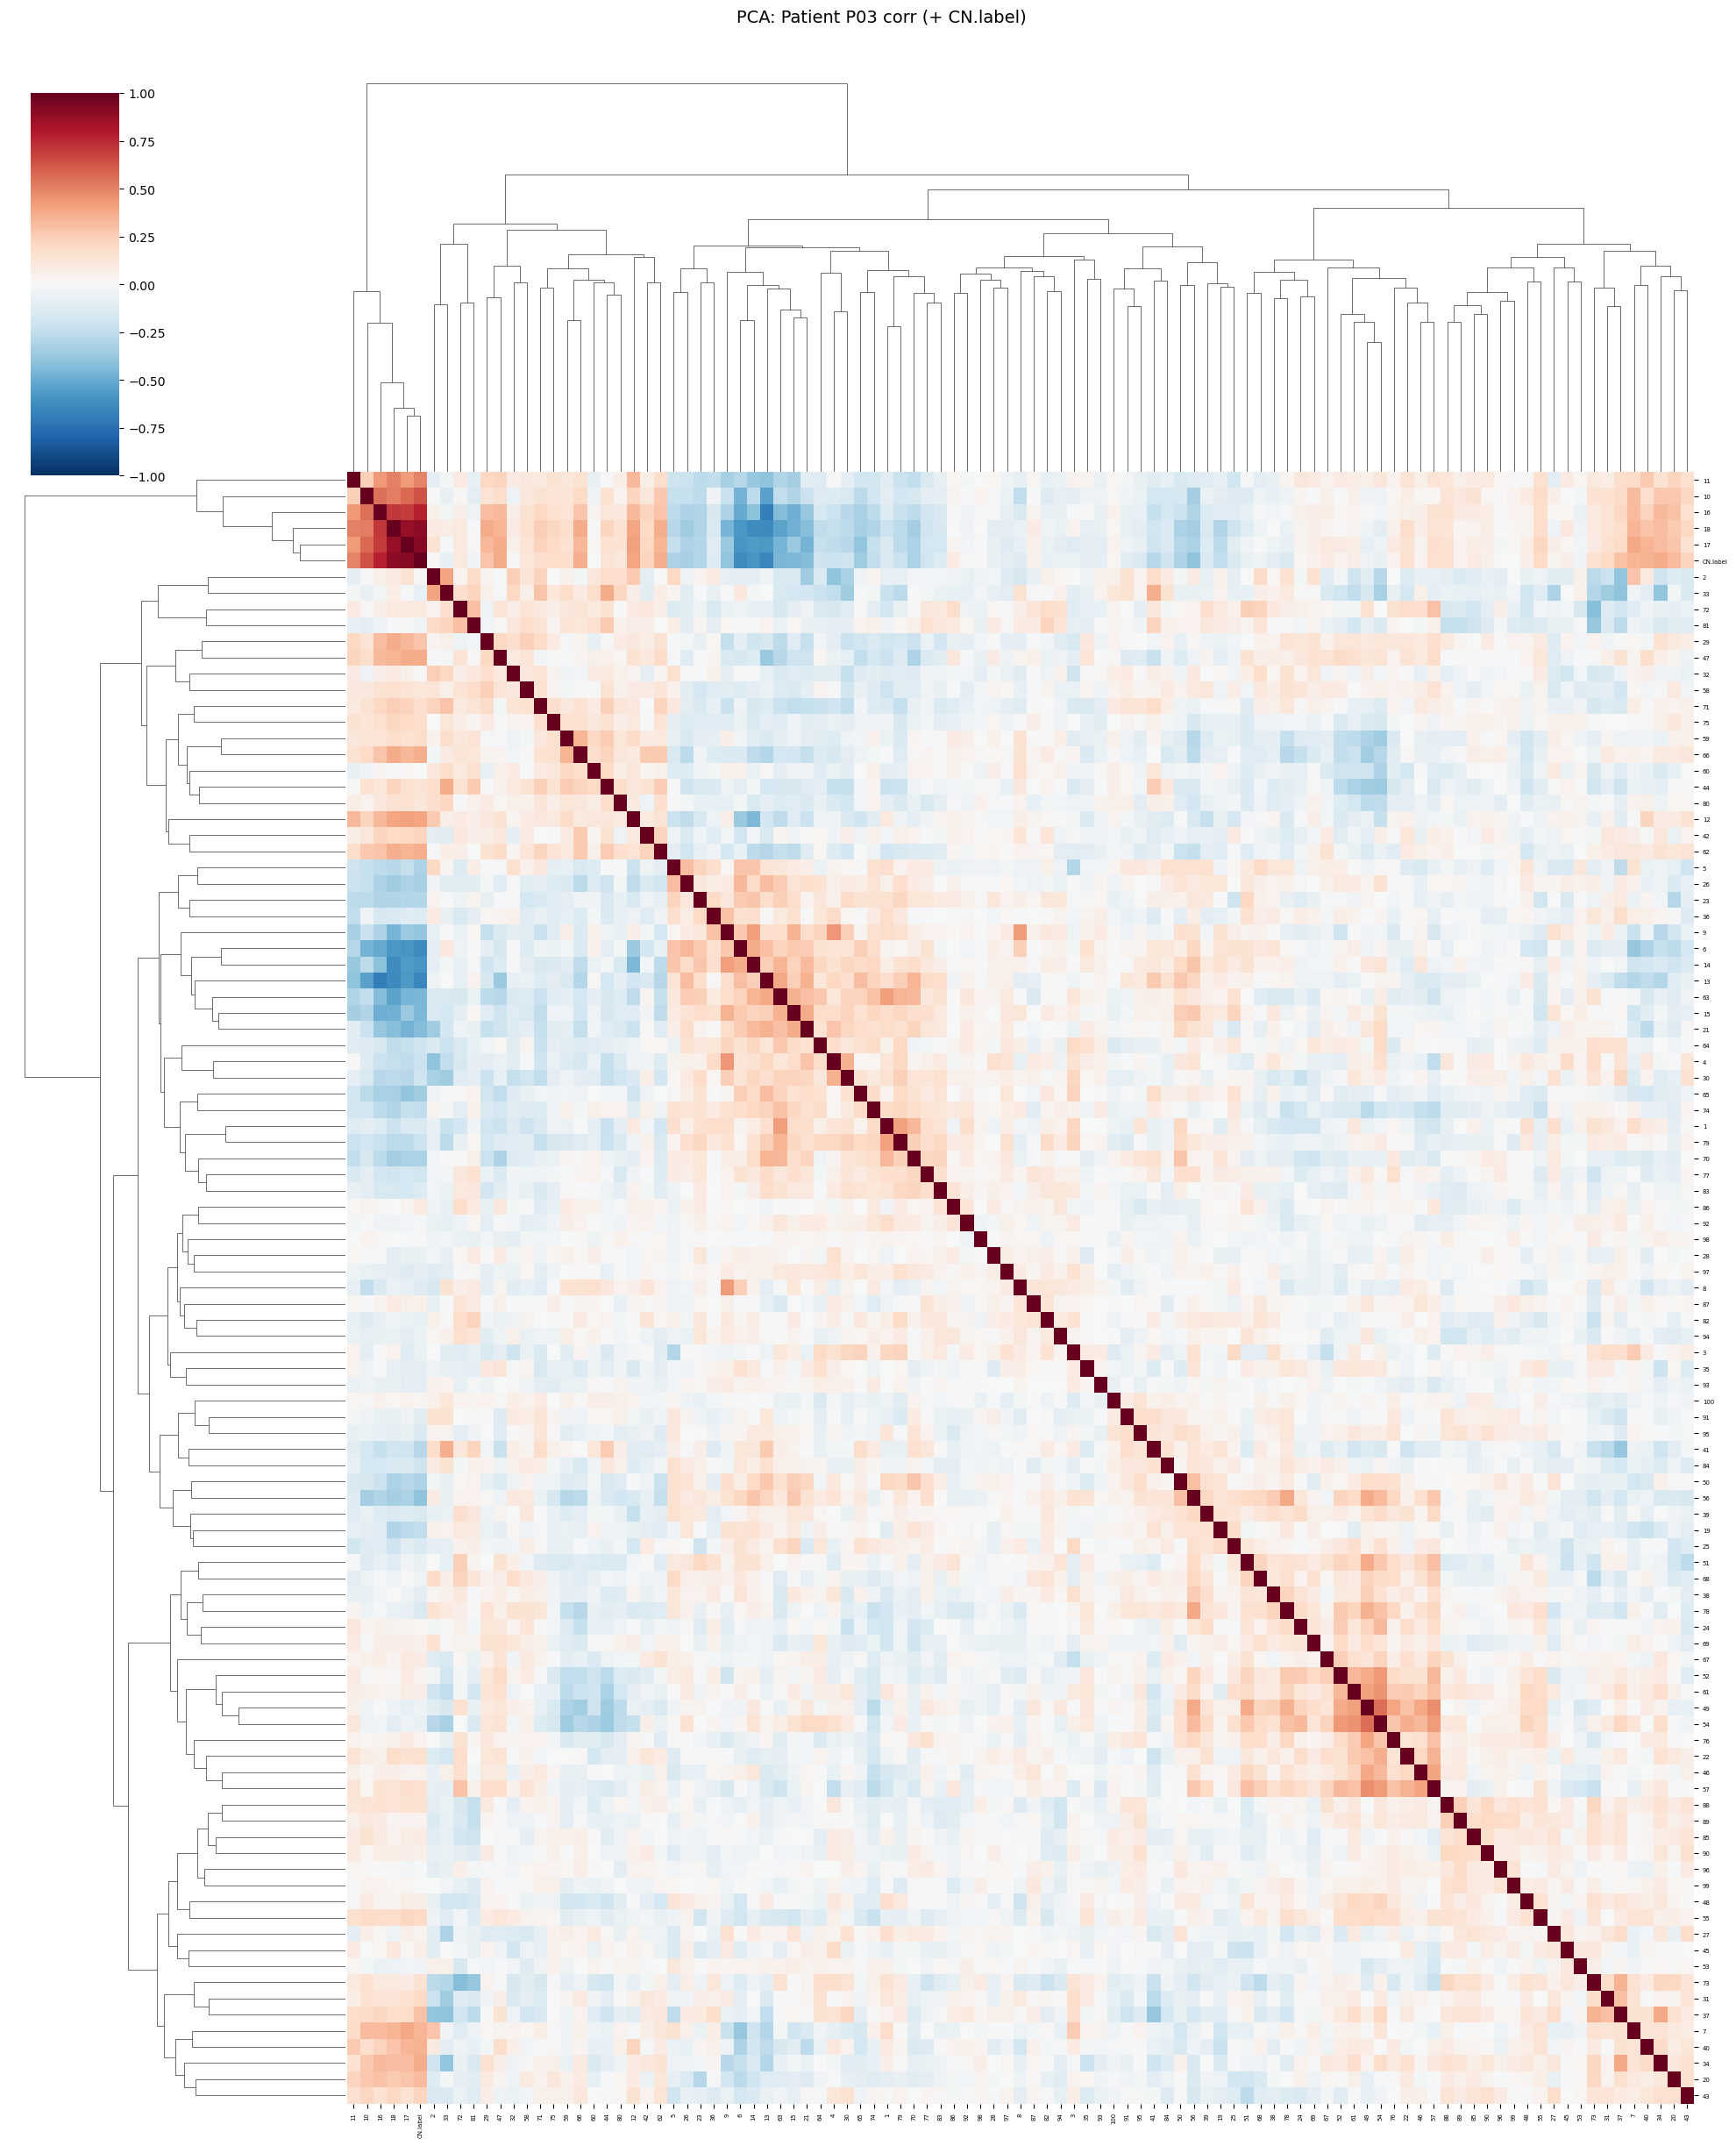

/home/minhang/miniconda3/envs/sc-factosig-gpu/lib/python3.10/site-packages/seaborn/matrix.py:560: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)
/home/minhang/miniconda3/envs/sc-factosig-gpu/lib/python3.10/site-packages/seaborn/matrix.py:560: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)


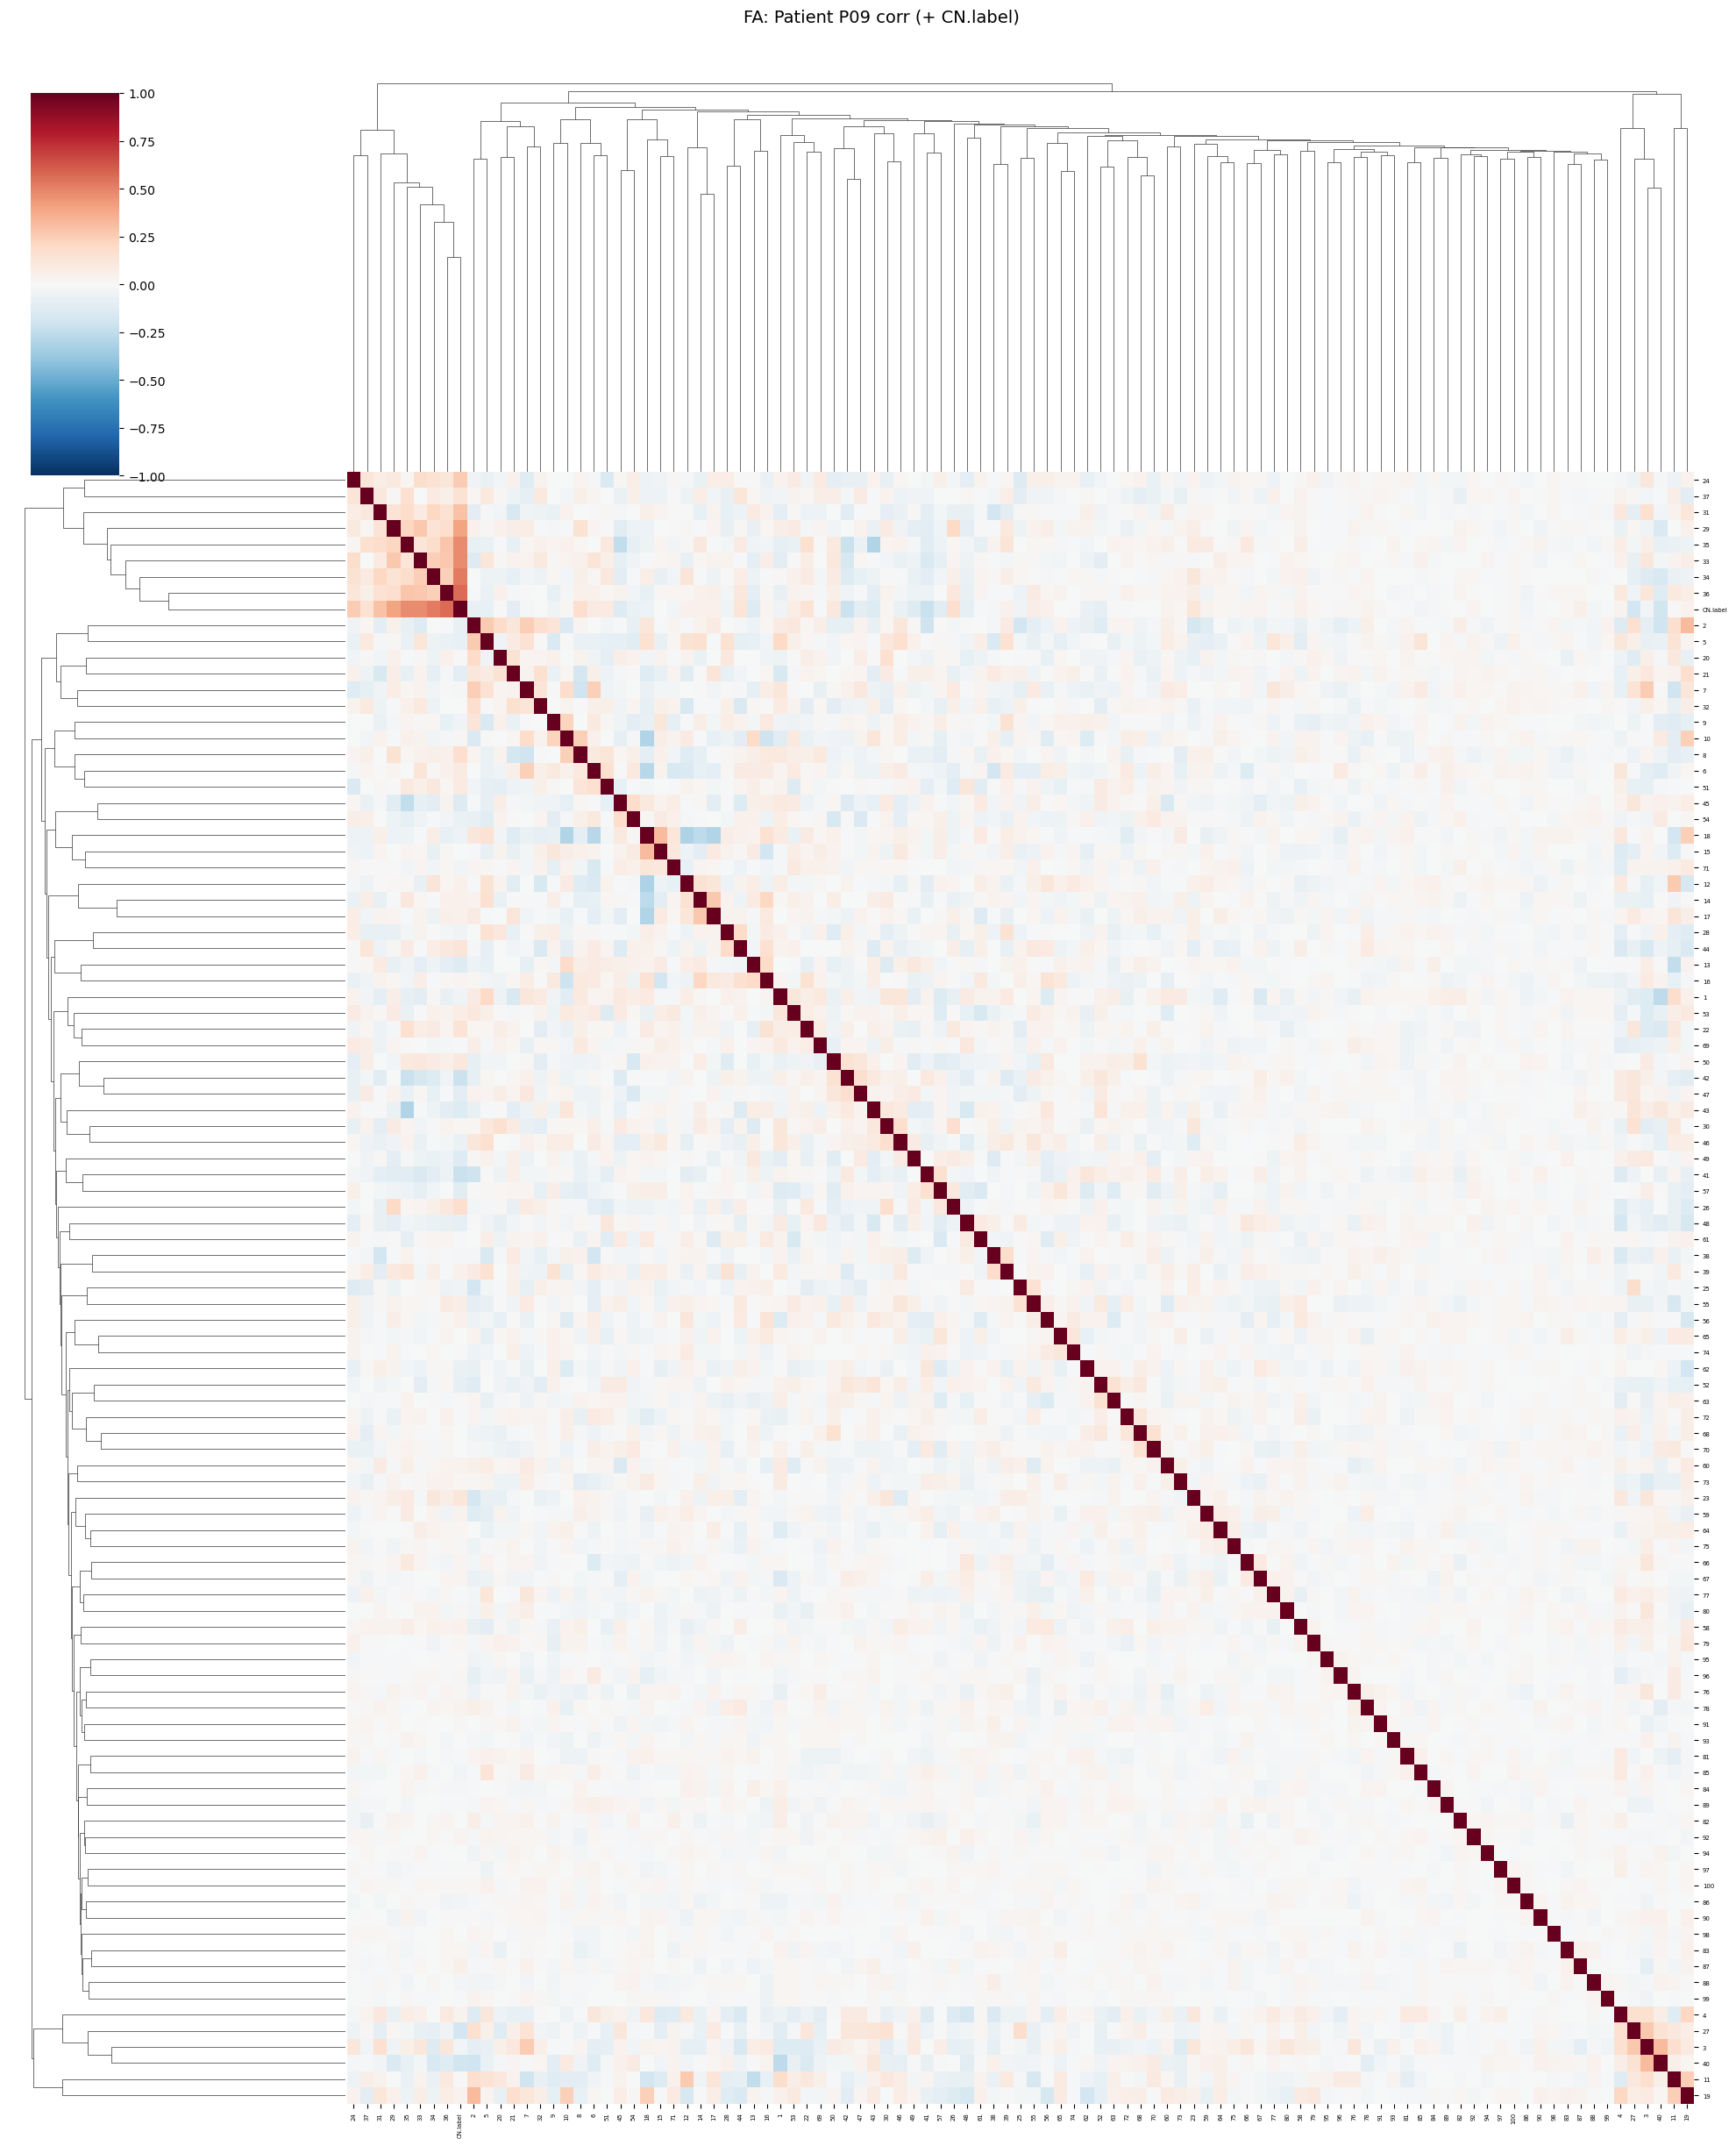

/home/minhang/miniconda3/envs/sc-factosig-gpu/lib/python3.10/site-packages/seaborn/matrix.py:560: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)
/home/minhang/miniconda3/envs/sc-factosig-gpu/lib/python3.10/site-packages/seaborn/matrix.py:560: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)


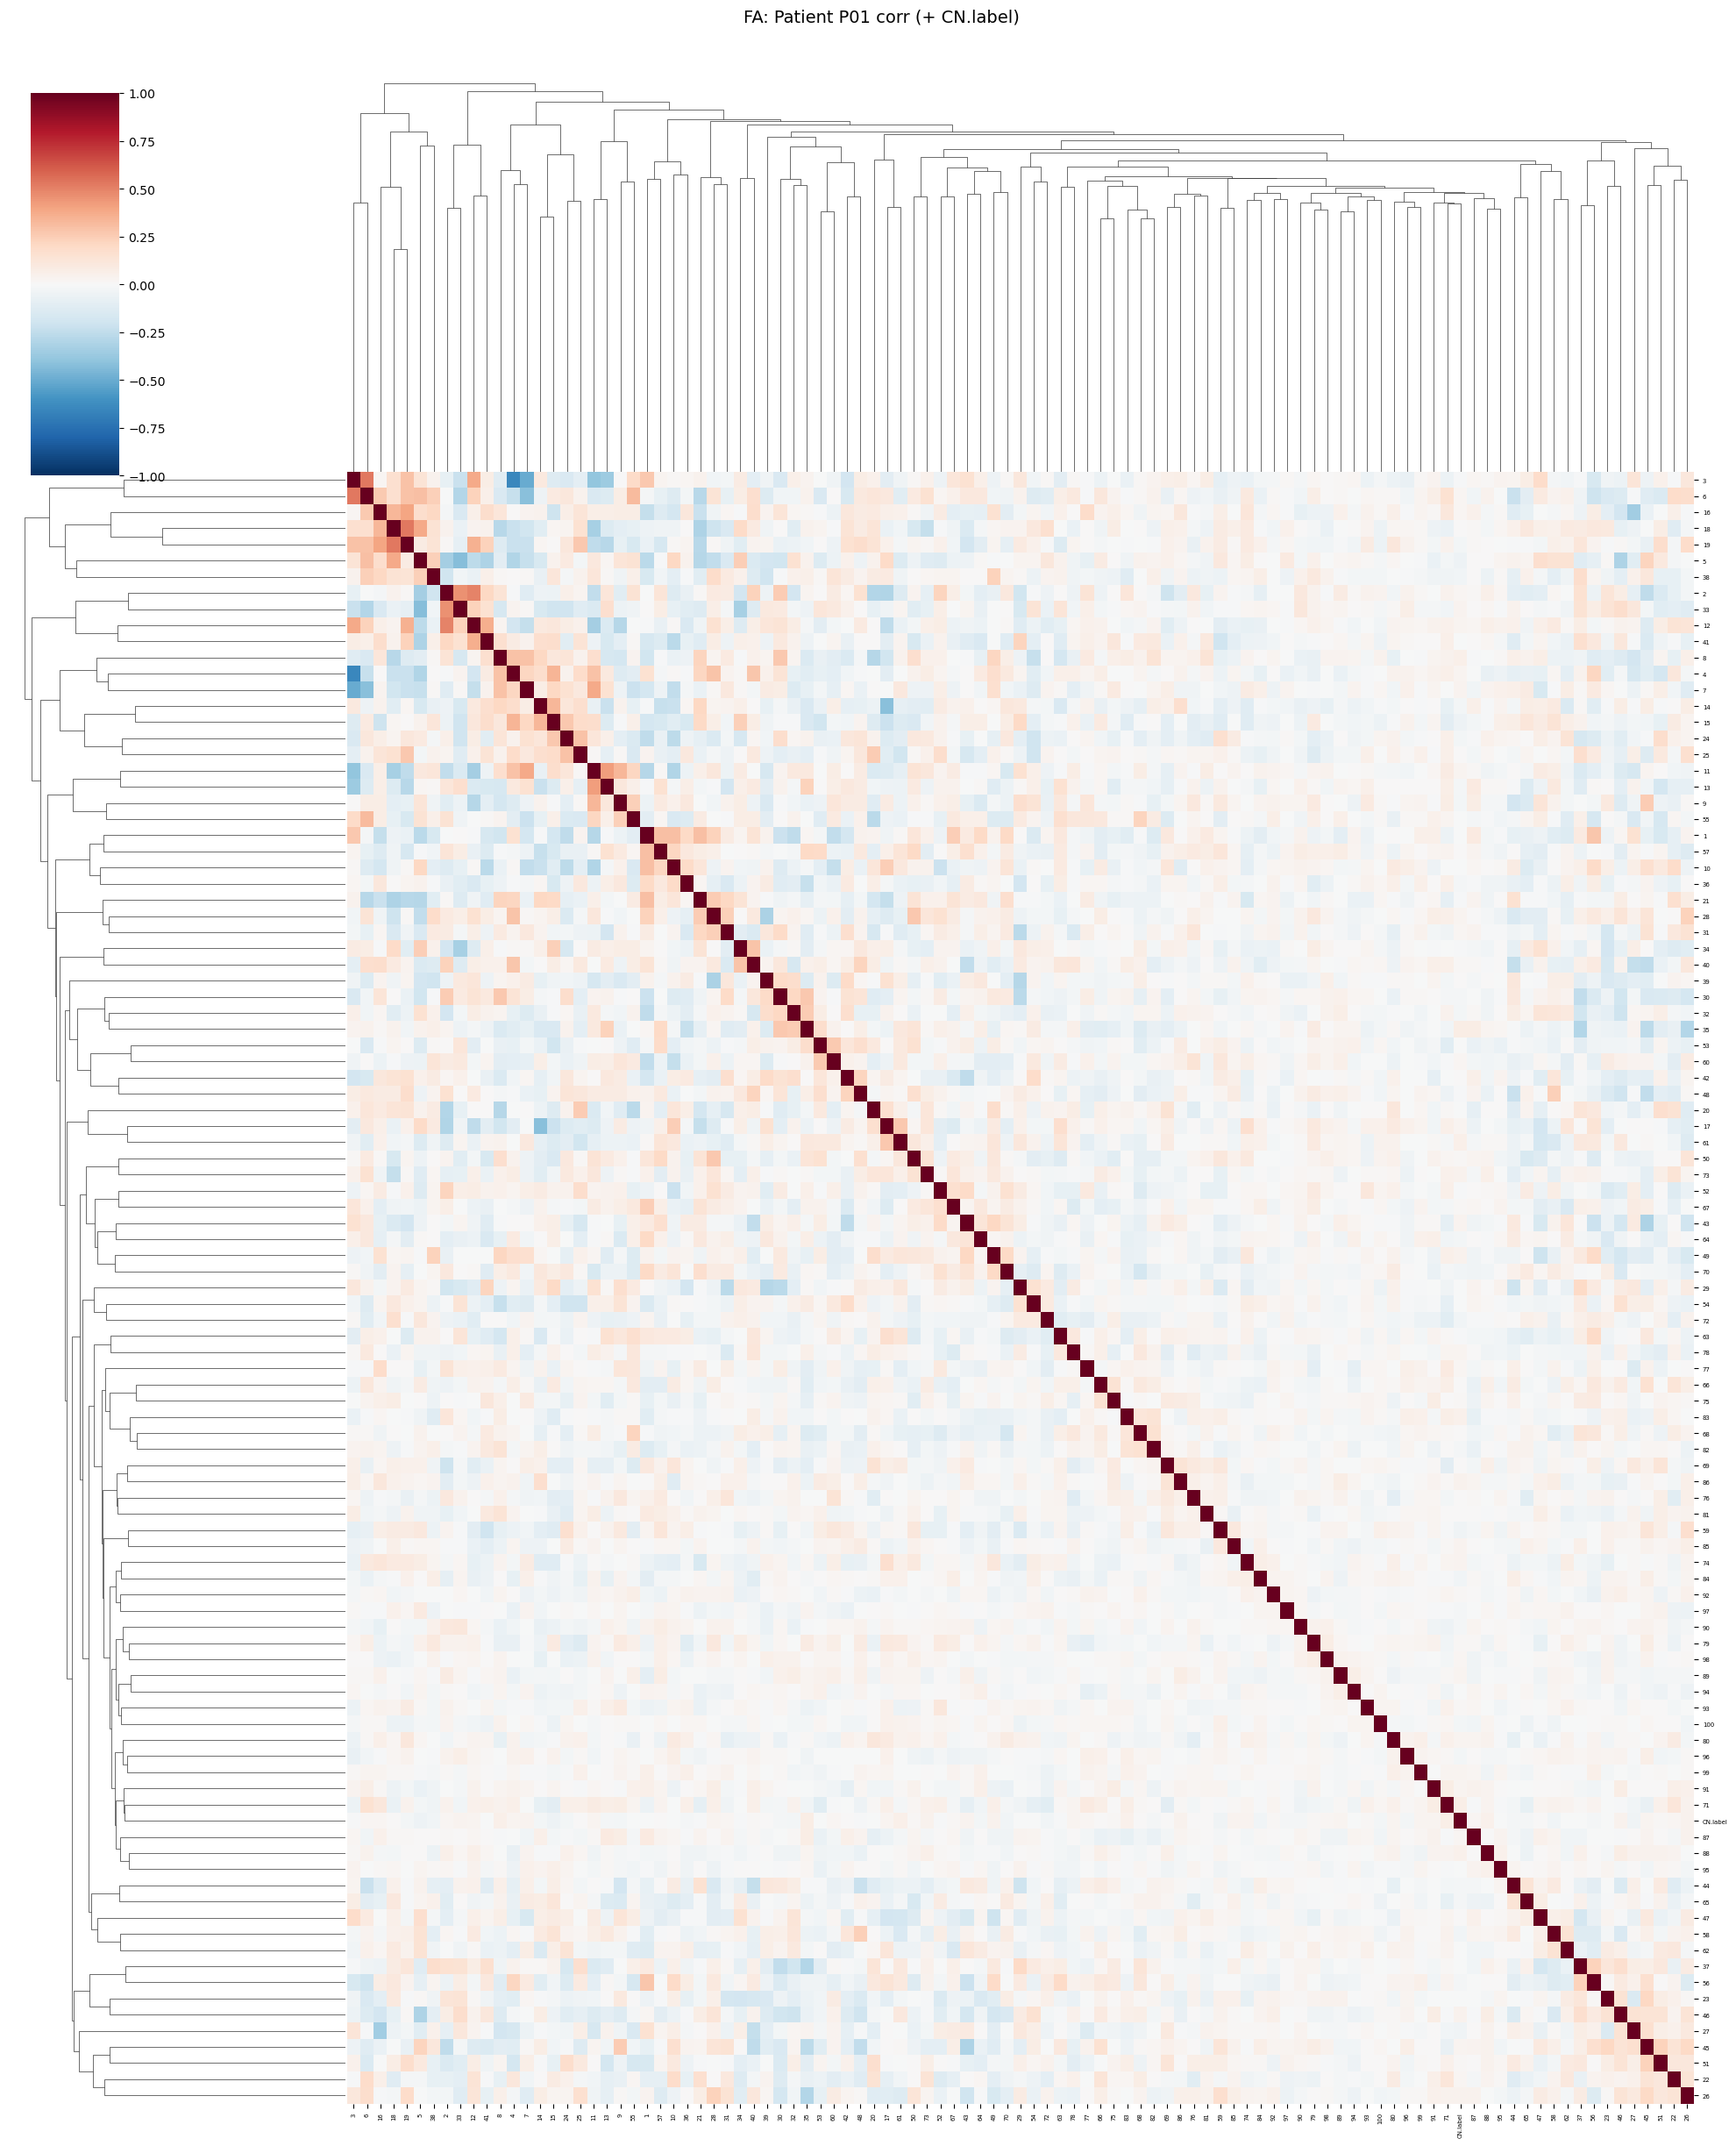

/home/minhang/miniconda3/envs/sc-factosig-gpu/lib/python3.10/site-packages/seaborn/matrix.py:560: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)
/home/minhang/miniconda3/envs/sc-factosig-gpu/lib/python3.10/site-packages/seaborn/matrix.py:560: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)


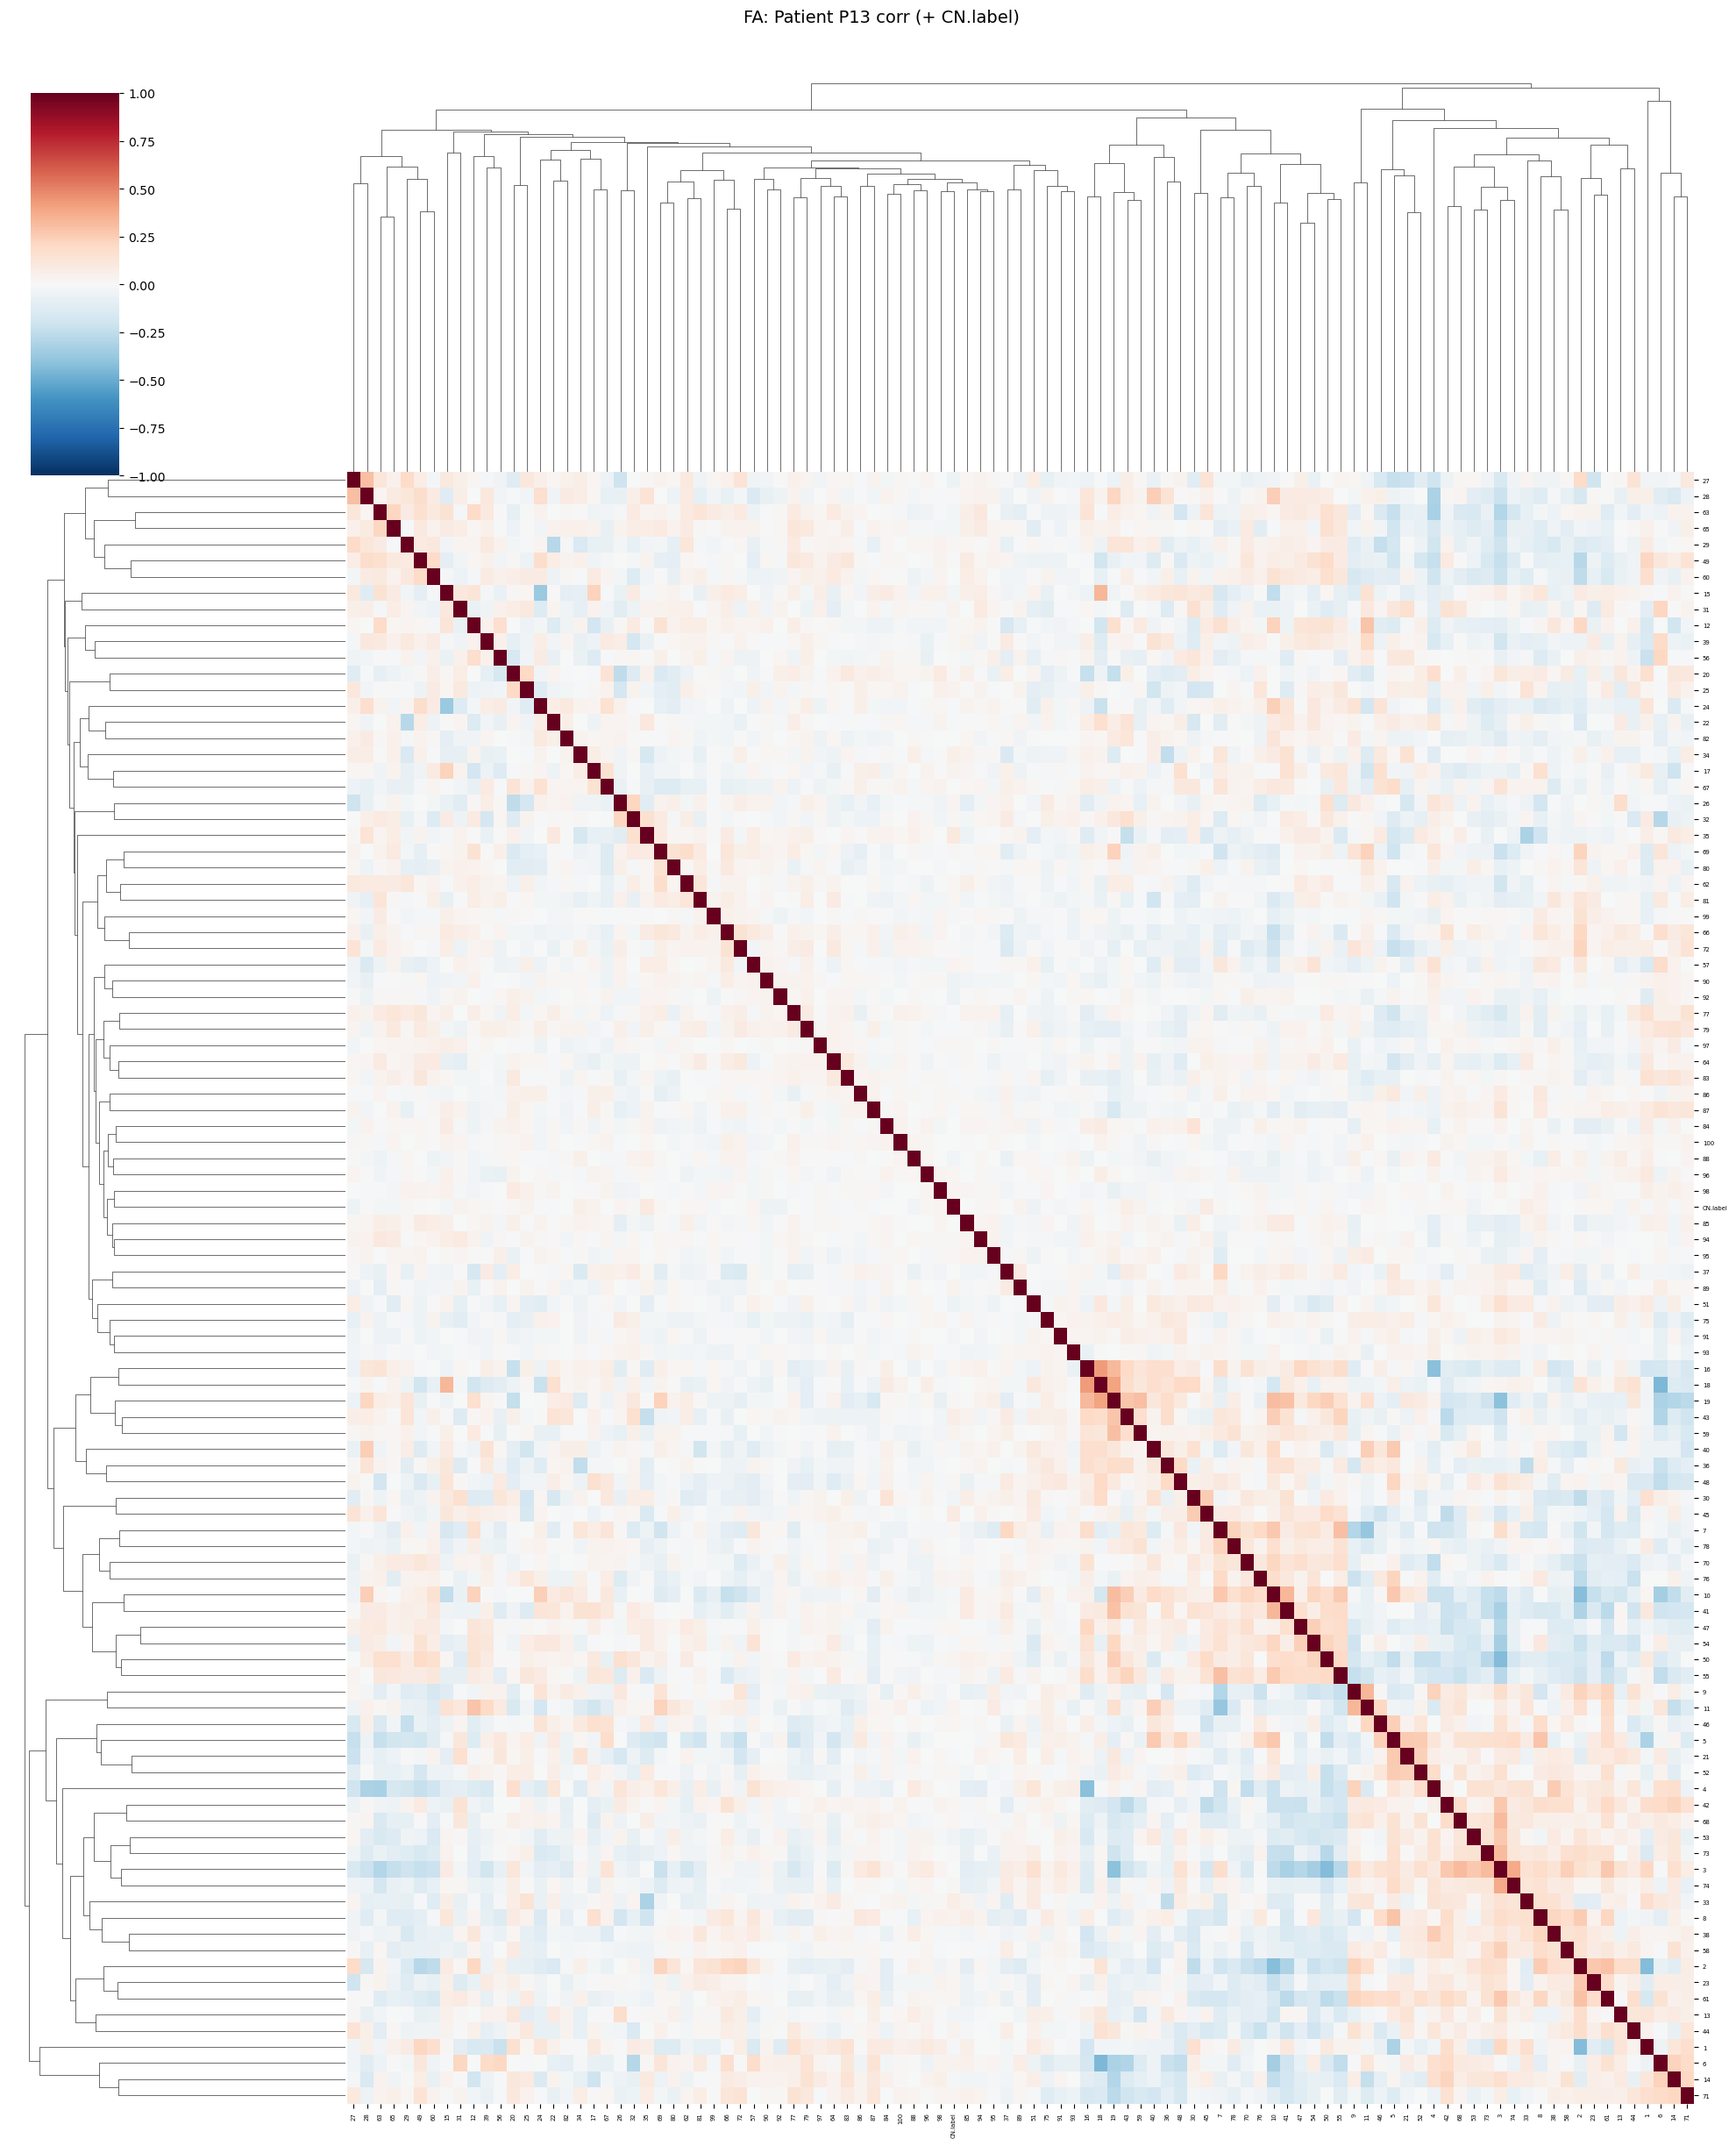

/home/minhang/miniconda3/envs/sc-factosig-gpu/lib/python3.10/site-packages/seaborn/matrix.py:560: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)
/home/minhang/miniconda3/envs/sc-factosig-gpu/lib/python3.10/site-packages/seaborn/matrix.py:560: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)


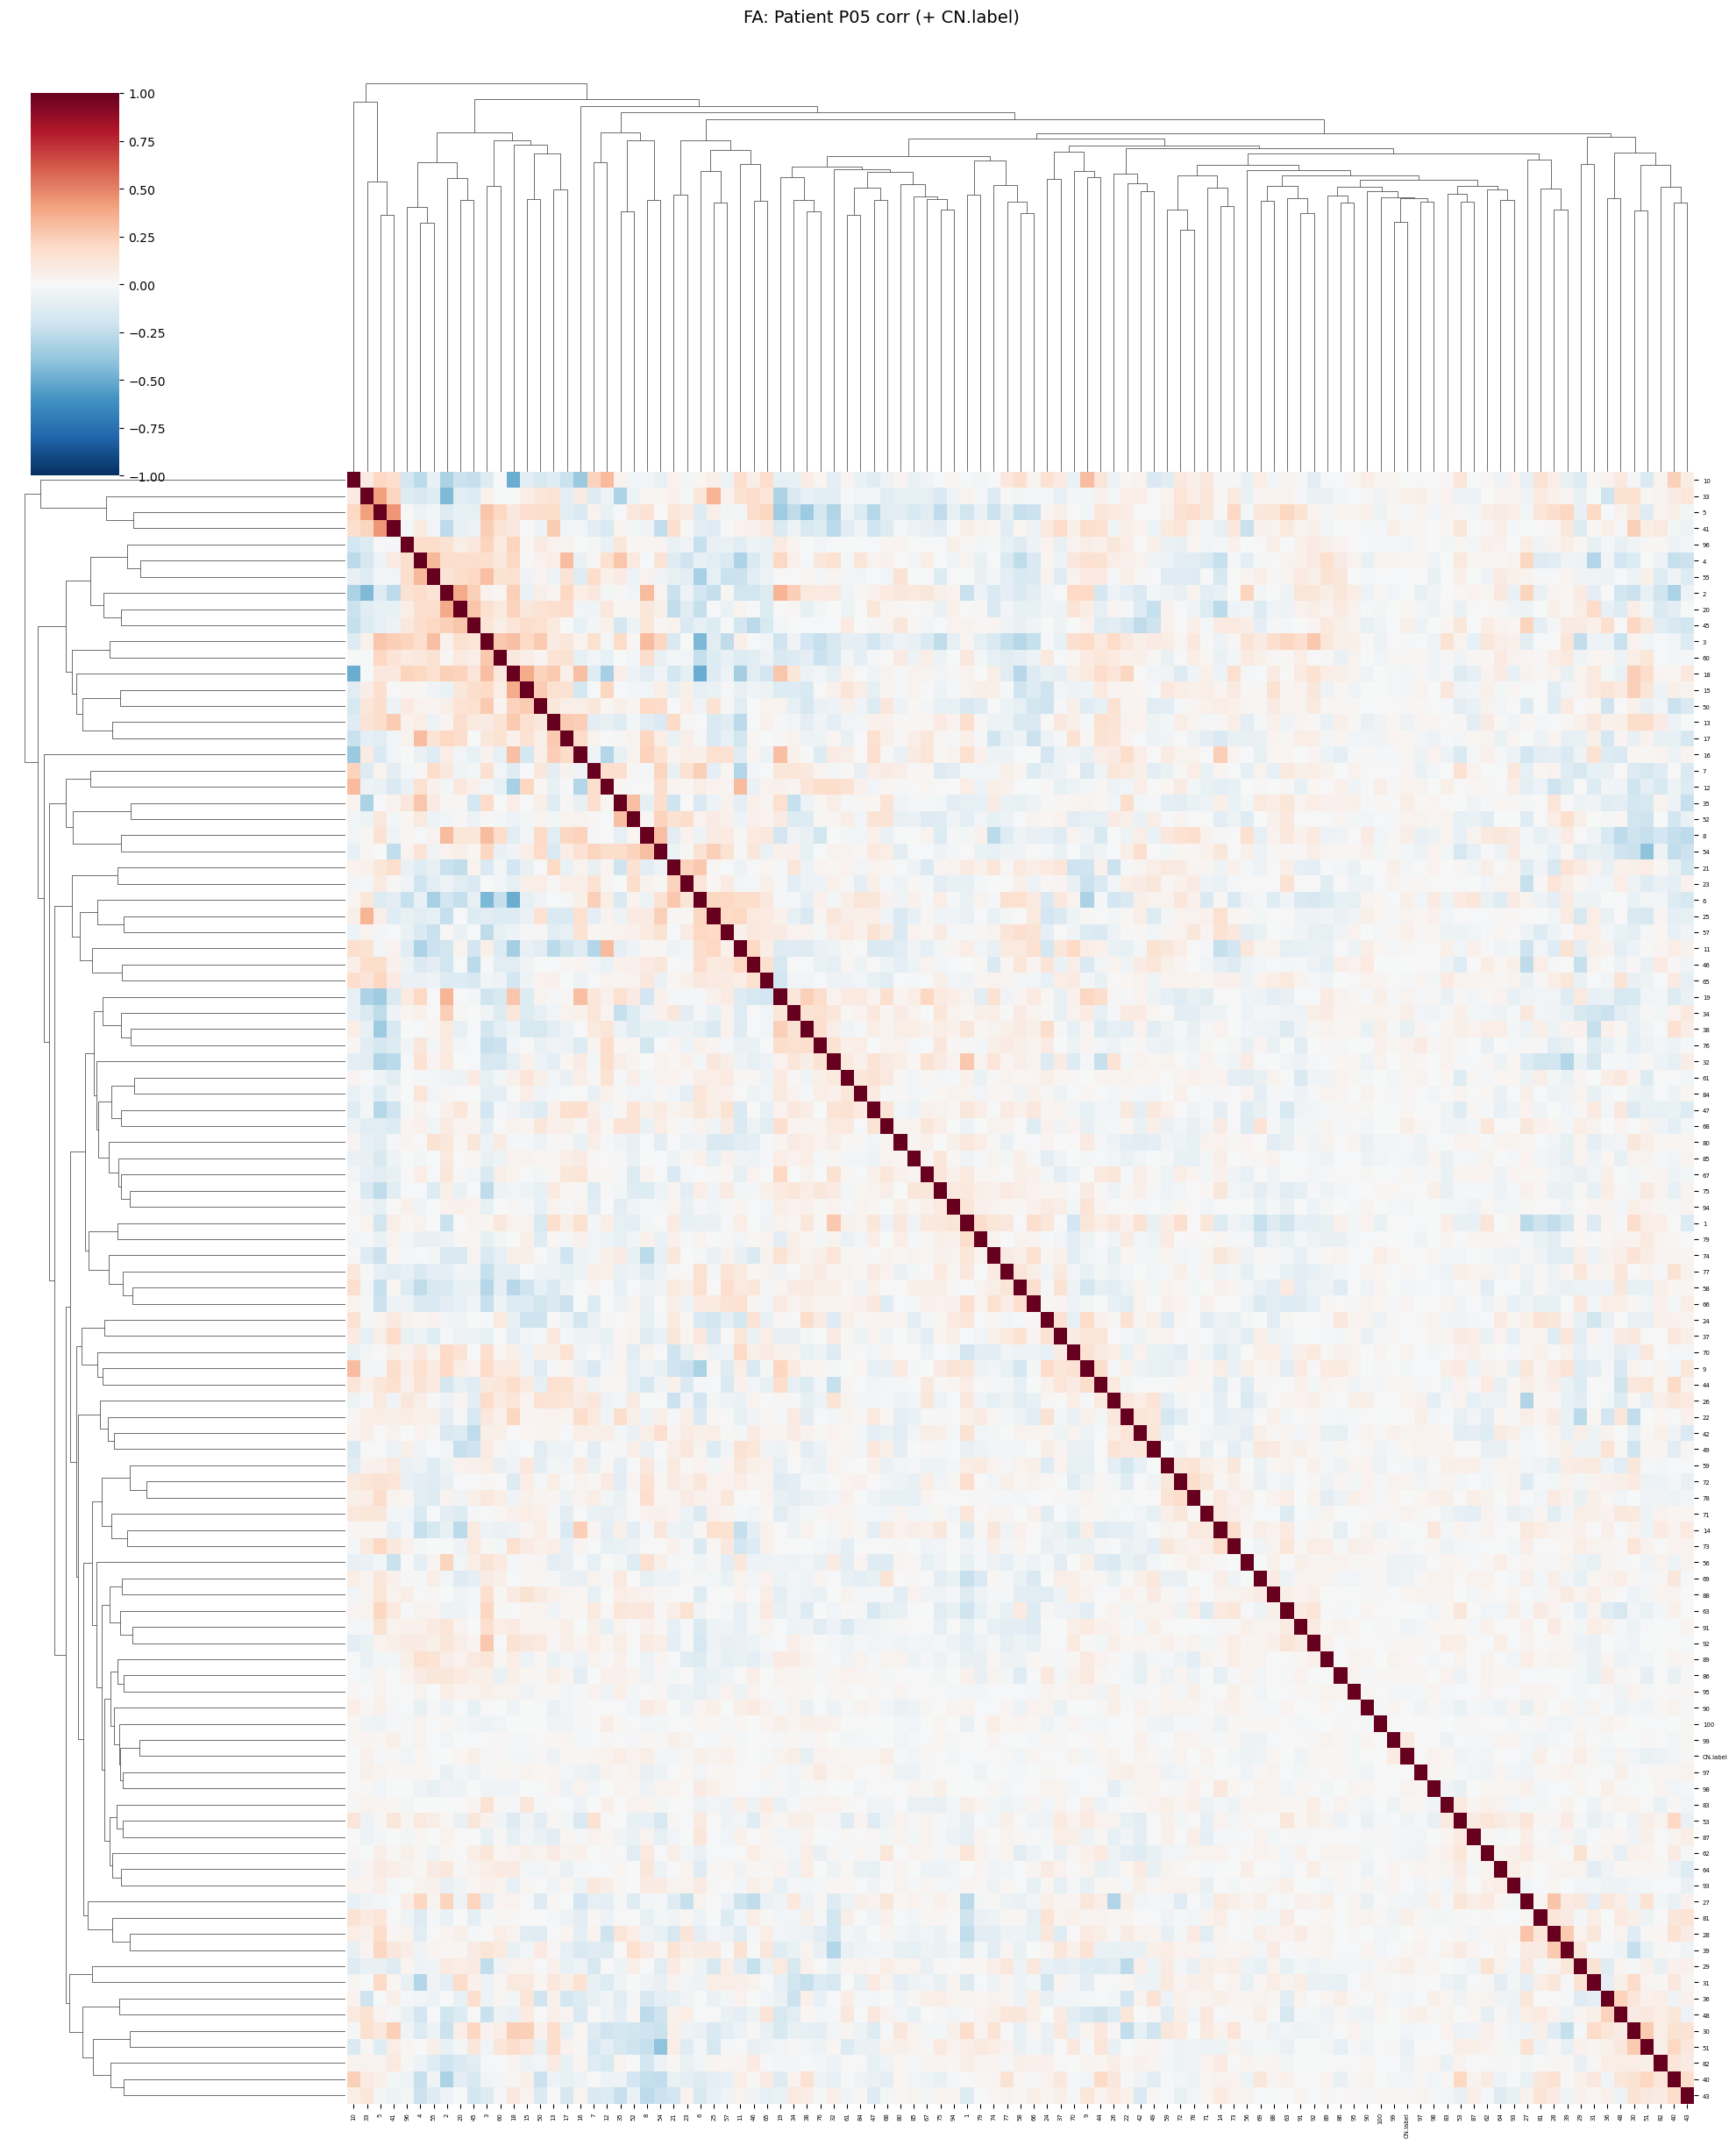

/home/minhang/miniconda3/envs/sc-factosig-gpu/lib/python3.10/site-packages/seaborn/matrix.py:560: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)
/home/minhang/miniconda3/envs/sc-factosig-gpu/lib/python3.10/site-packages/seaborn/matrix.py:560: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)


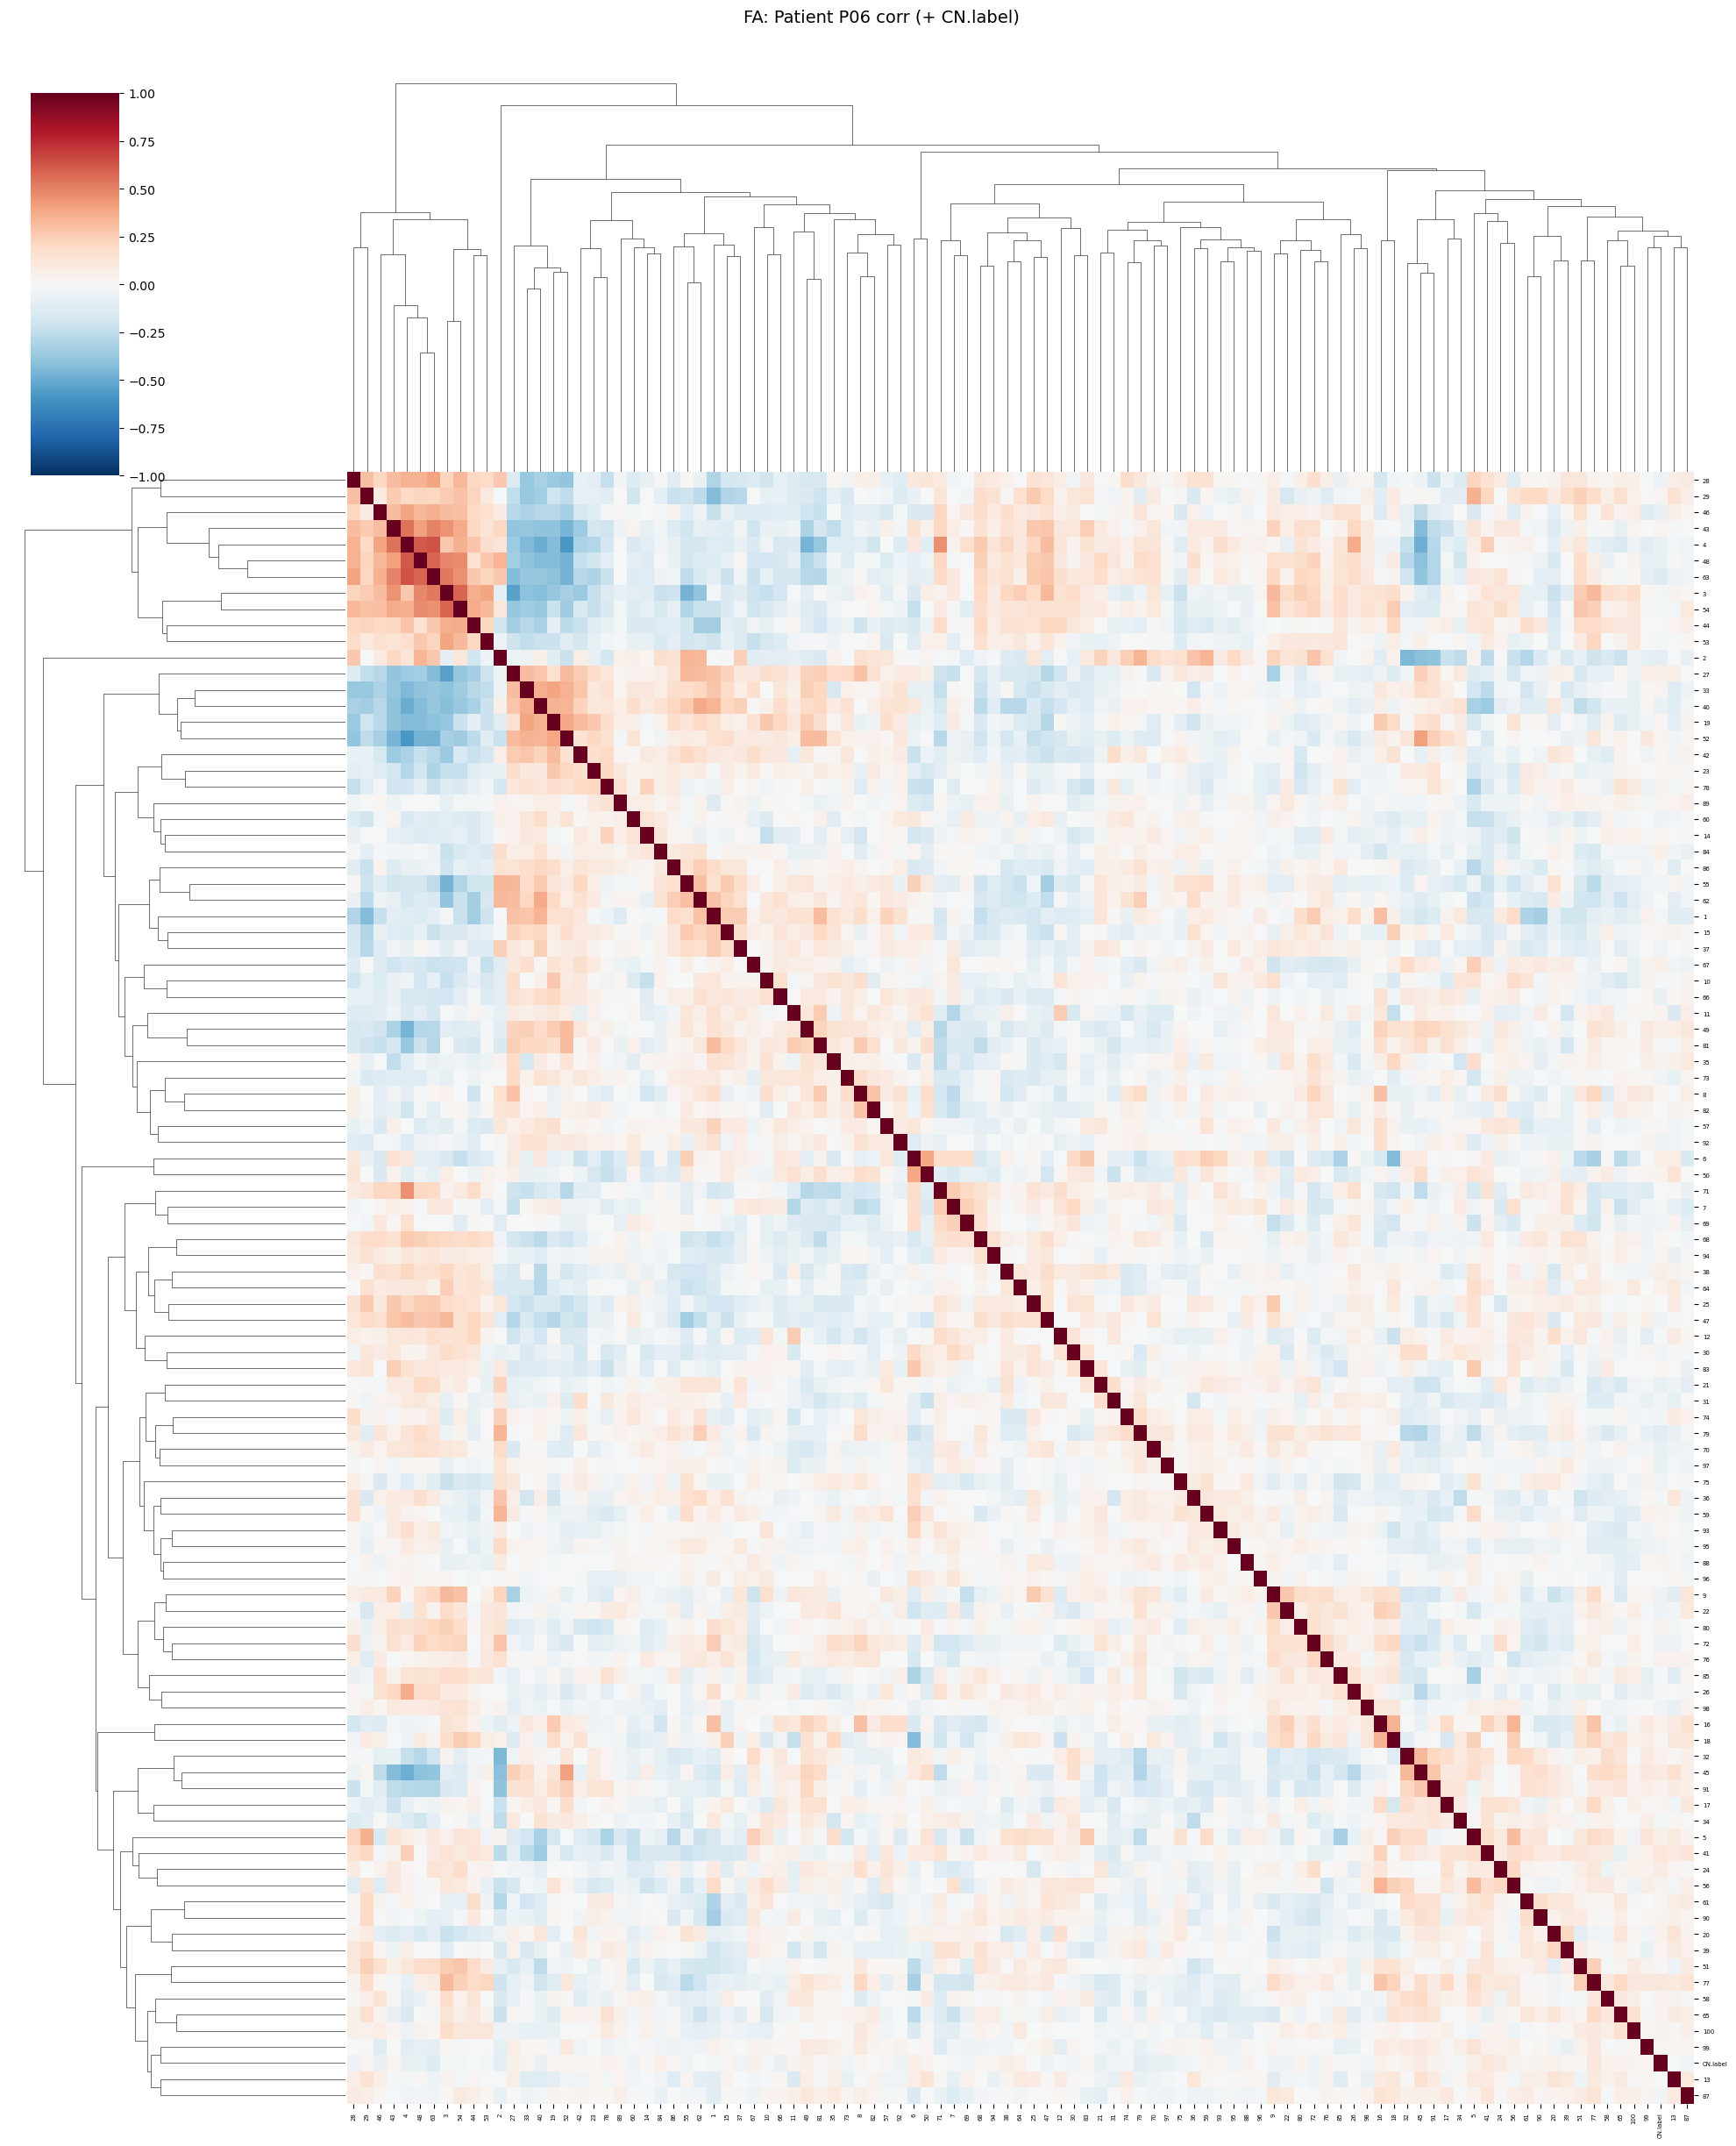

/home/minhang/miniconda3/envs/sc-factosig-gpu/lib/python3.10/site-packages/seaborn/matrix.py:560: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)
/home/minhang/miniconda3/envs/sc-factosig-gpu/lib/python3.10/site-packages/seaborn/matrix.py:560: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)


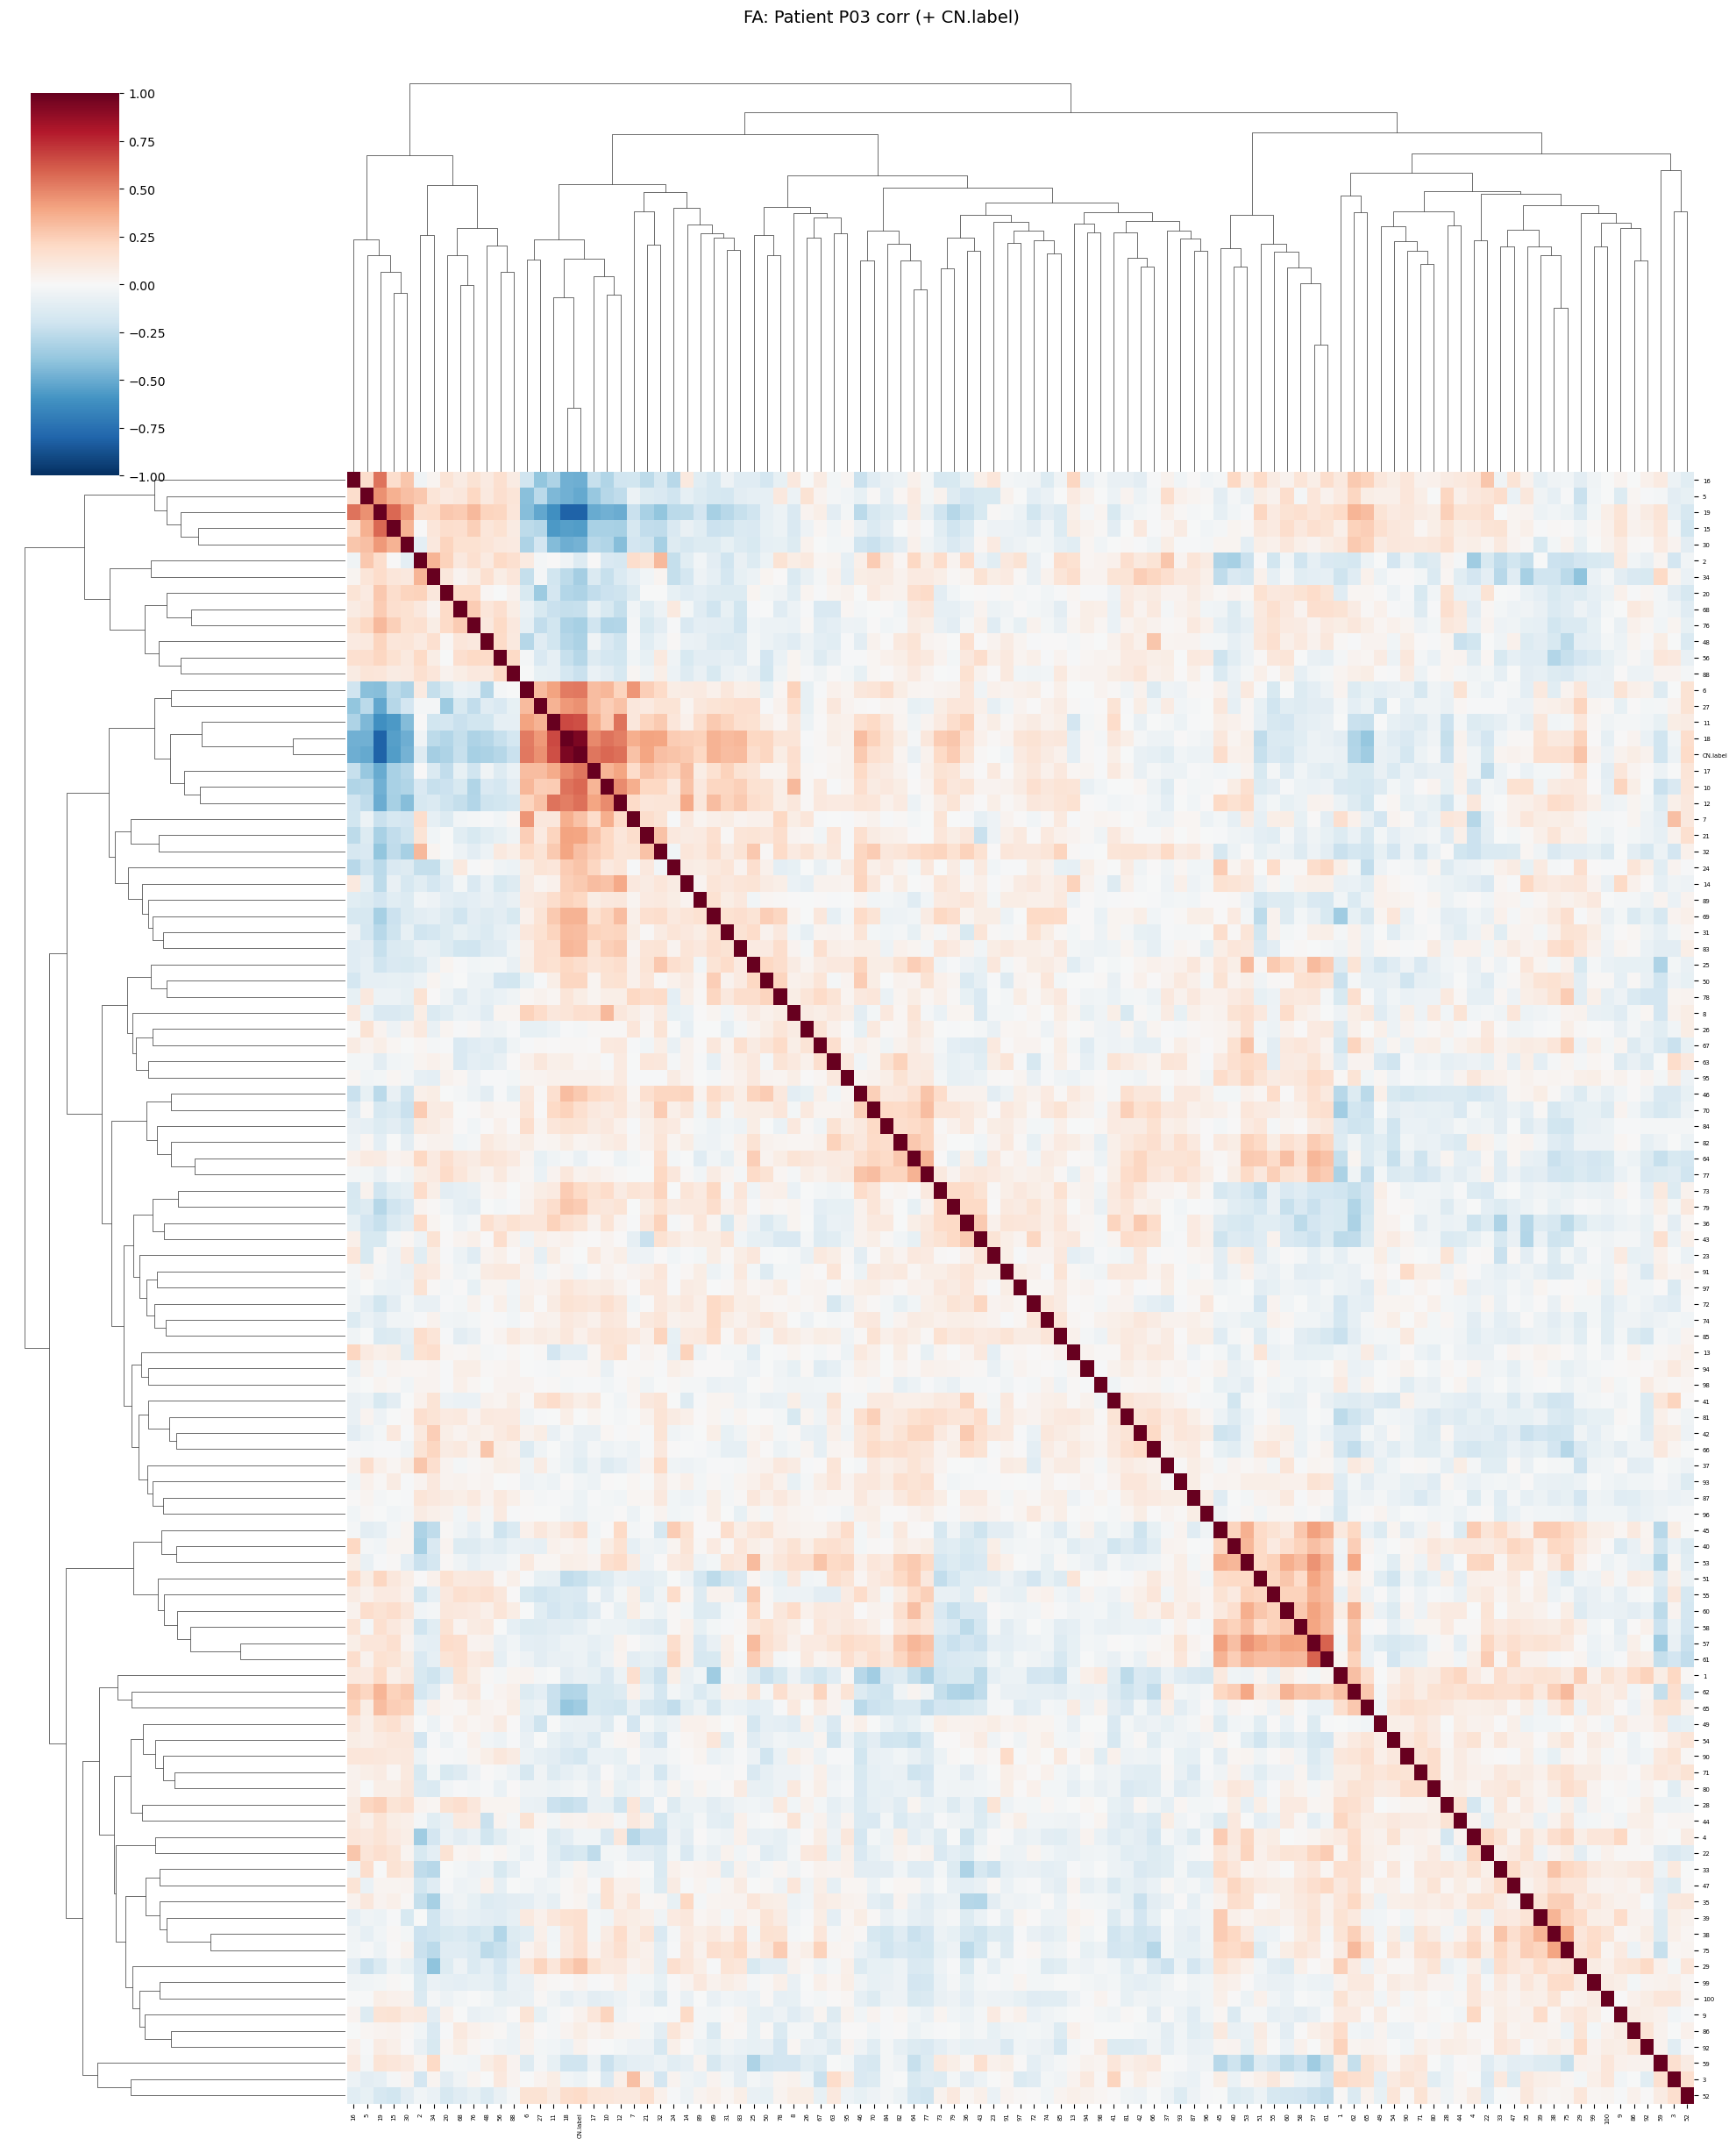

/home/minhang/miniconda3/envs/sc-factosig-gpu/lib/python3.10/site-packages/seaborn/matrix.py:560: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)
/home/minhang/miniconda3/envs/sc-factosig-gpu/lib/python3.10/site-packages/seaborn/matrix.py:560: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)


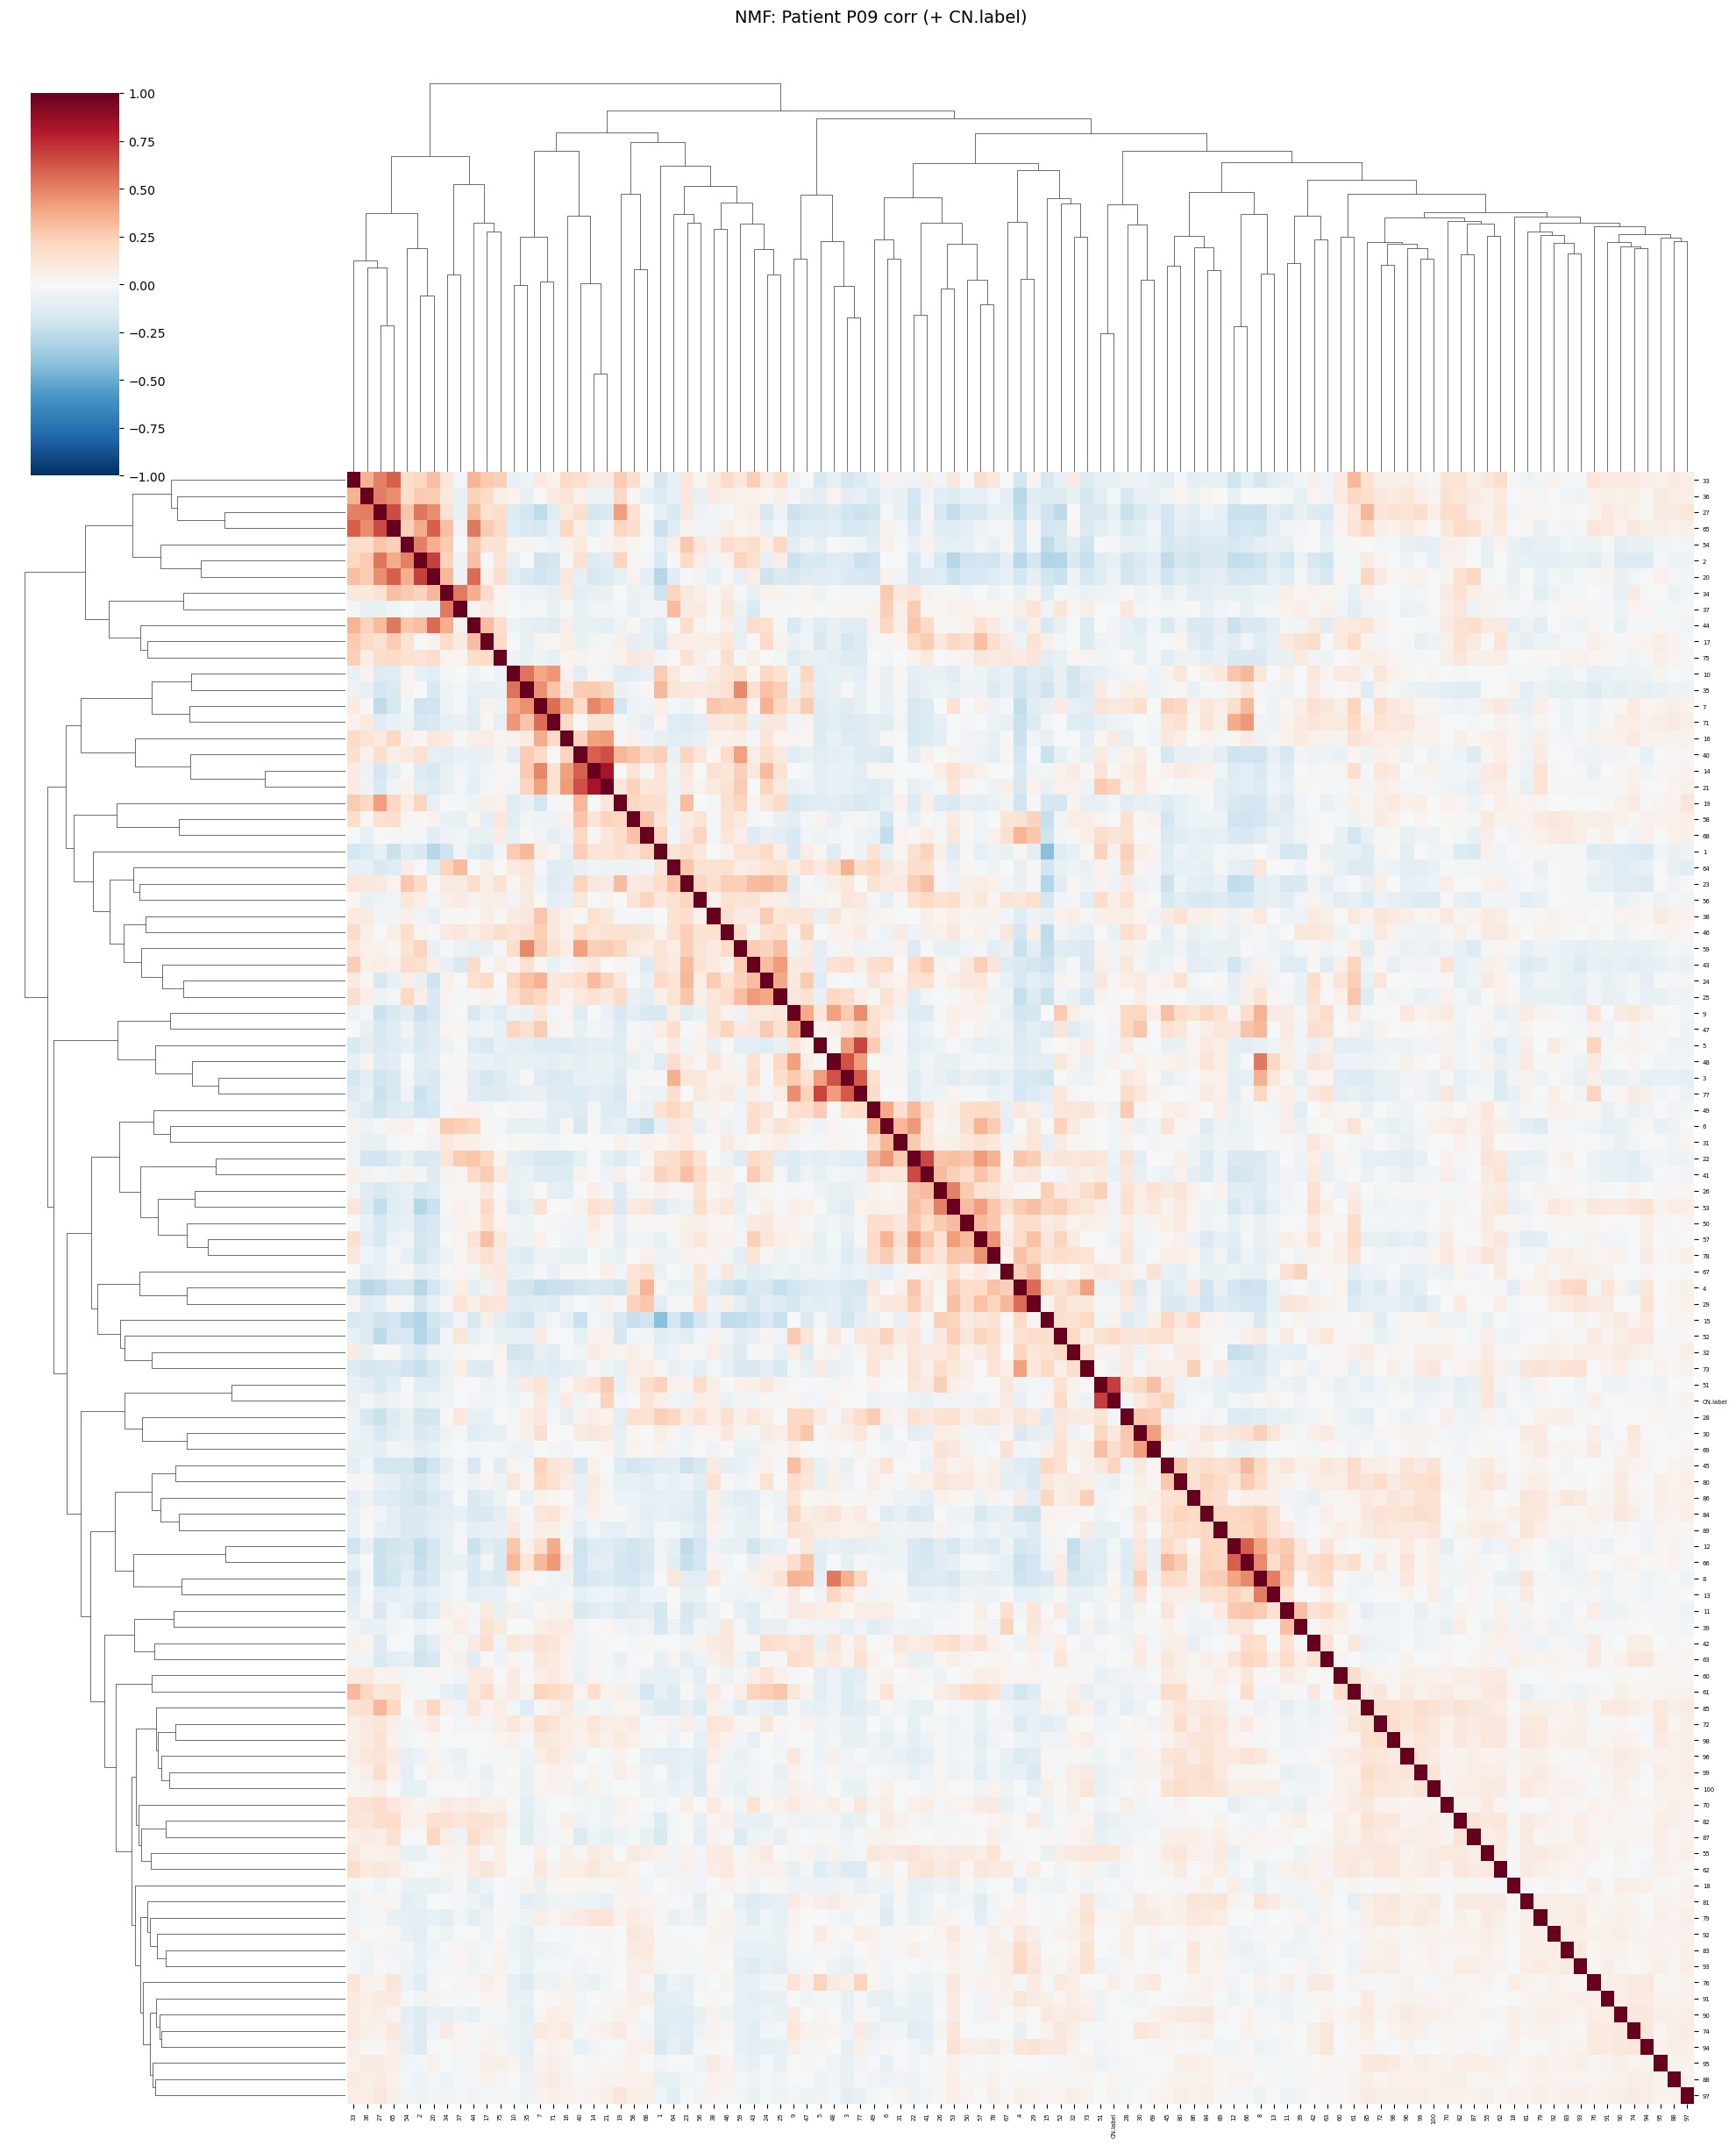

/home/minhang/miniconda3/envs/sc-factosig-gpu/lib/python3.10/site-packages/seaborn/matrix.py:560: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)
/home/minhang/miniconda3/envs/sc-factosig-gpu/lib/python3.10/site-packages/seaborn/matrix.py:560: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)


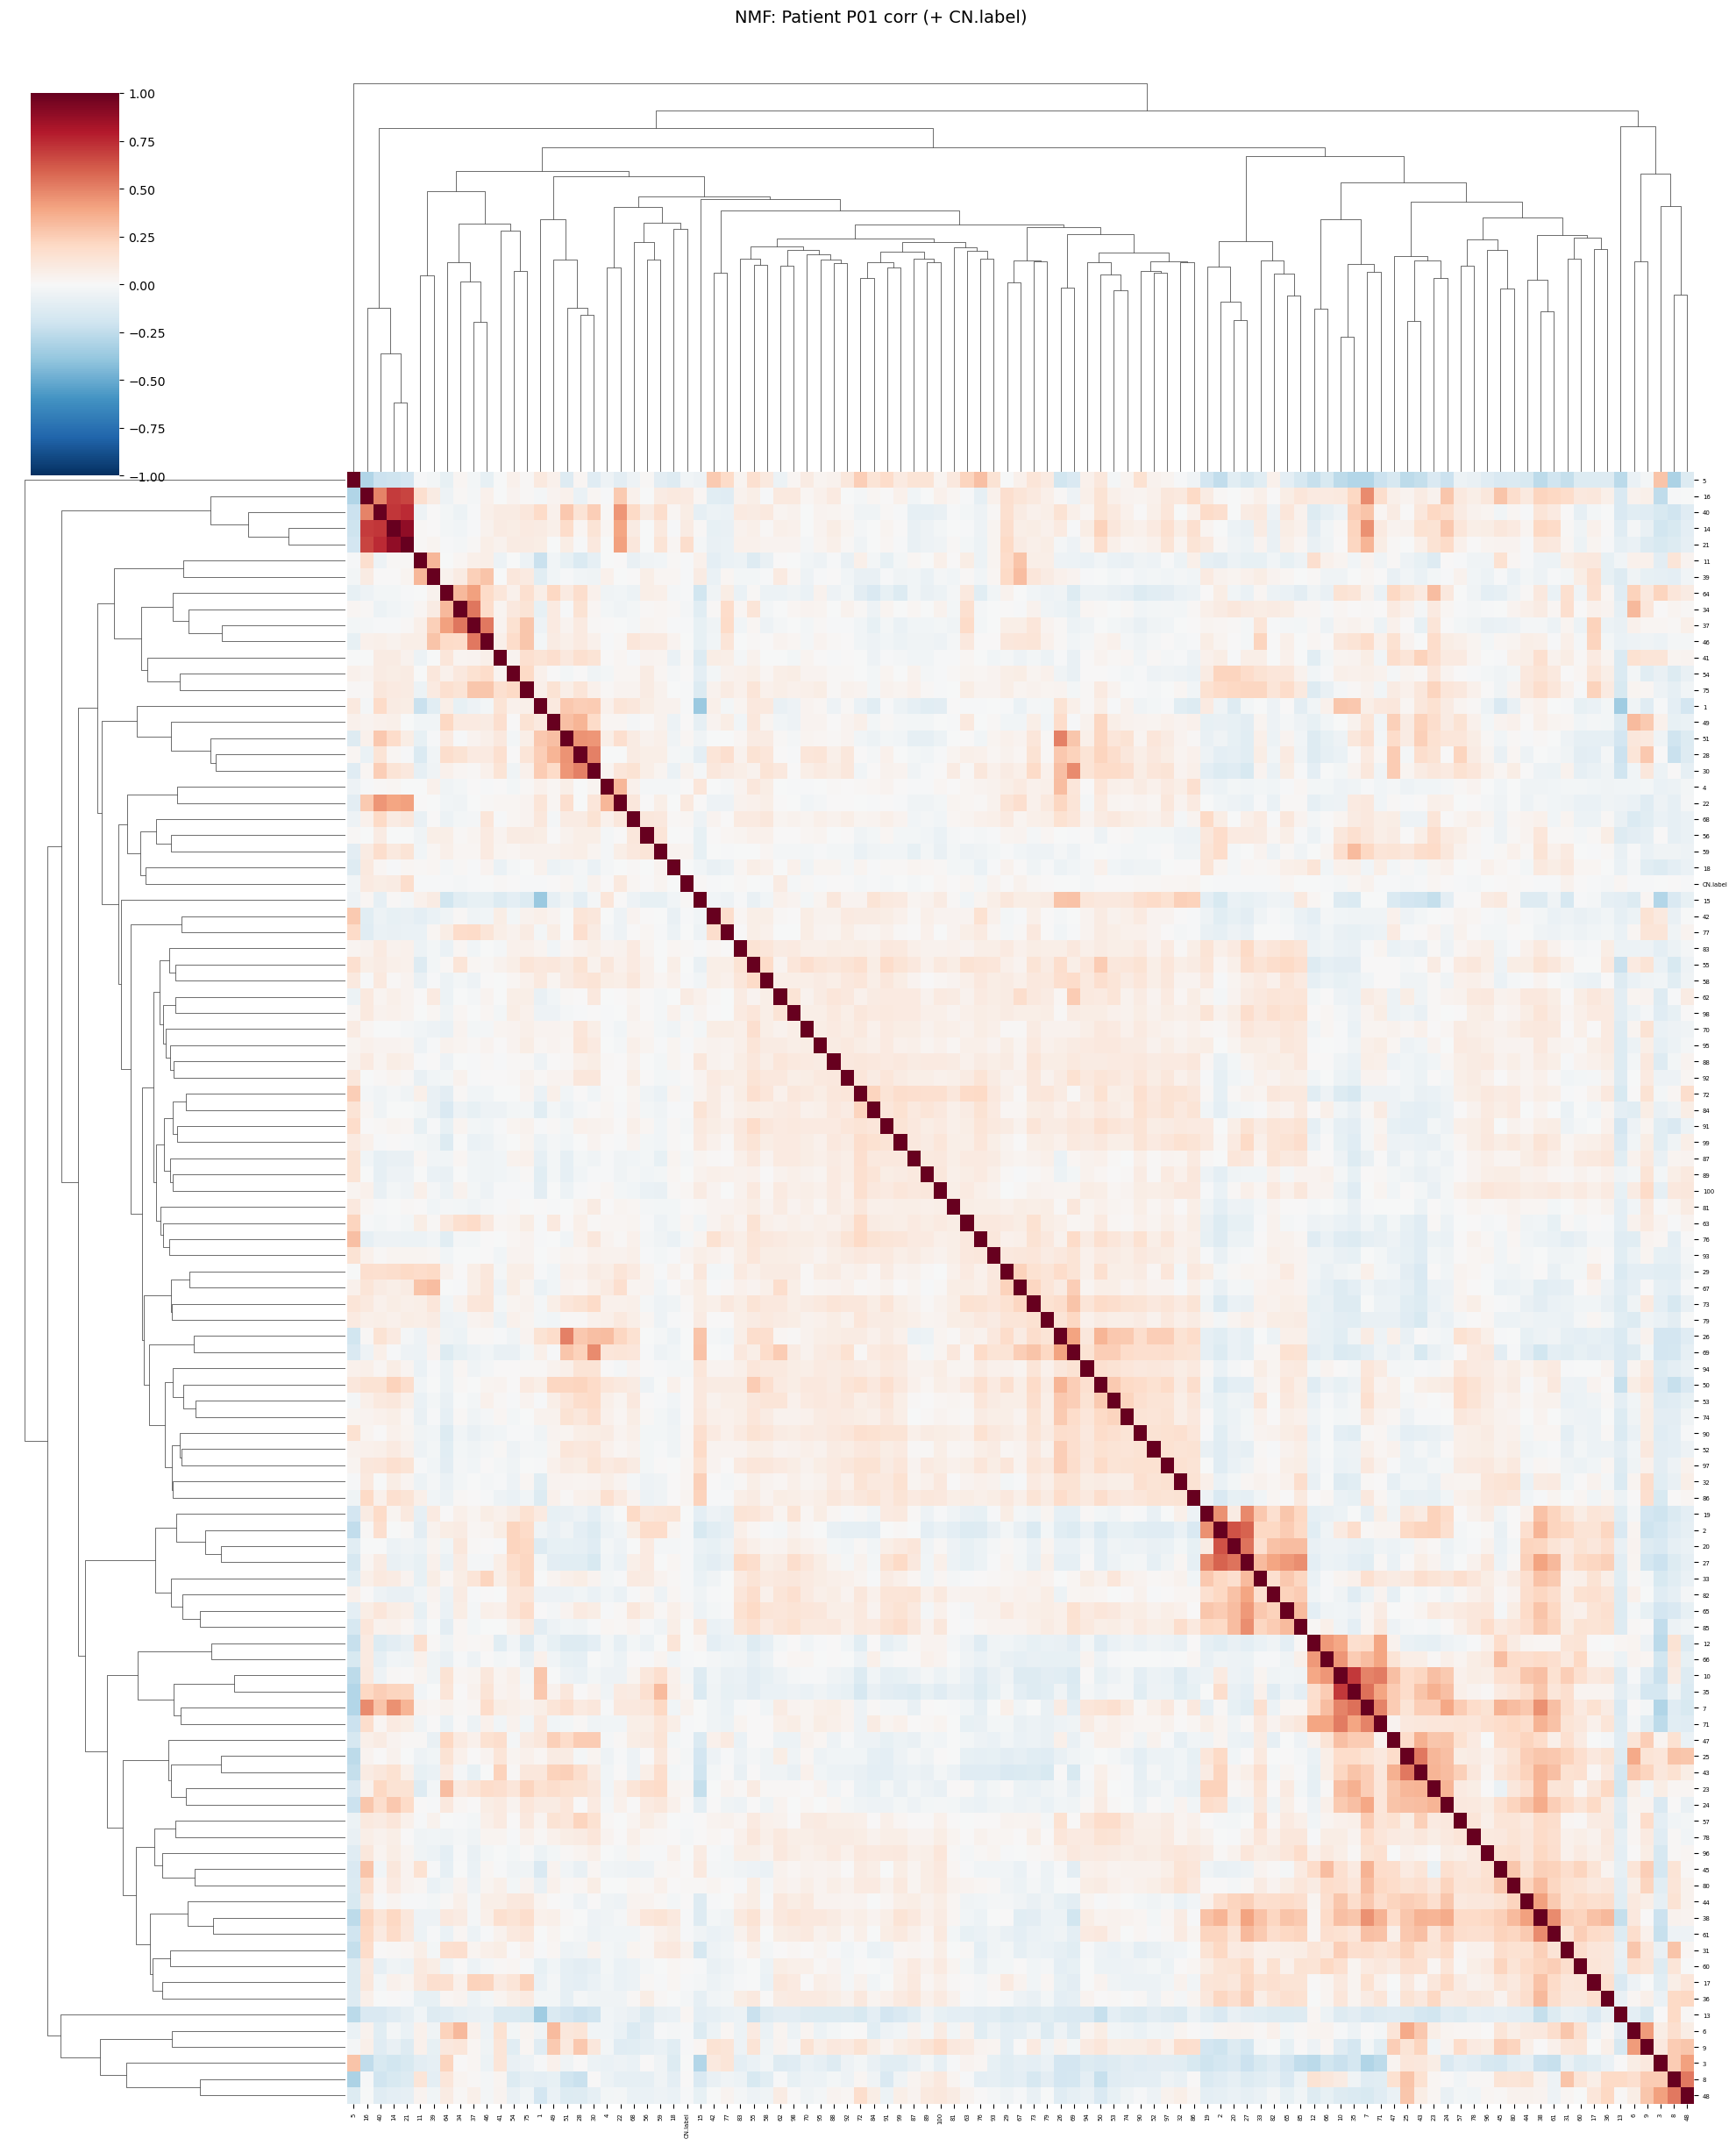

/home/minhang/miniconda3/envs/sc-factosig-gpu/lib/python3.10/site-packages/seaborn/matrix.py:560: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)
/home/minhang/miniconda3/envs/sc-factosig-gpu/lib/python3.10/site-packages/seaborn/matrix.py:560: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)


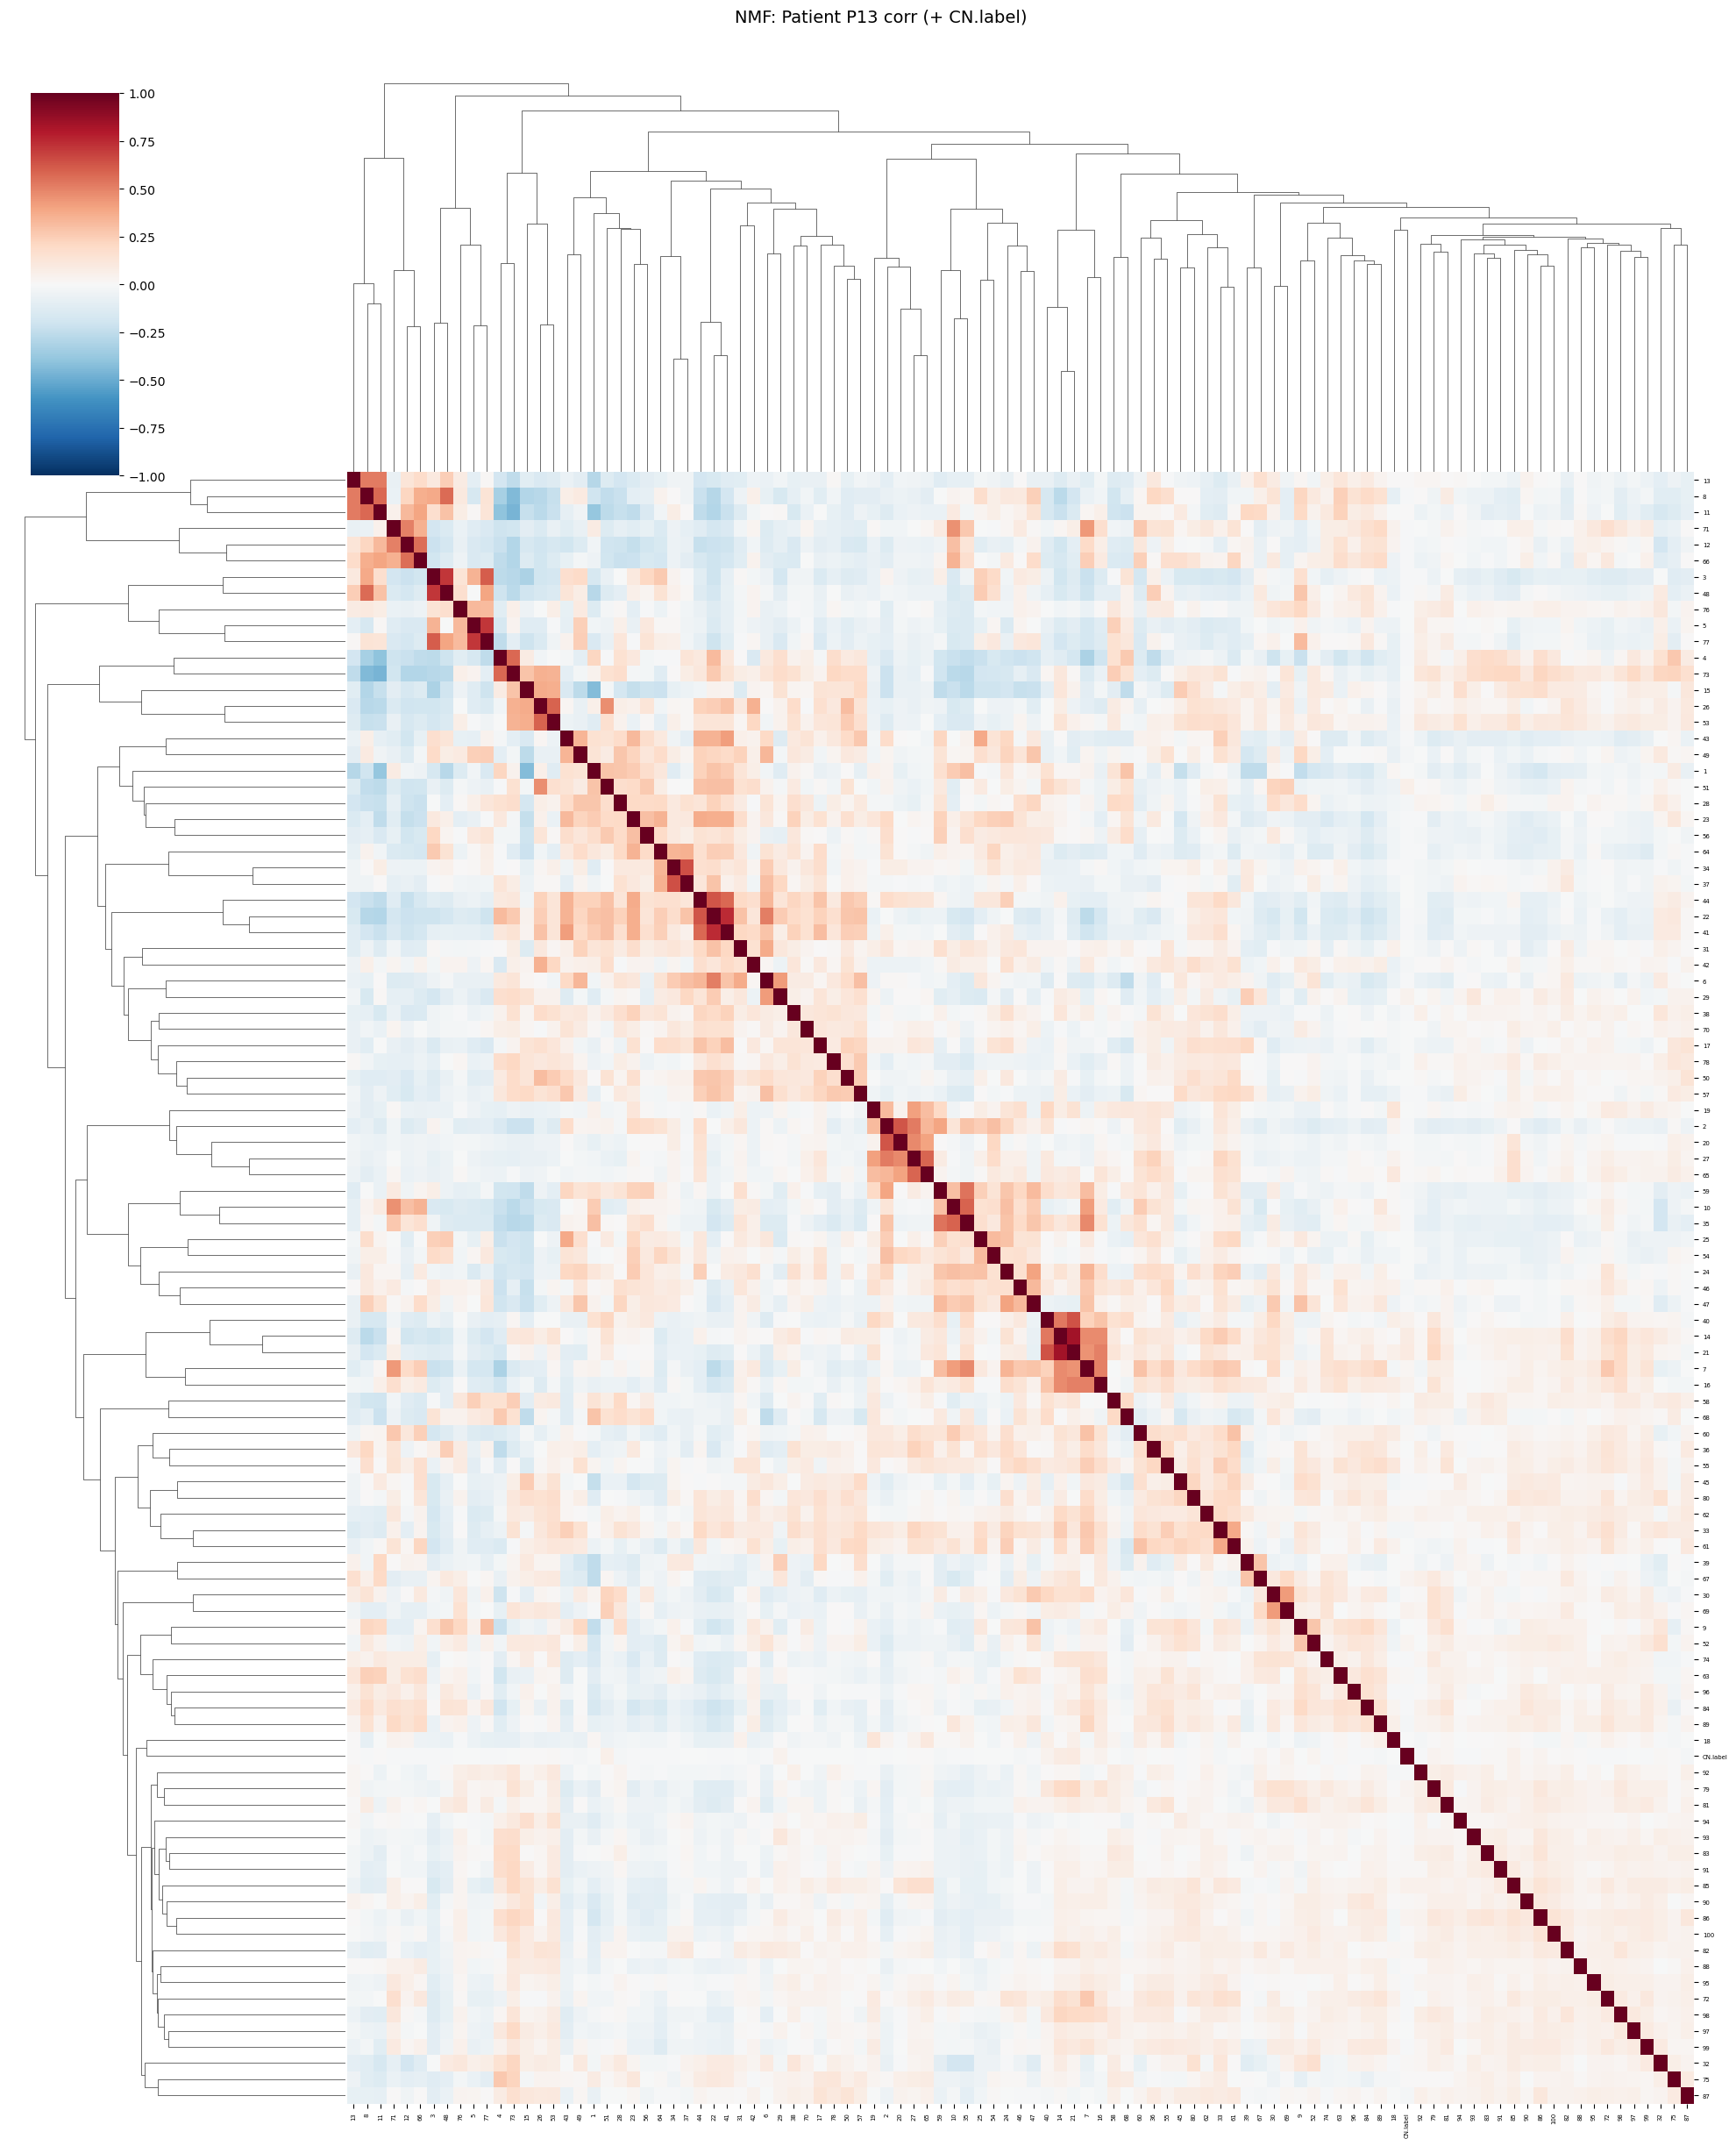

/home/minhang/miniconda3/envs/sc-factosig-gpu/lib/python3.10/site-packages/seaborn/matrix.py:560: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)
/home/minhang/miniconda3/envs/sc-factosig-gpu/lib/python3.10/site-packages/seaborn/matrix.py:560: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)


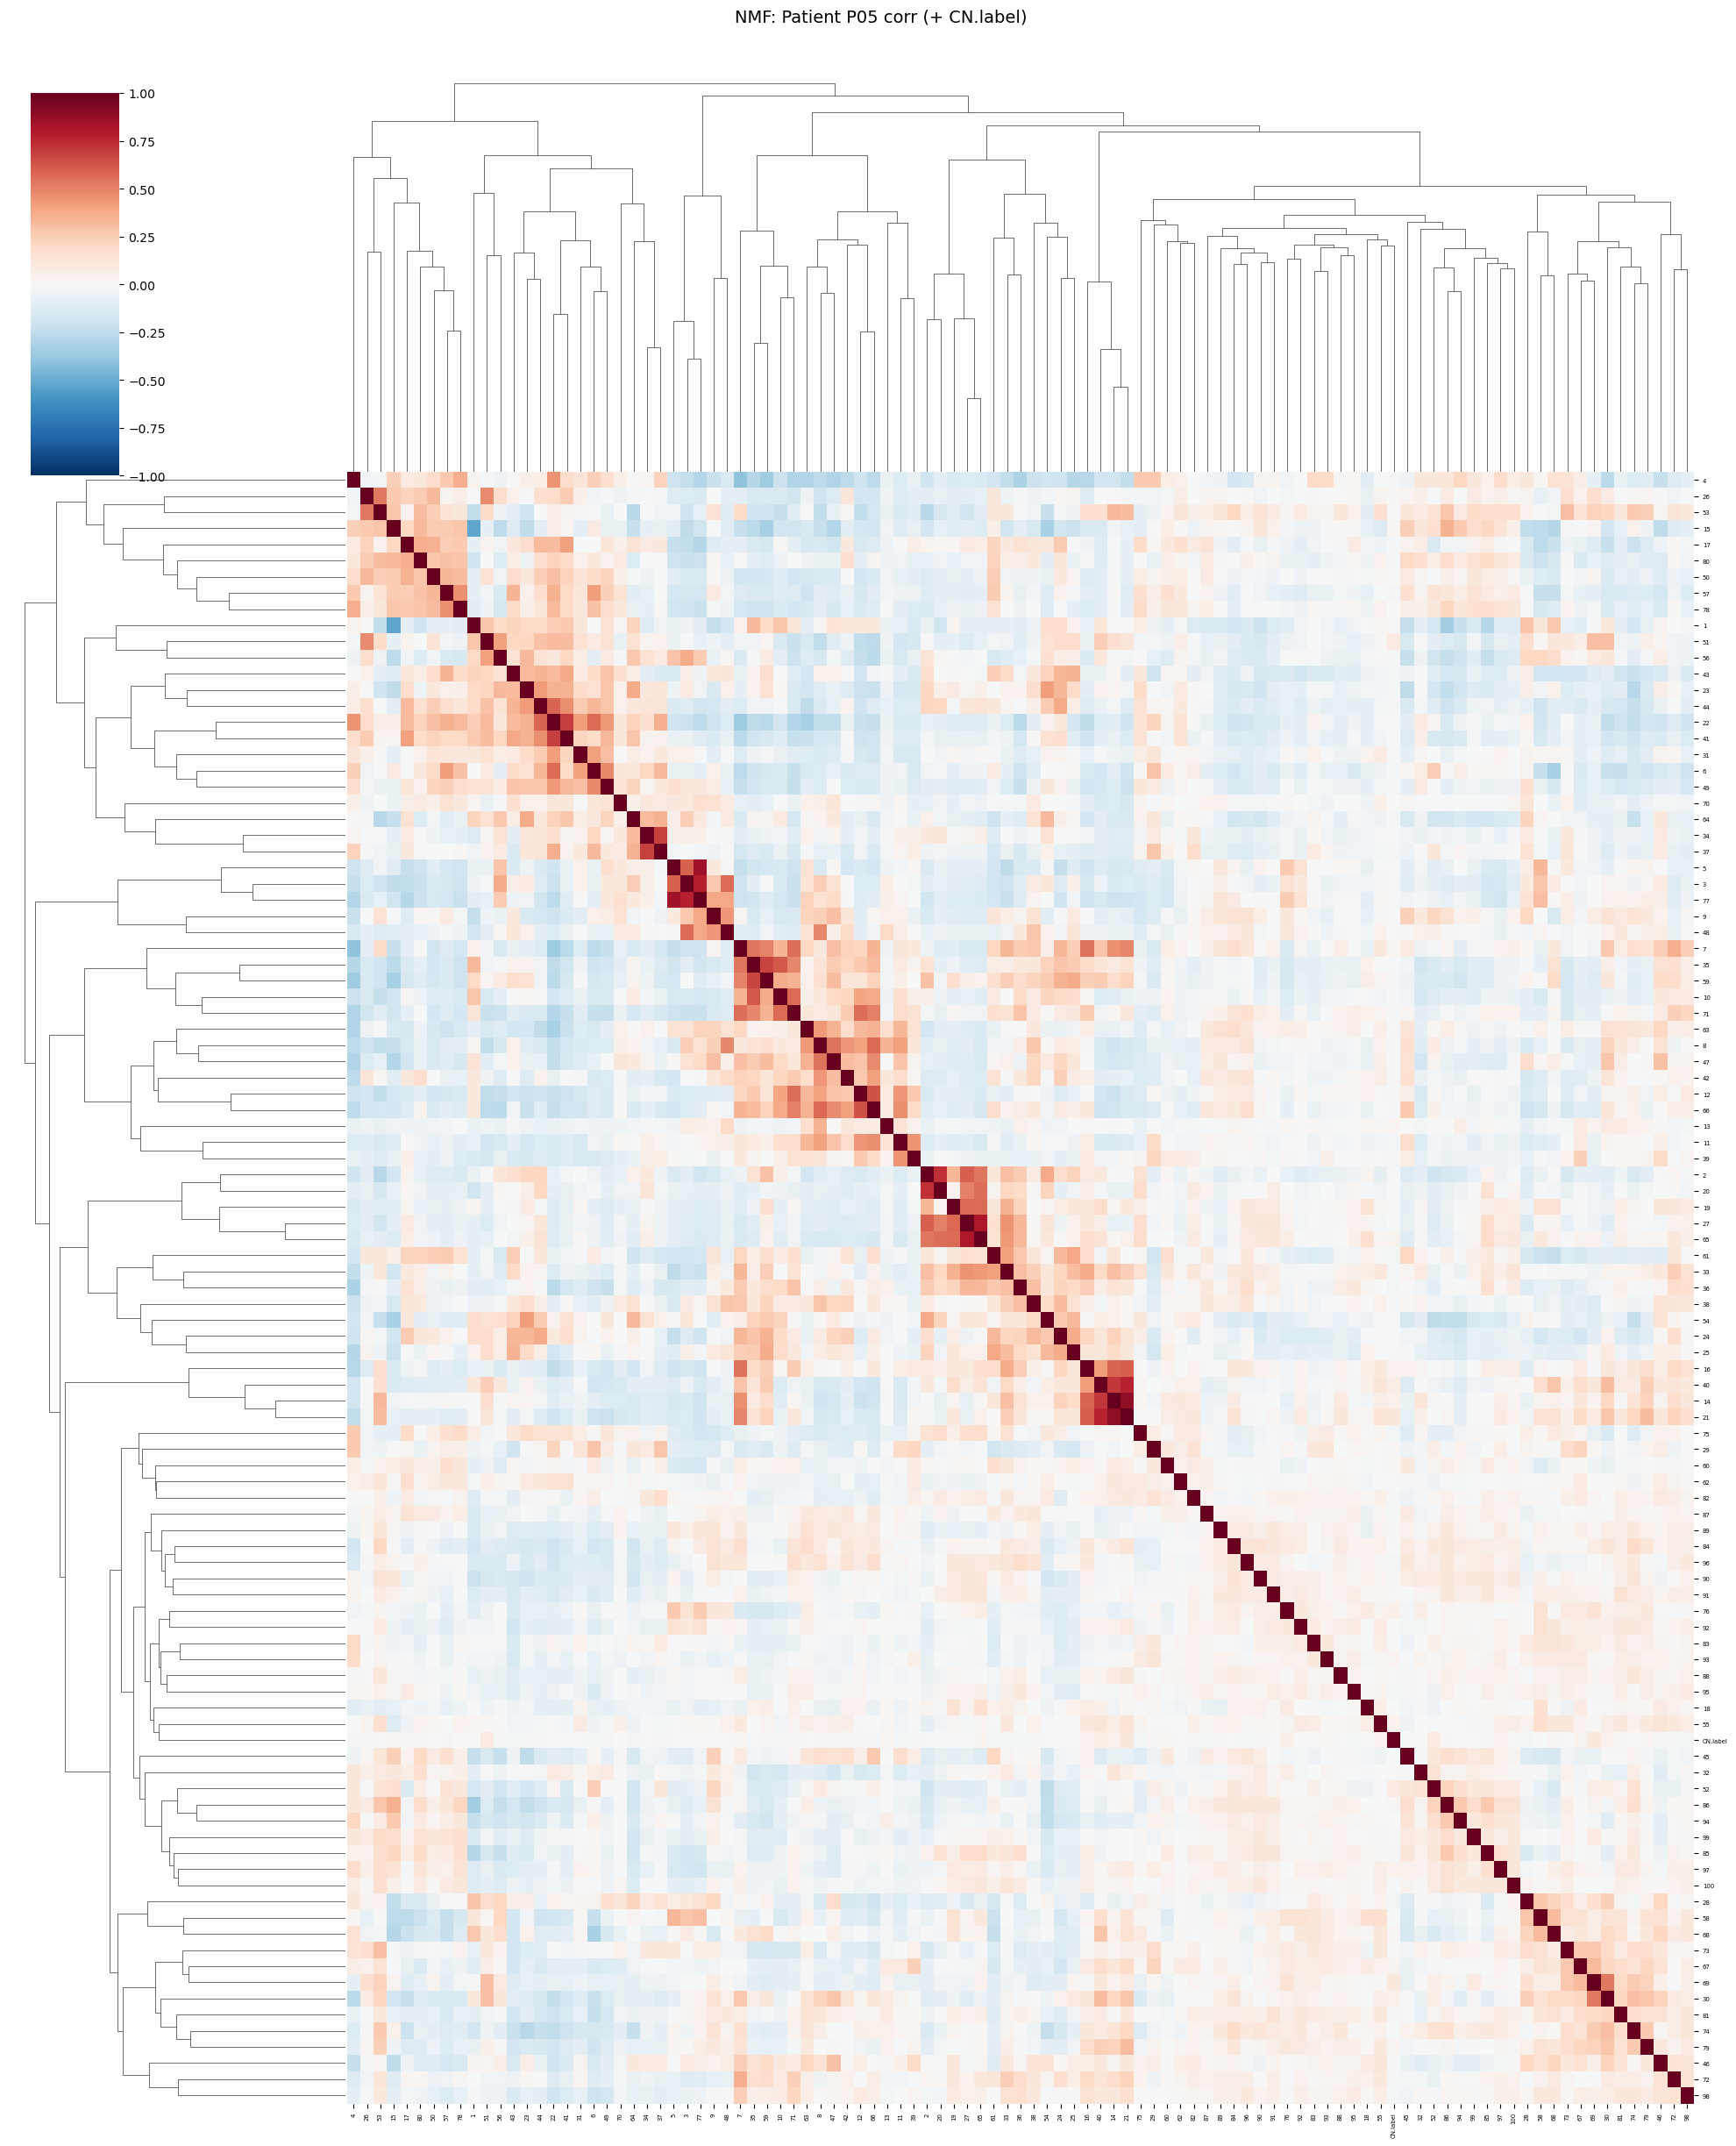

/home/minhang/miniconda3/envs/sc-factosig-gpu/lib/python3.10/site-packages/seaborn/matrix.py:560: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)
/home/minhang/miniconda3/envs/sc-factosig-gpu/lib/python3.10/site-packages/seaborn/matrix.py:560: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)


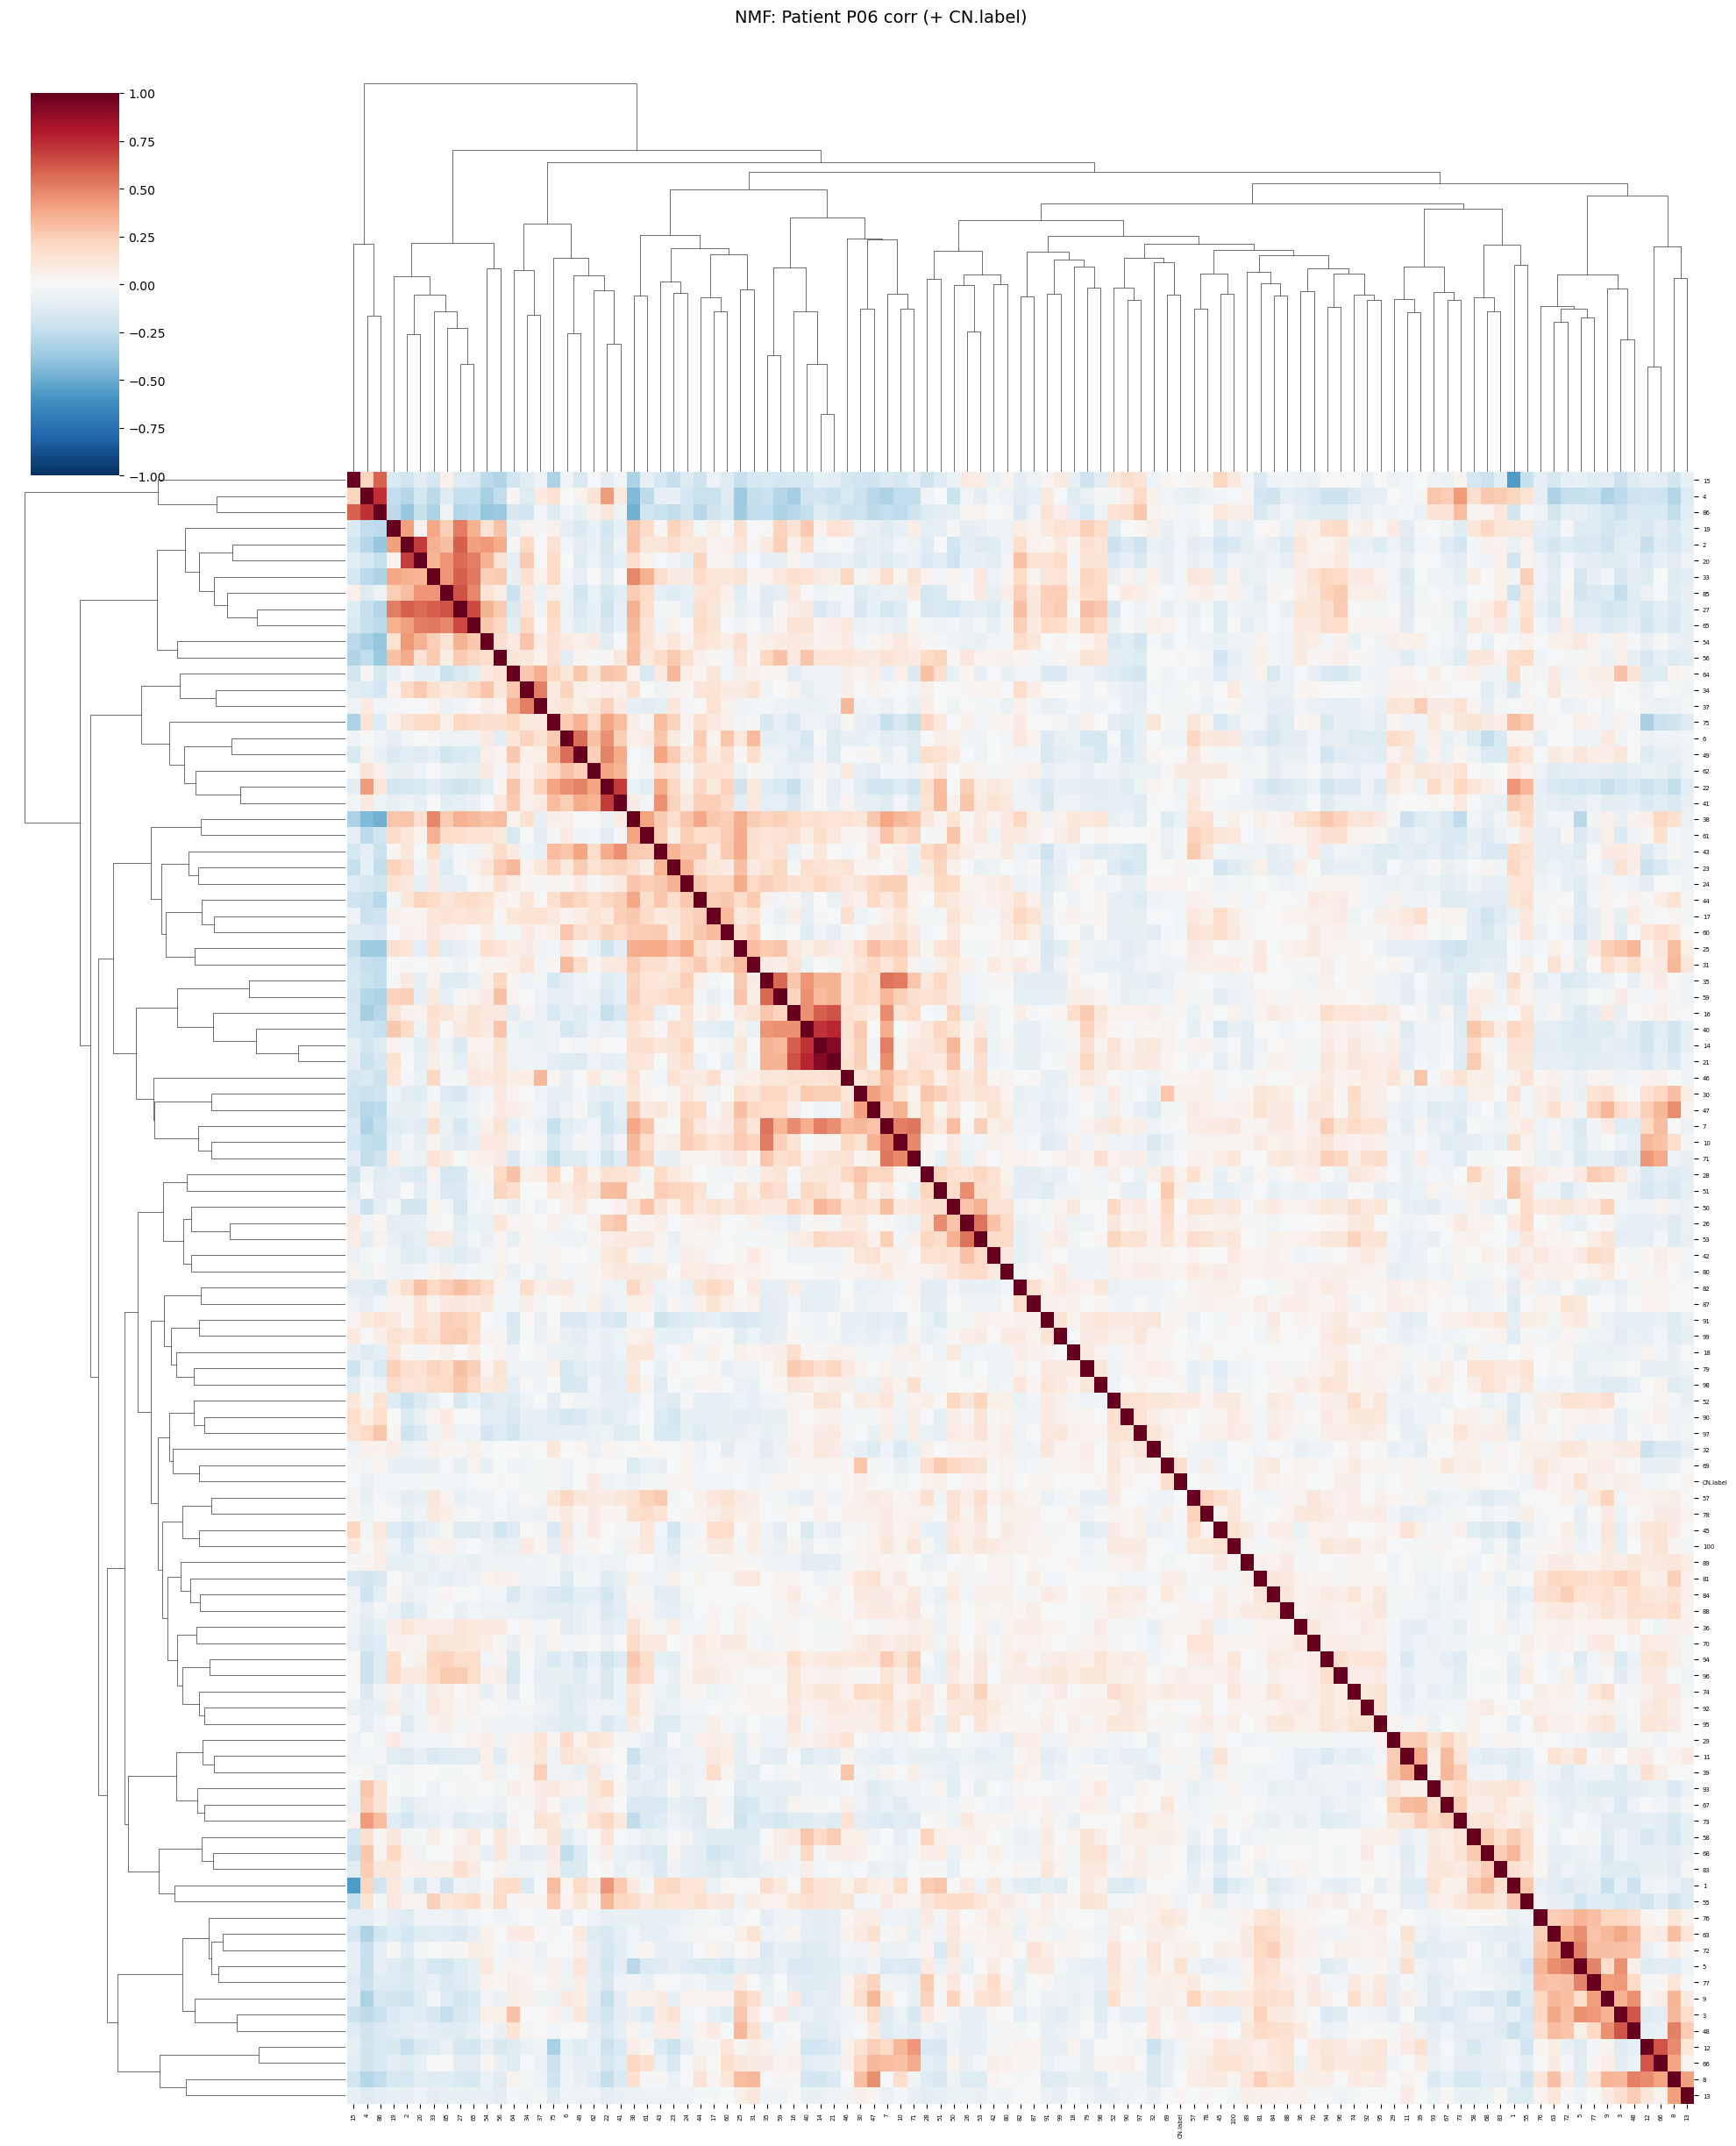

/home/minhang/miniconda3/envs/sc-factosig-gpu/lib/python3.10/site-packages/seaborn/matrix.py:560: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)
/home/minhang/miniconda3/envs/sc-factosig-gpu/lib/python3.10/site-packages/seaborn/matrix.py:560: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)


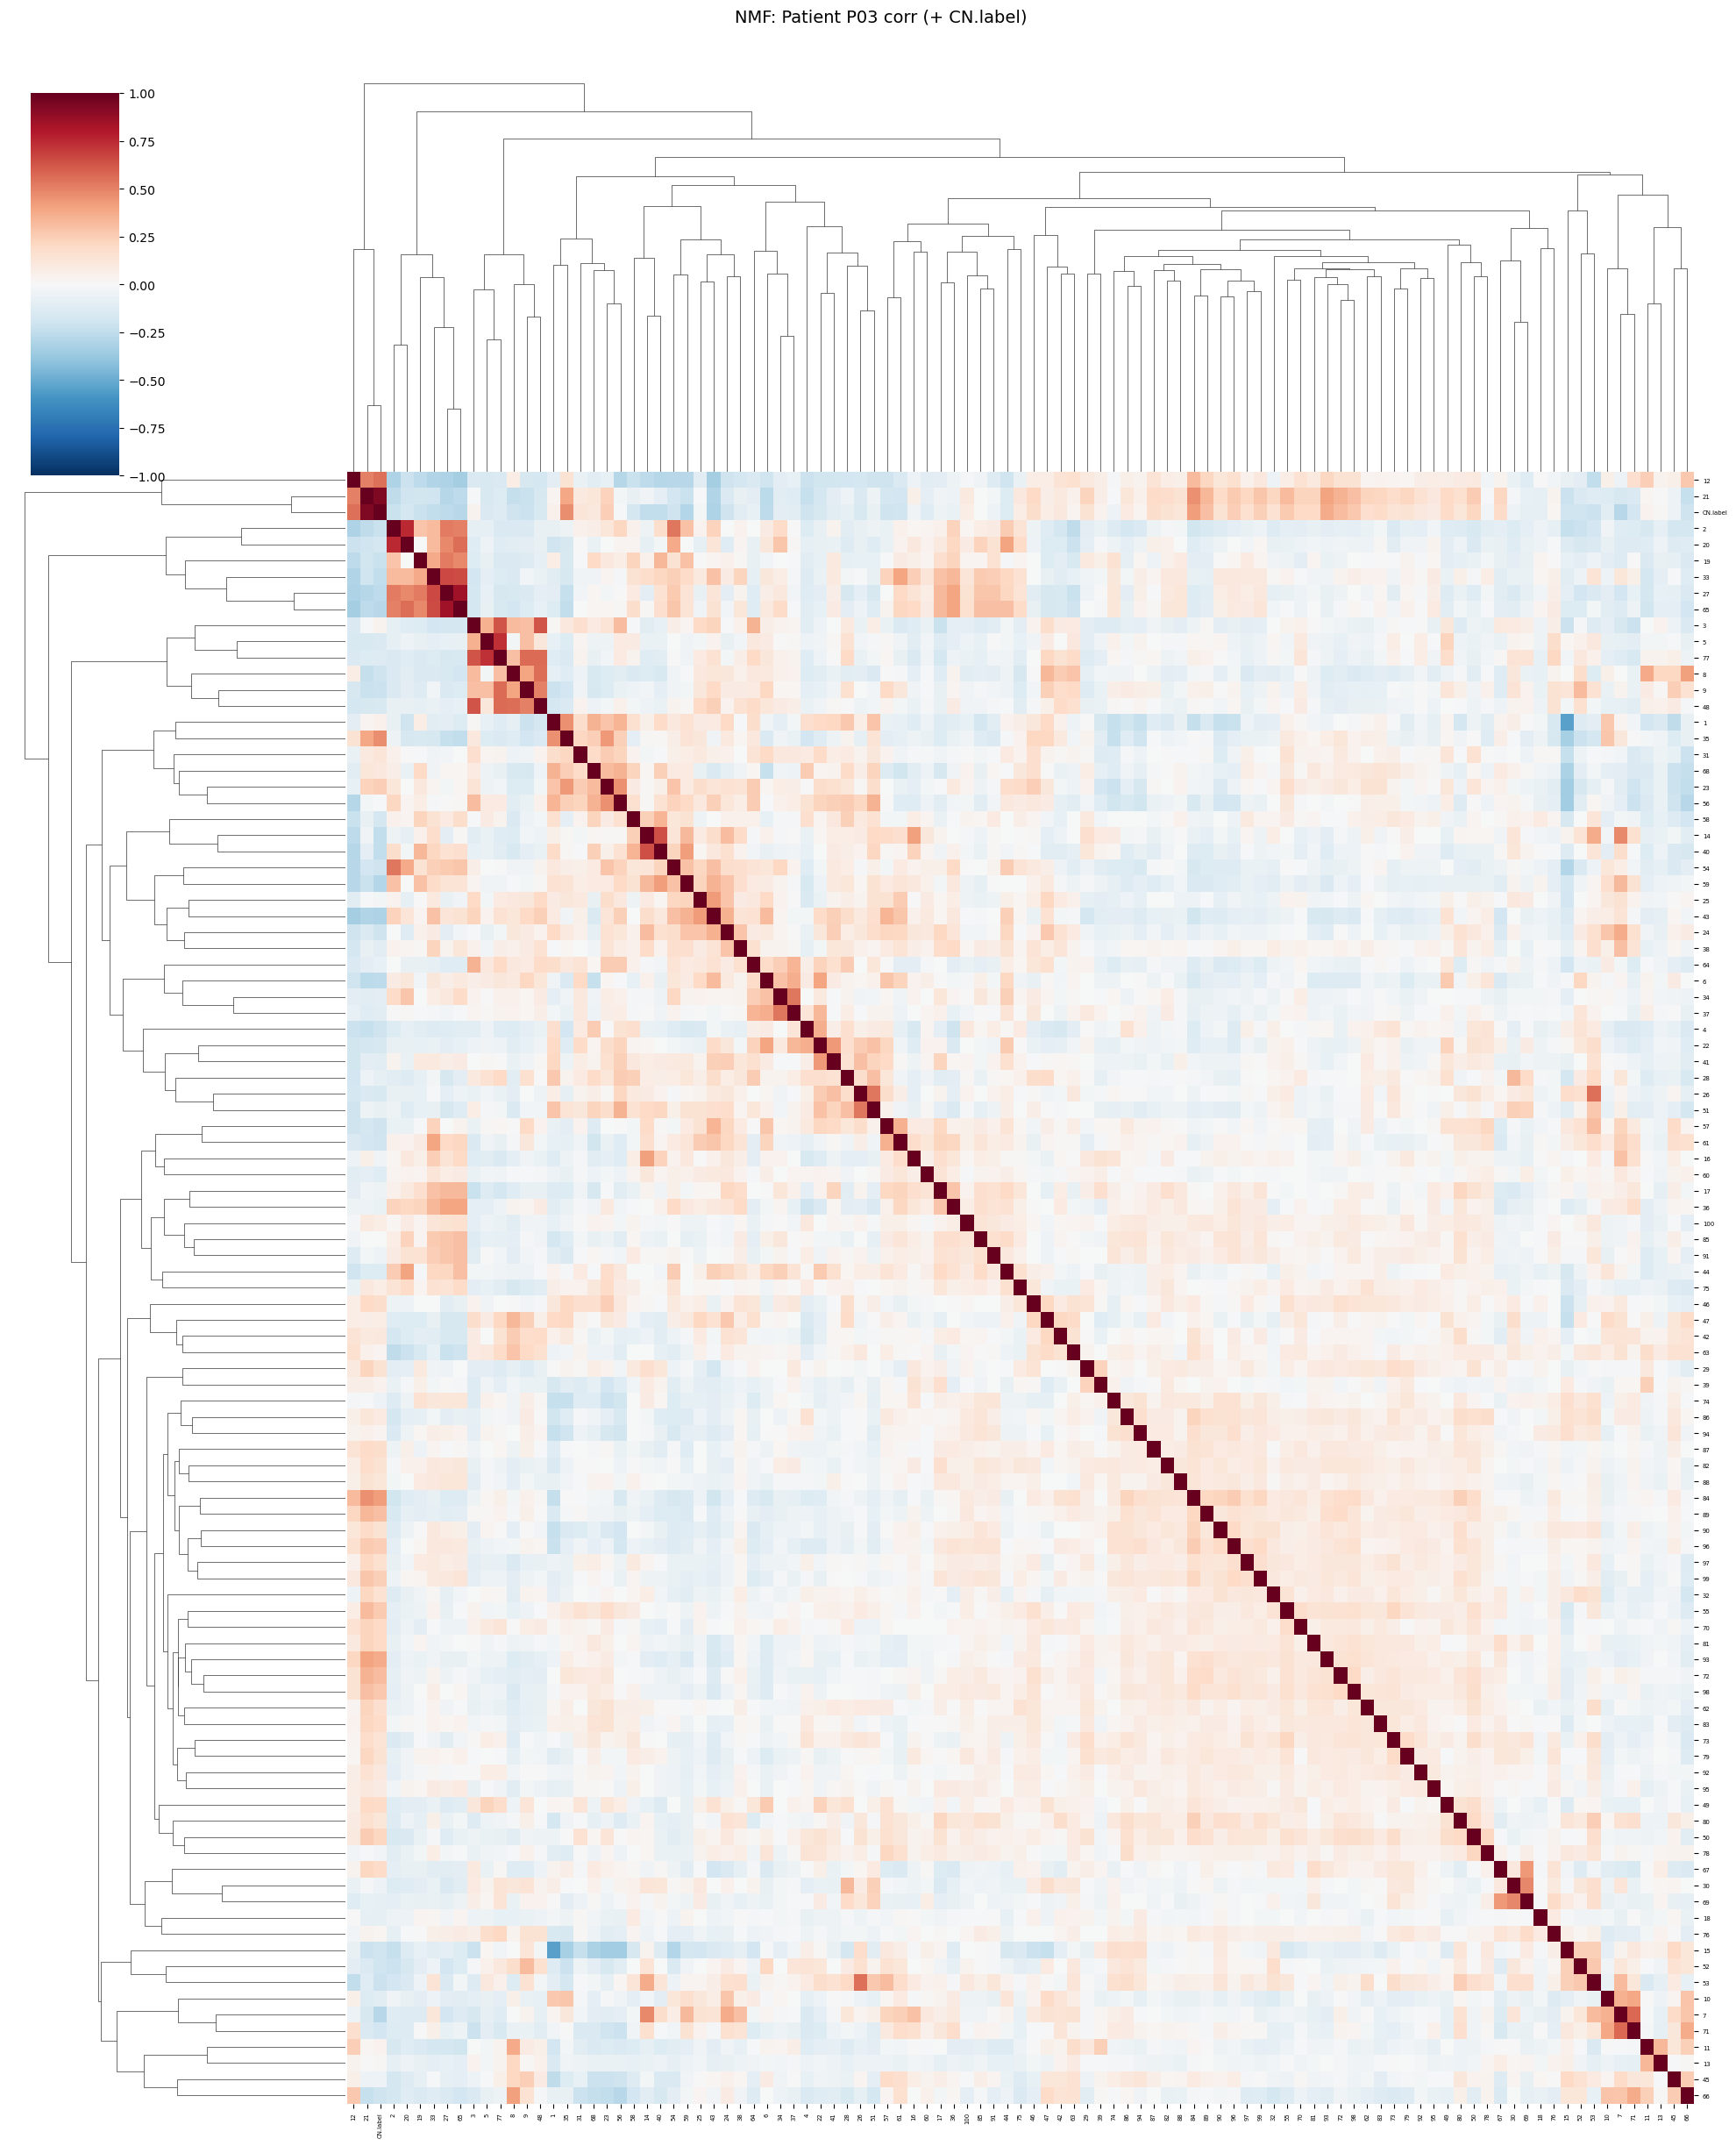

/home/minhang/miniconda3/envs/sc-factosig-gpu/lib/python3.10/site-packages/seaborn/matrix.py:560: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)
/home/minhang/miniconda3/envs/sc-factosig-gpu/lib/python3.10/site-packages/seaborn/matrix.py:560: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)


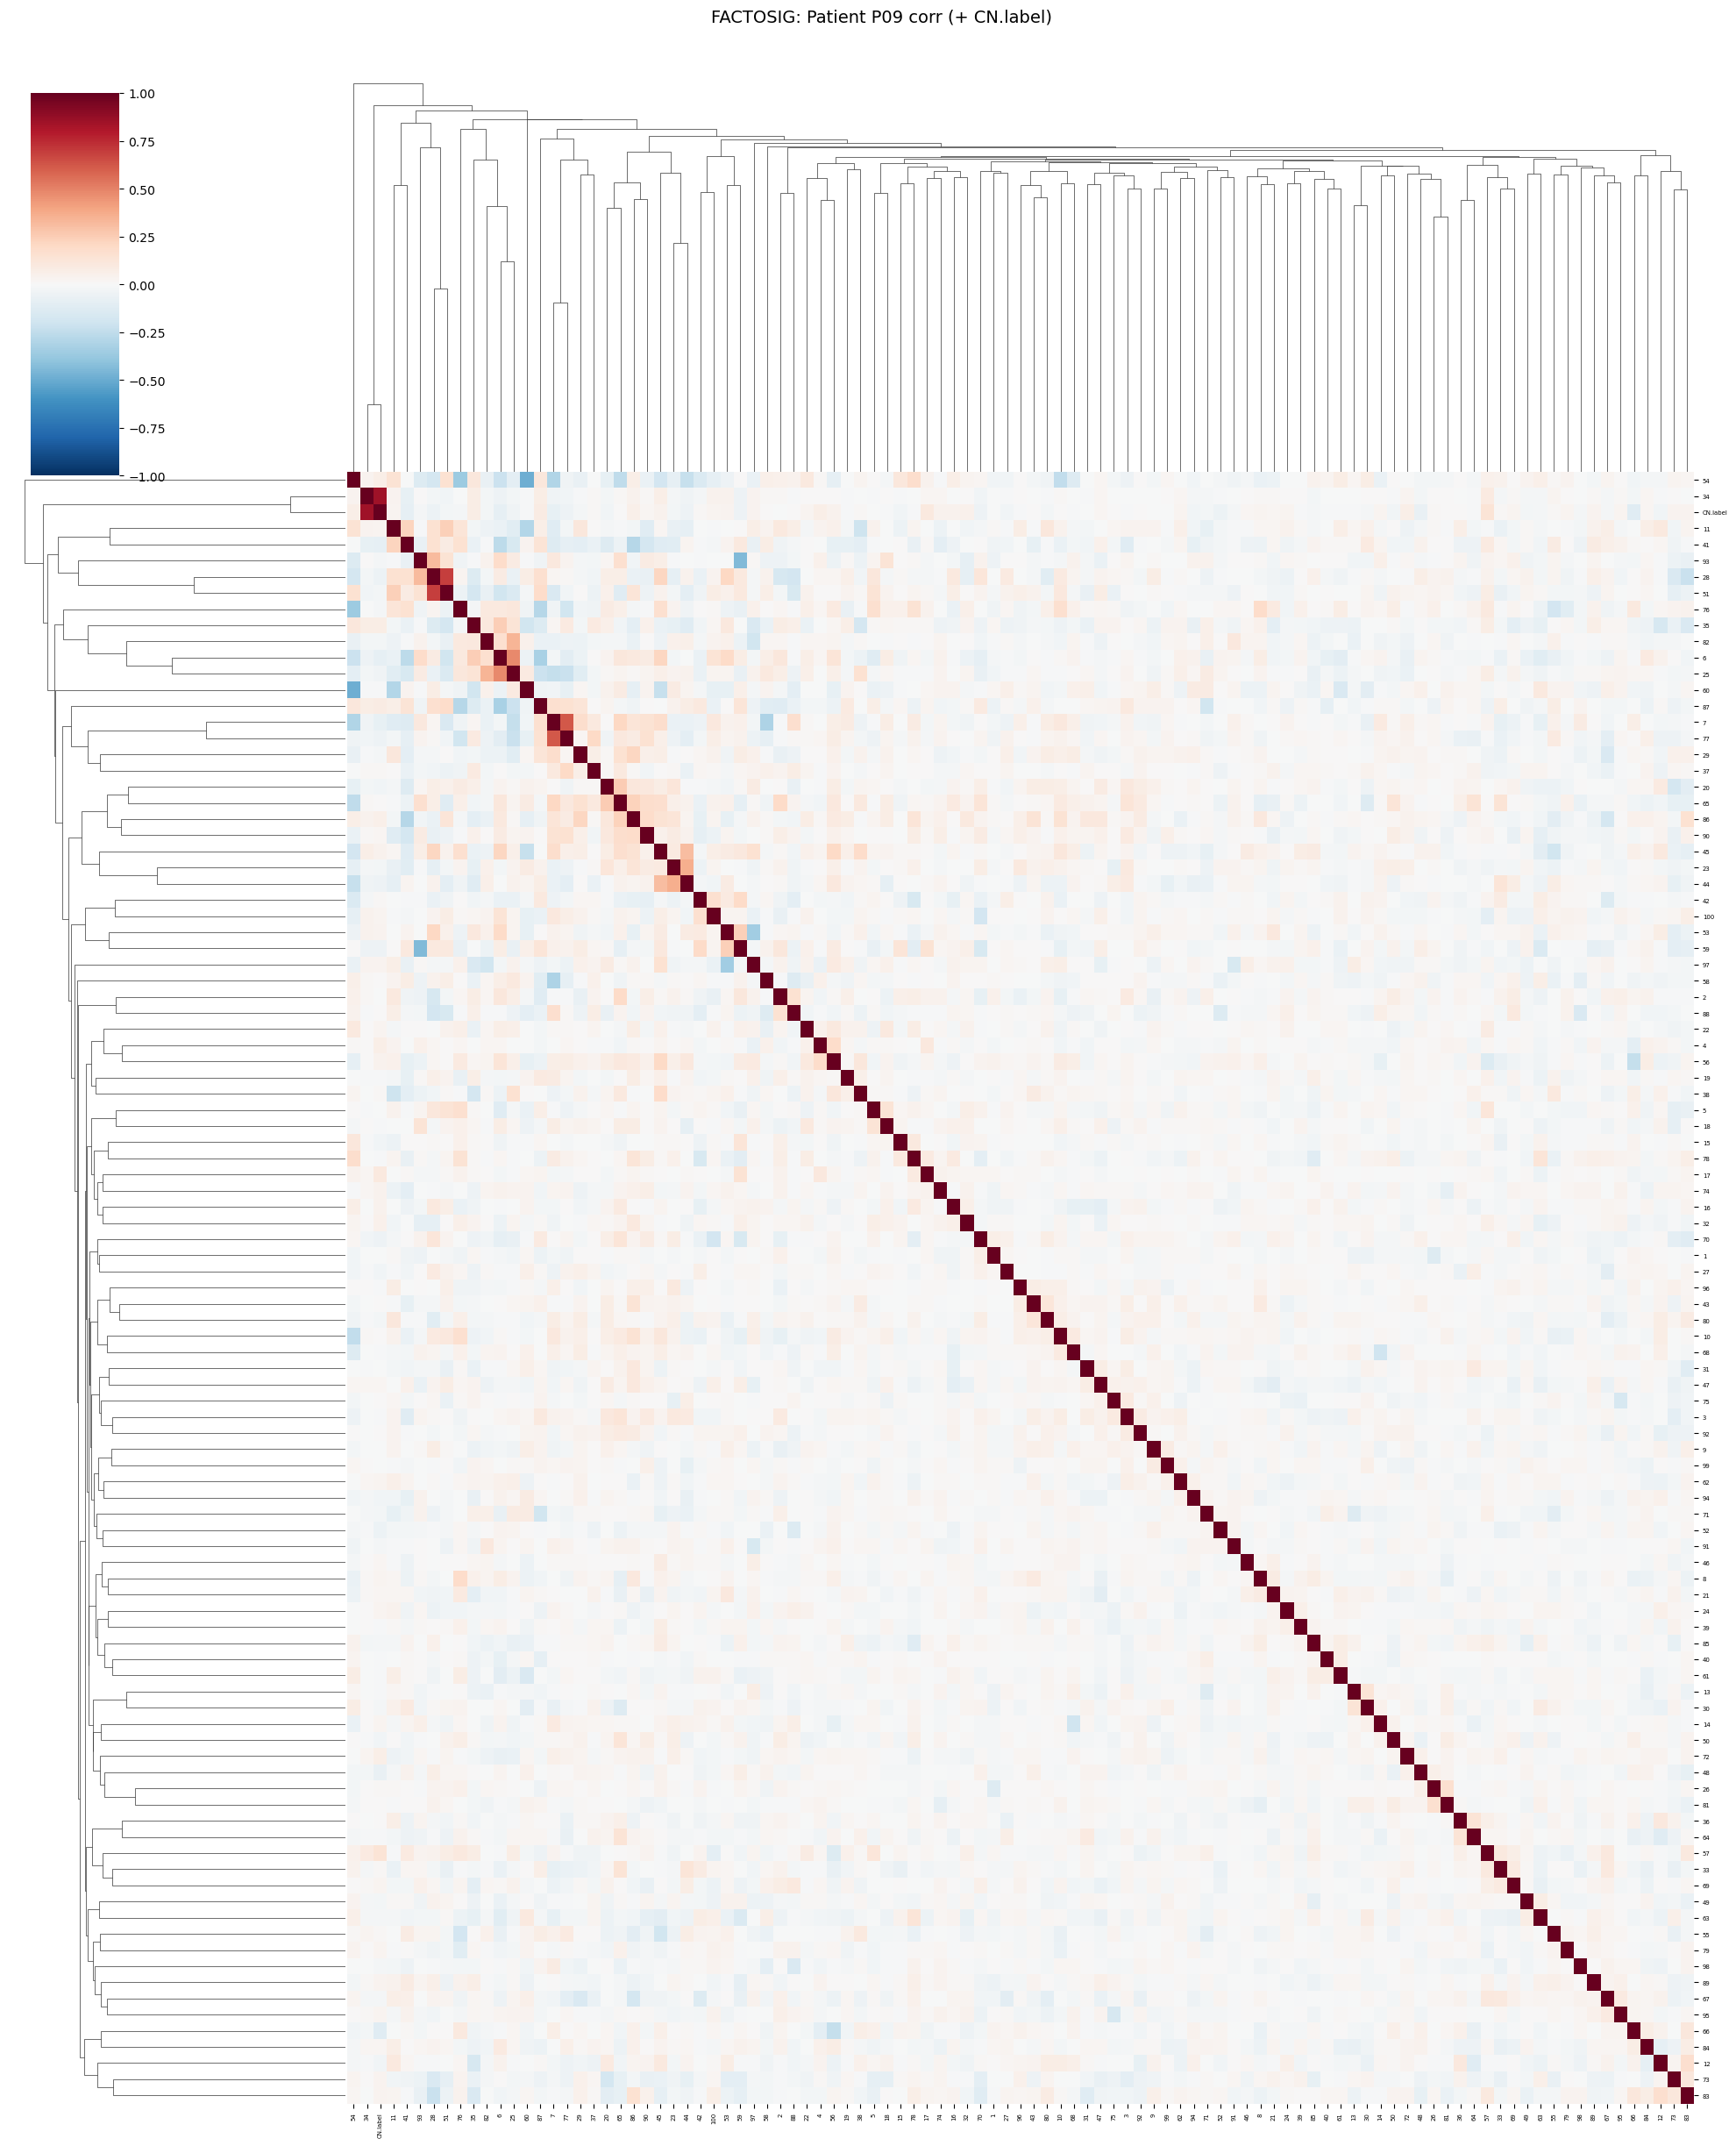

/home/minhang/miniconda3/envs/sc-factosig-gpu/lib/python3.10/site-packages/seaborn/matrix.py:560: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)
/home/minhang/miniconda3/envs/sc-factosig-gpu/lib/python3.10/site-packages/seaborn/matrix.py:560: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)


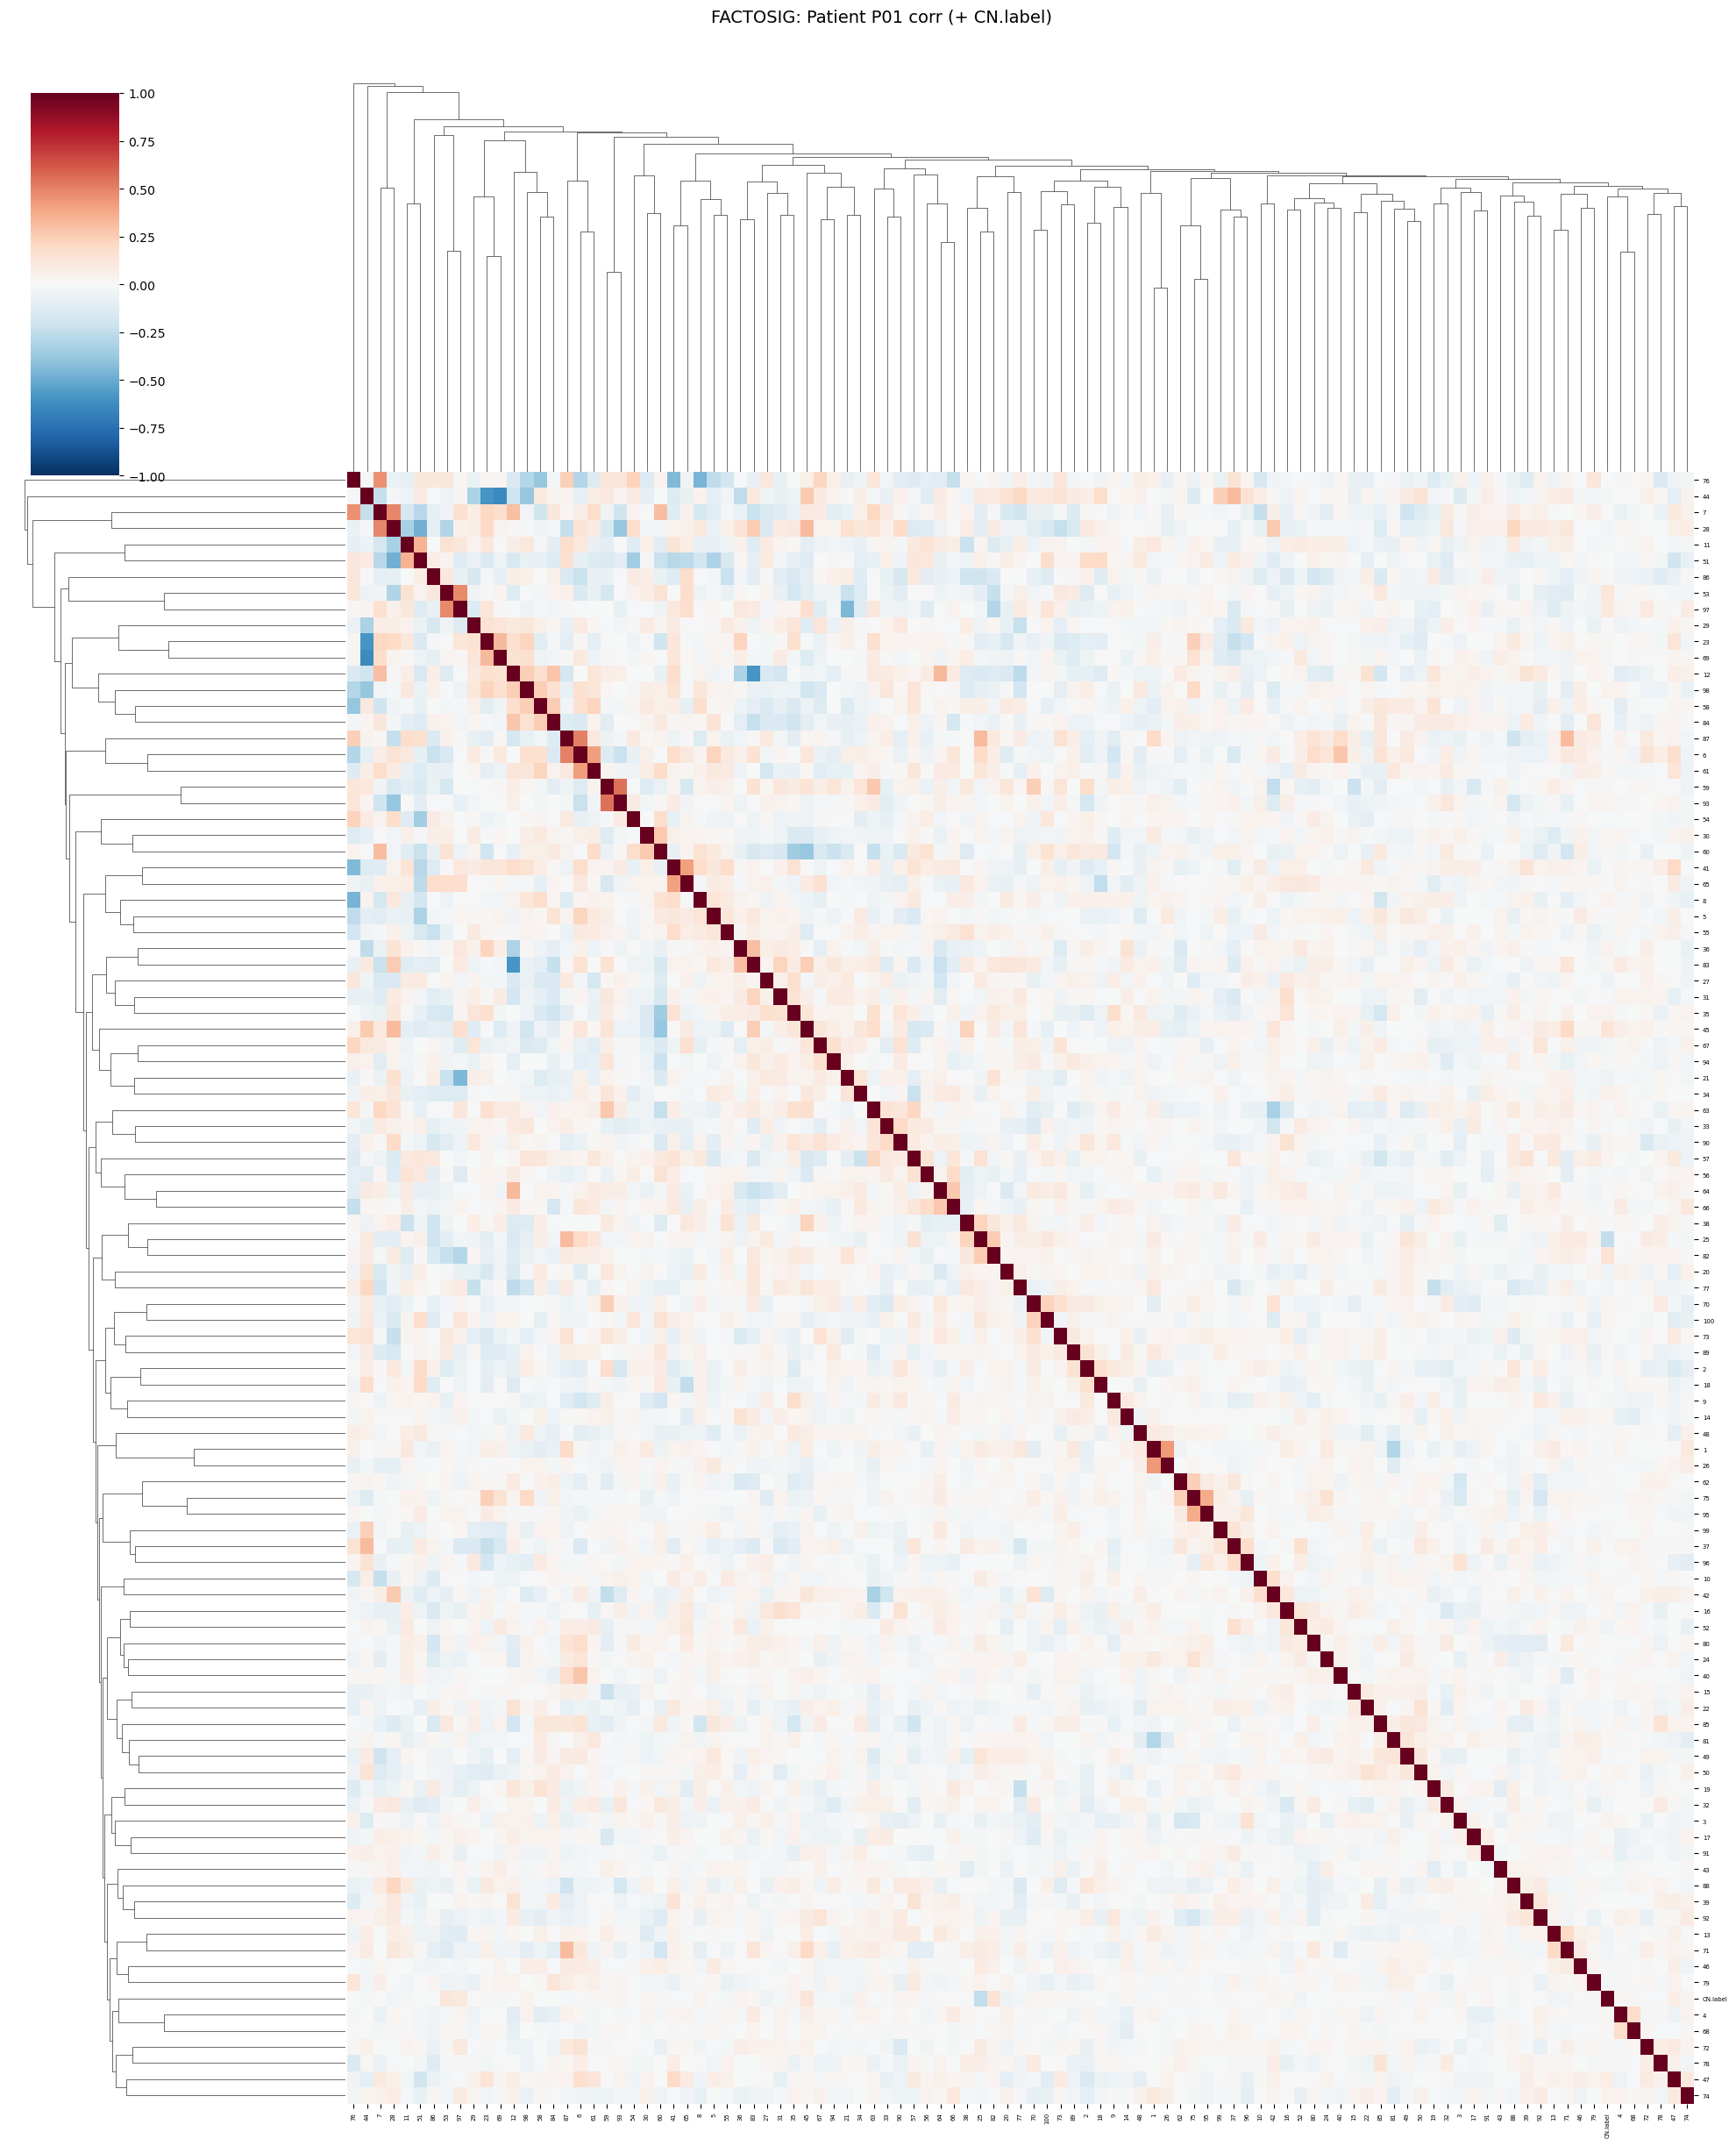

/home/minhang/miniconda3/envs/sc-factosig-gpu/lib/python3.10/site-packages/seaborn/matrix.py:560: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)
/home/minhang/miniconda3/envs/sc-factosig-gpu/lib/python3.10/site-packages/seaborn/matrix.py:560: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)


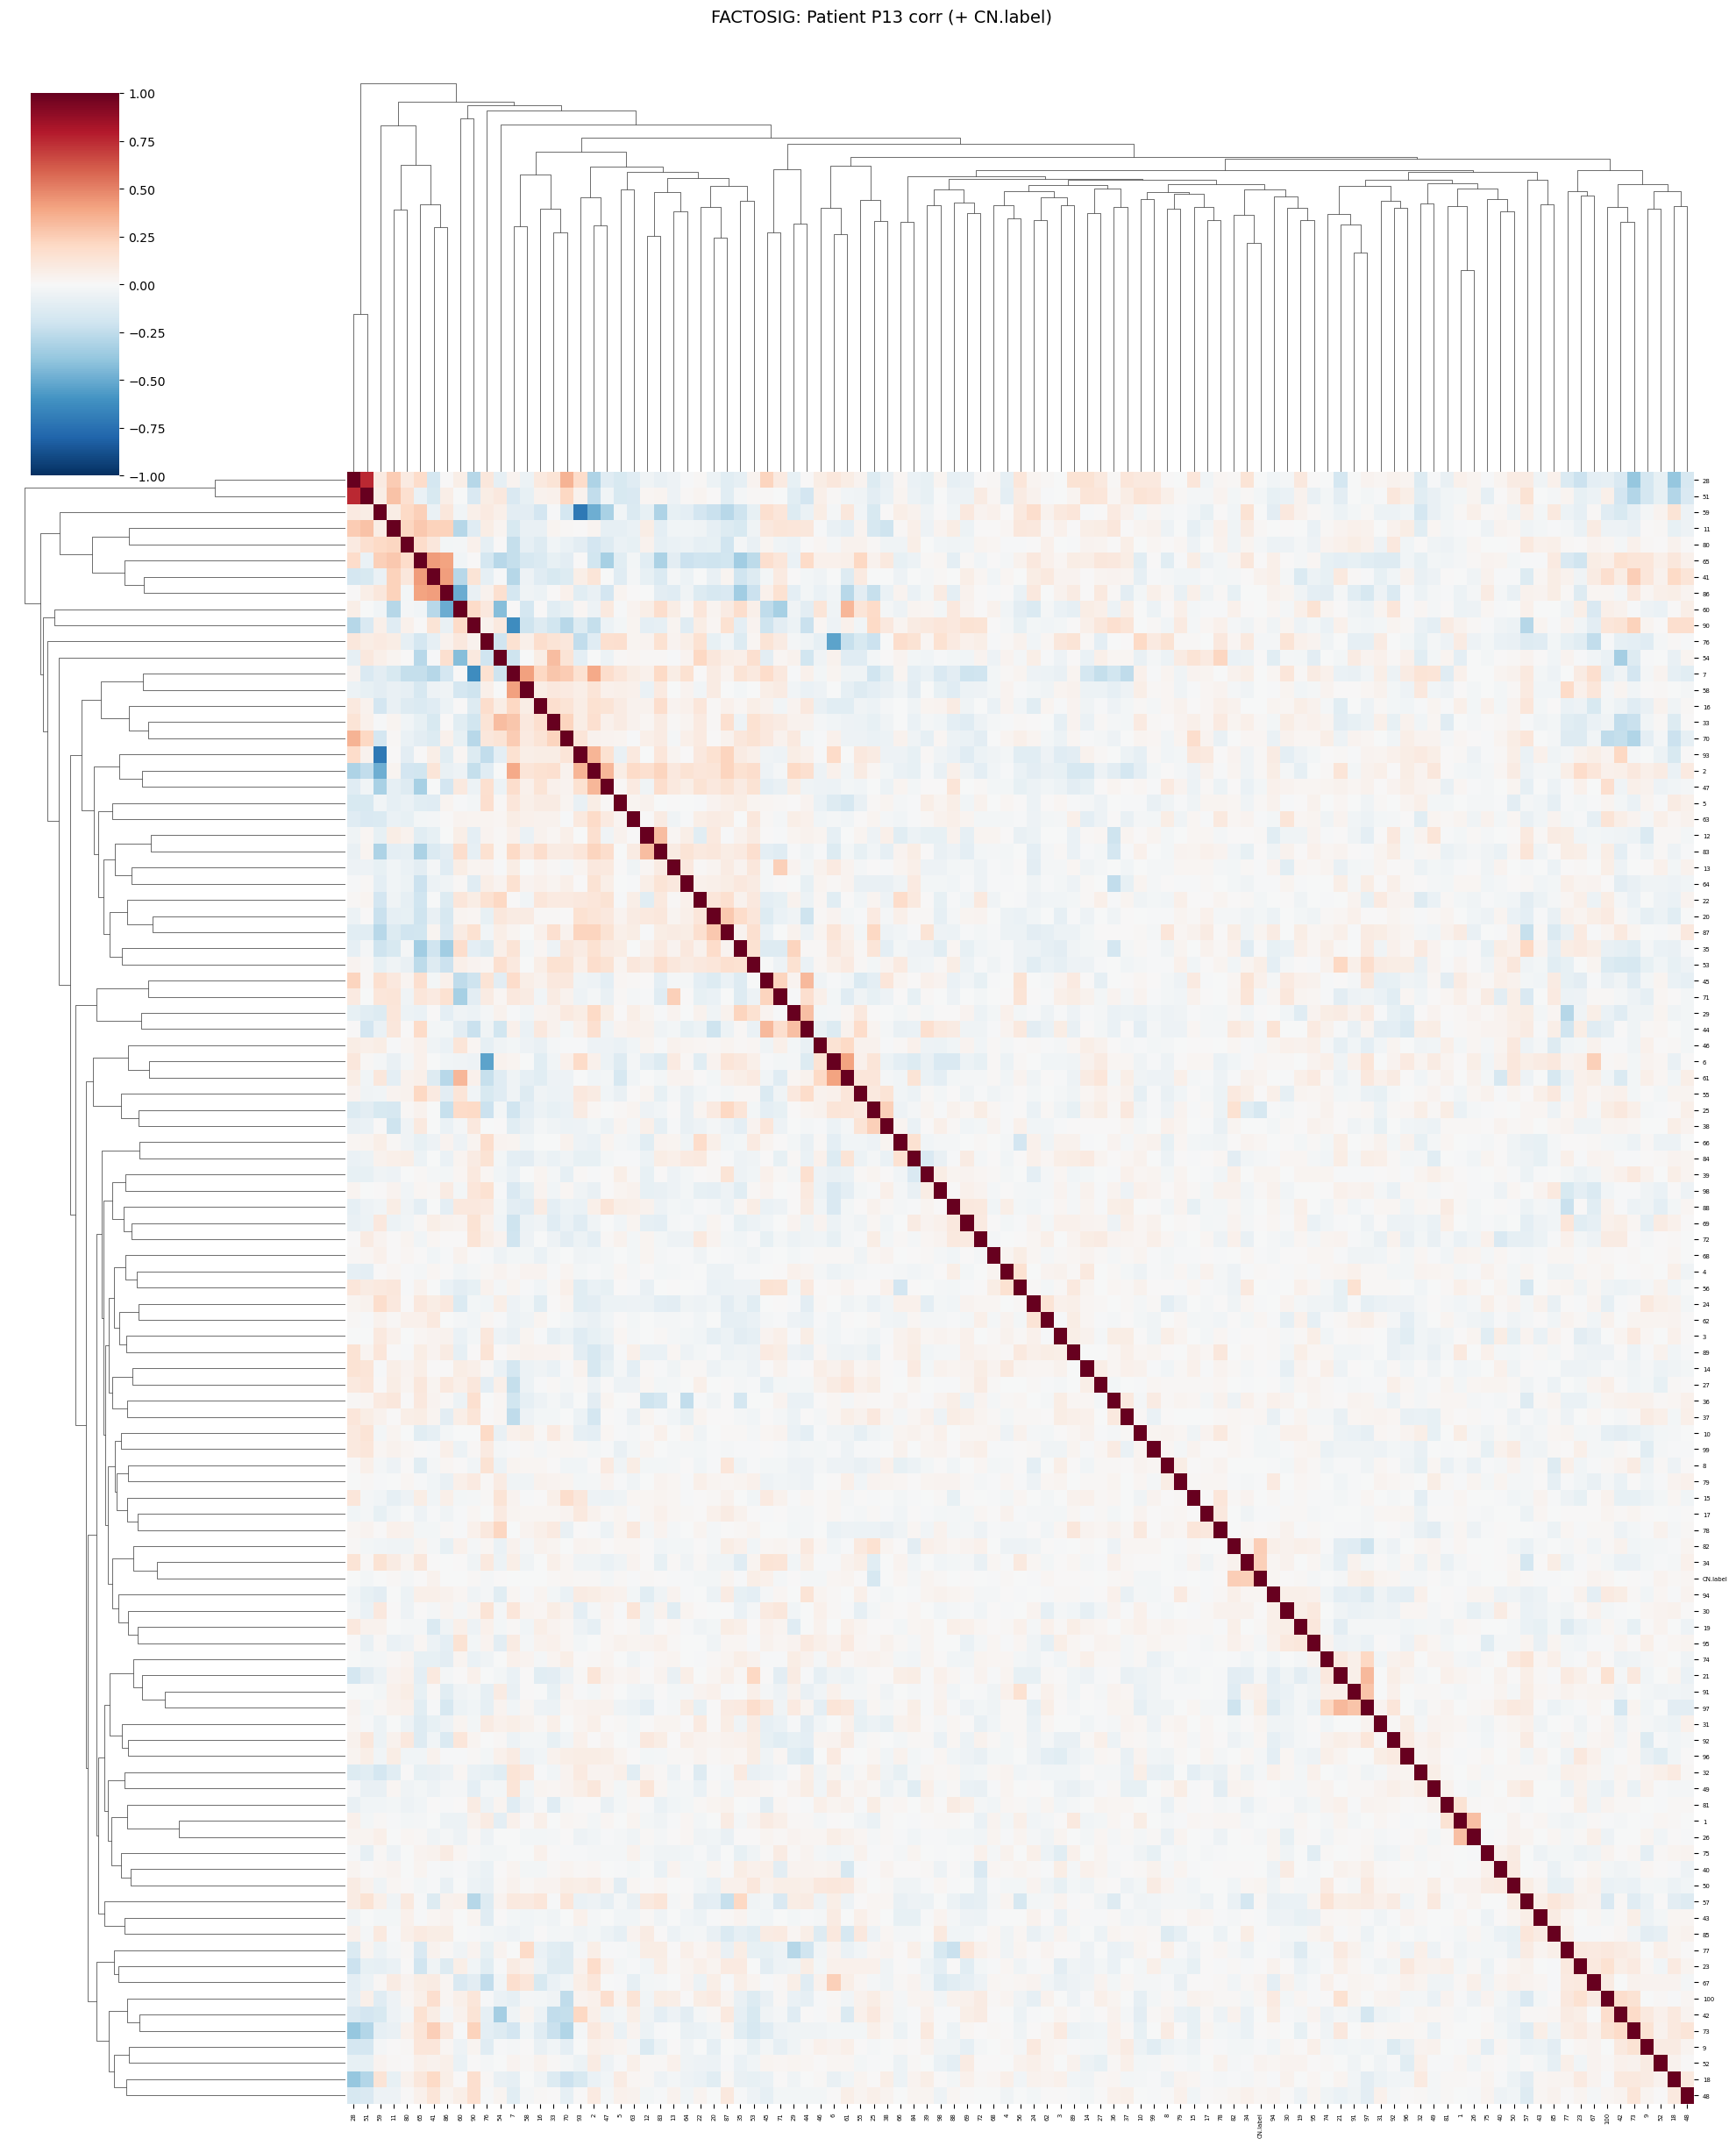

/home/minhang/miniconda3/envs/sc-factosig-gpu/lib/python3.10/site-packages/seaborn/matrix.py:560: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)
/home/minhang/miniconda3/envs/sc-factosig-gpu/lib/python3.10/site-packages/seaborn/matrix.py:560: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)


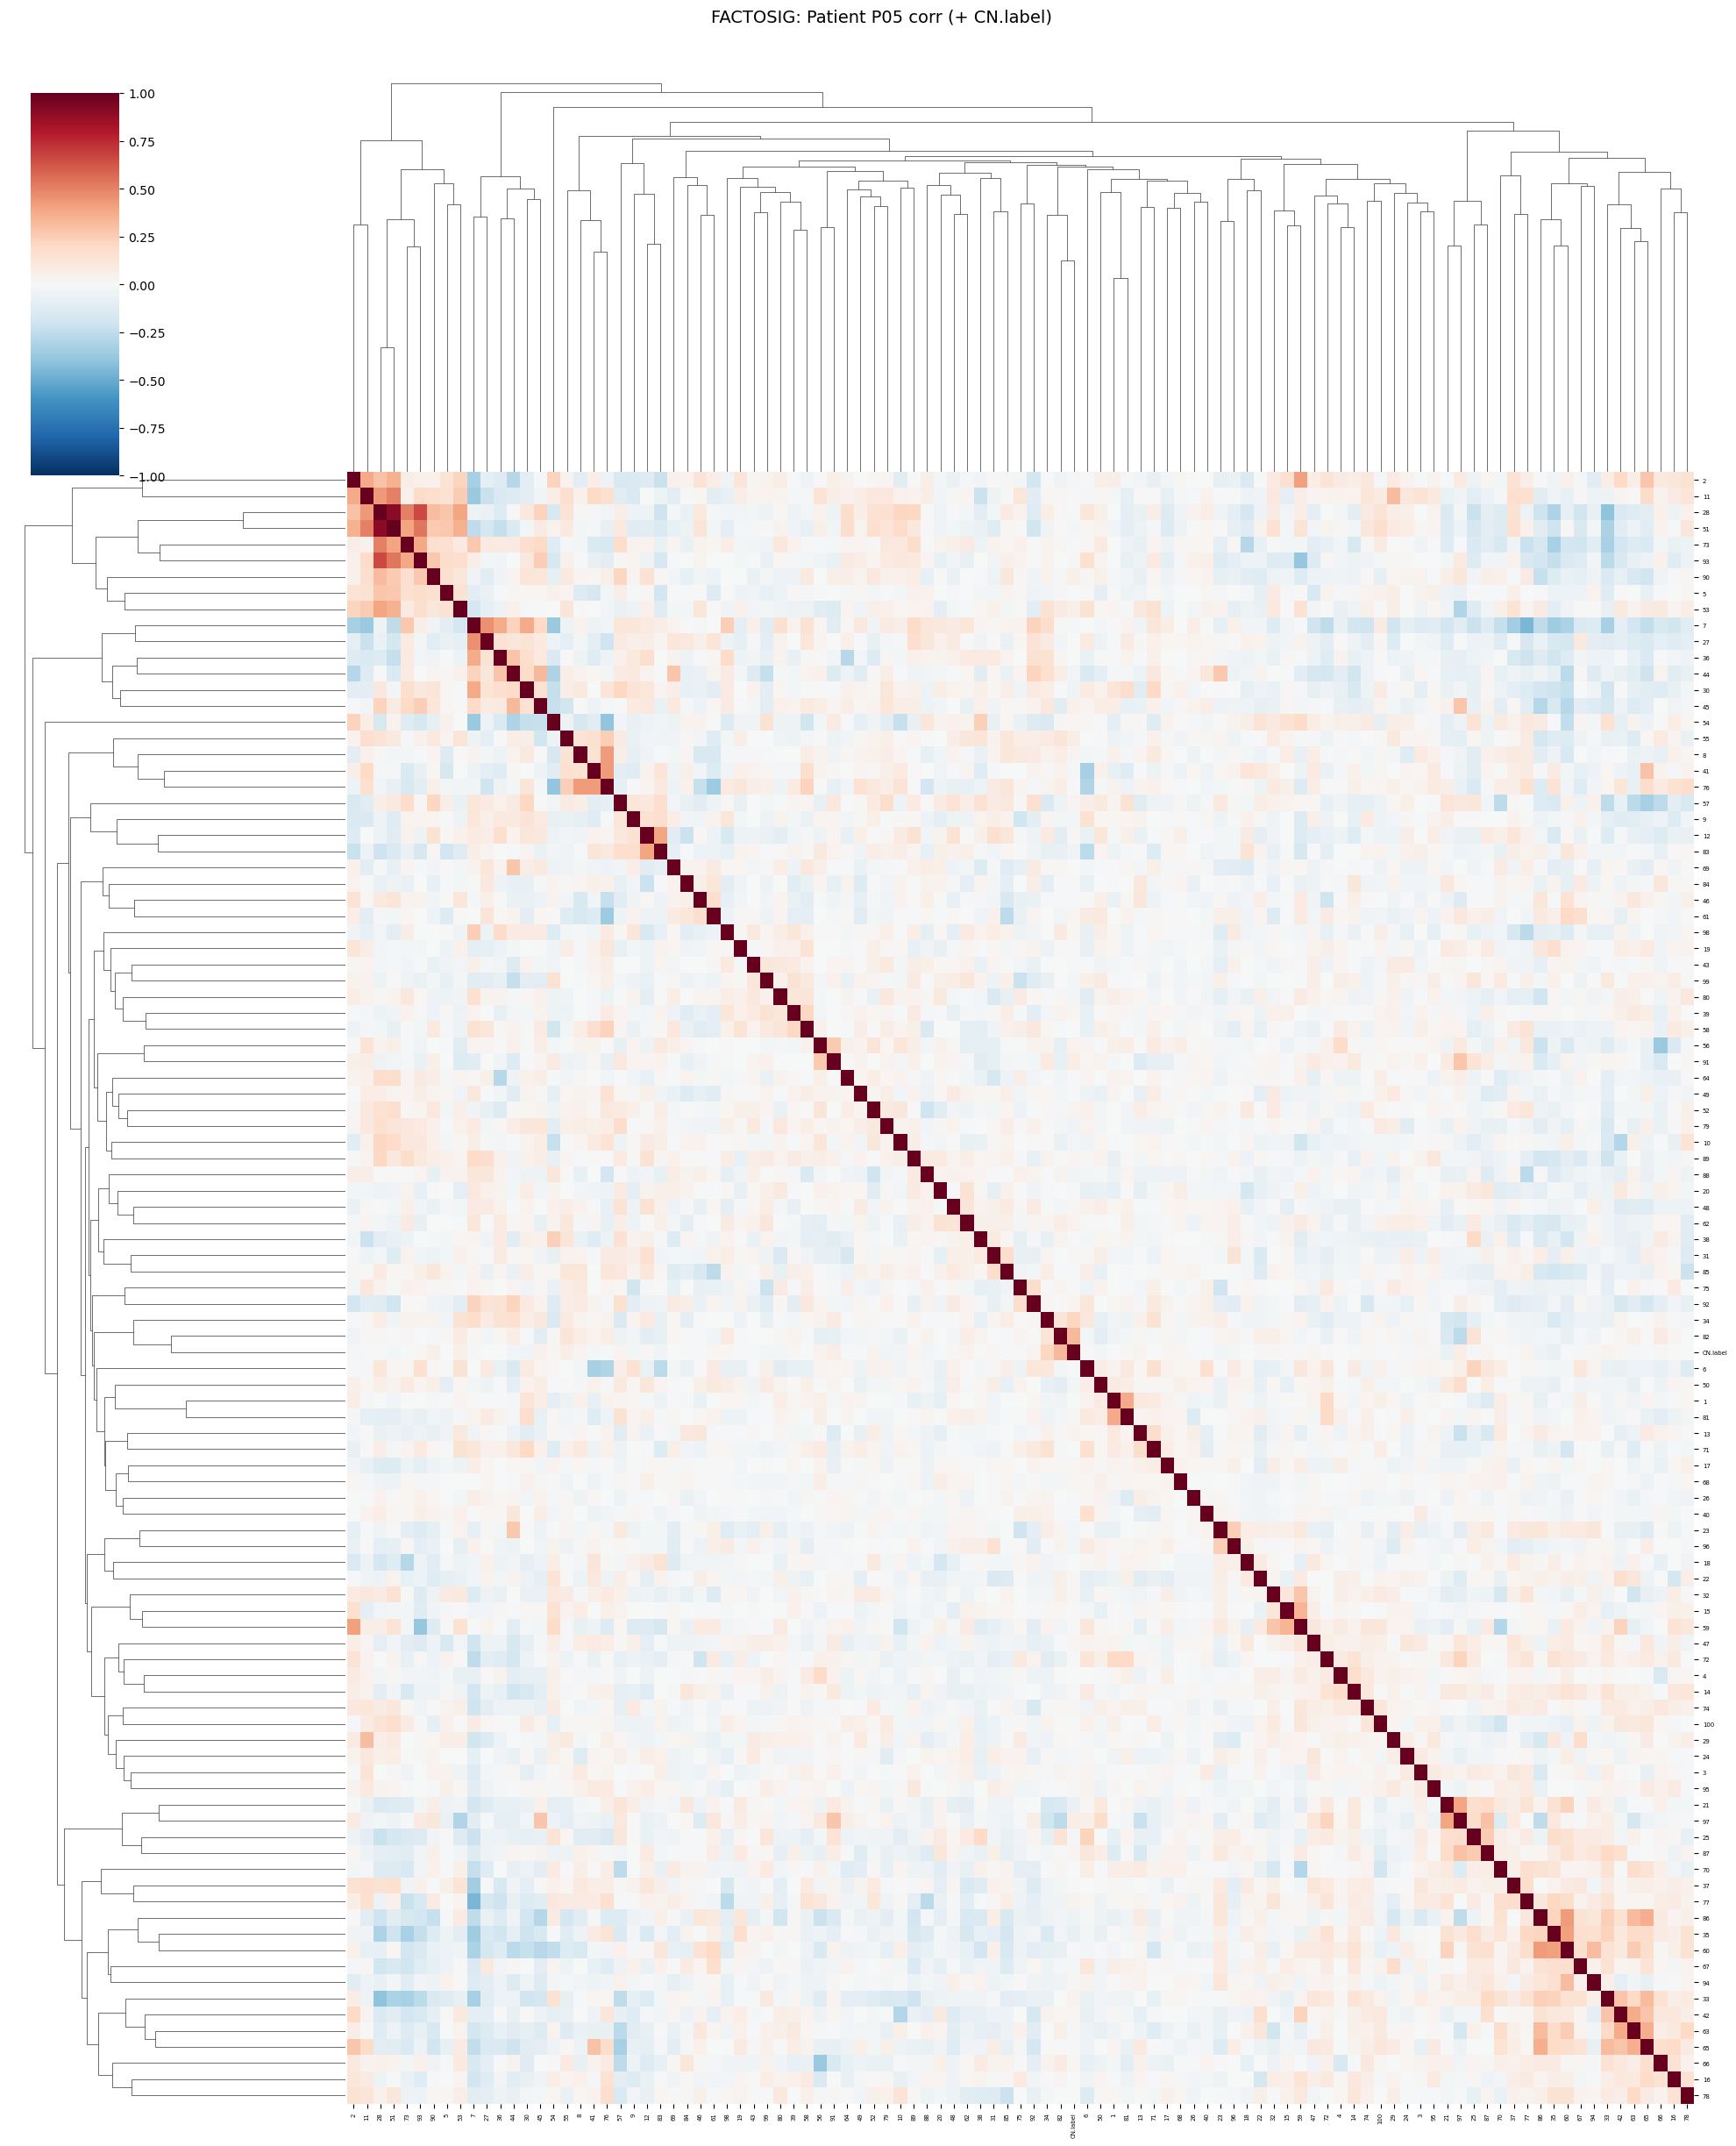

/home/minhang/miniconda3/envs/sc-factosig-gpu/lib/python3.10/site-packages/seaborn/matrix.py:560: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)
/home/minhang/miniconda3/envs/sc-factosig-gpu/lib/python3.10/site-packages/seaborn/matrix.py:560: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)


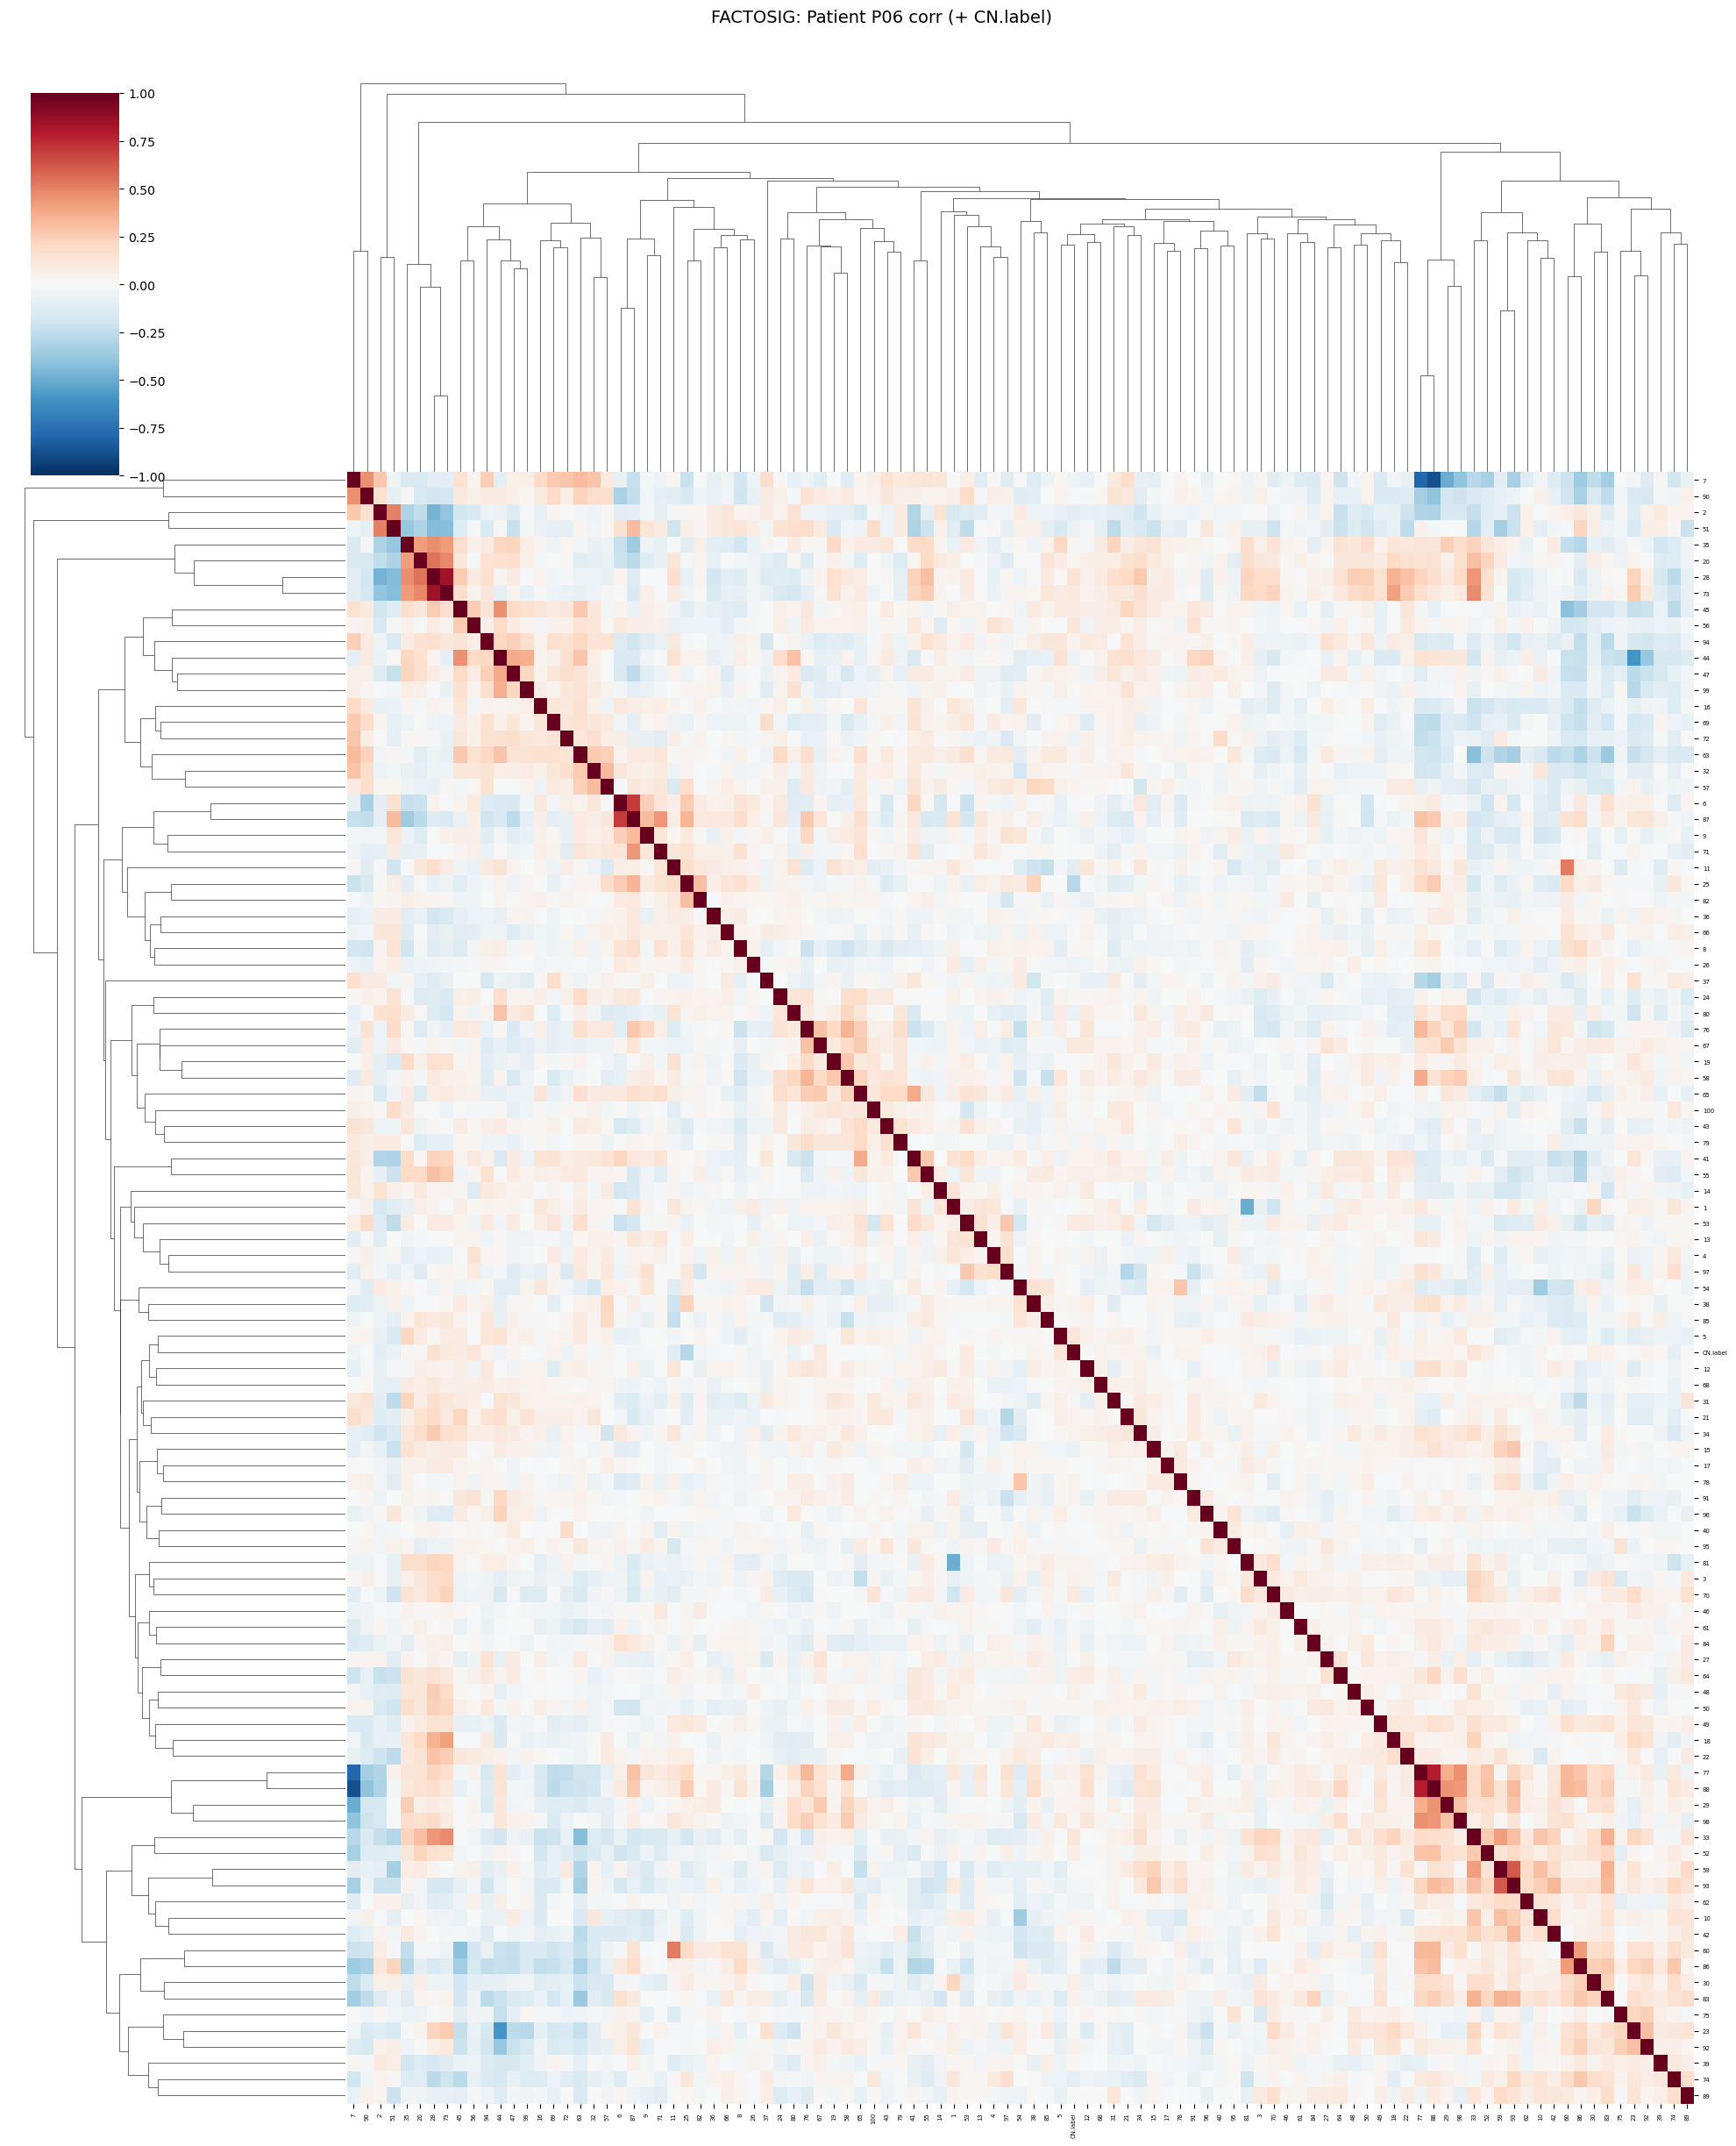

/home/minhang/miniconda3/envs/sc-factosig-gpu/lib/python3.10/site-packages/seaborn/matrix.py:560: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)
/home/minhang/miniconda3/envs/sc-factosig-gpu/lib/python3.10/site-packages/seaborn/matrix.py:560: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)


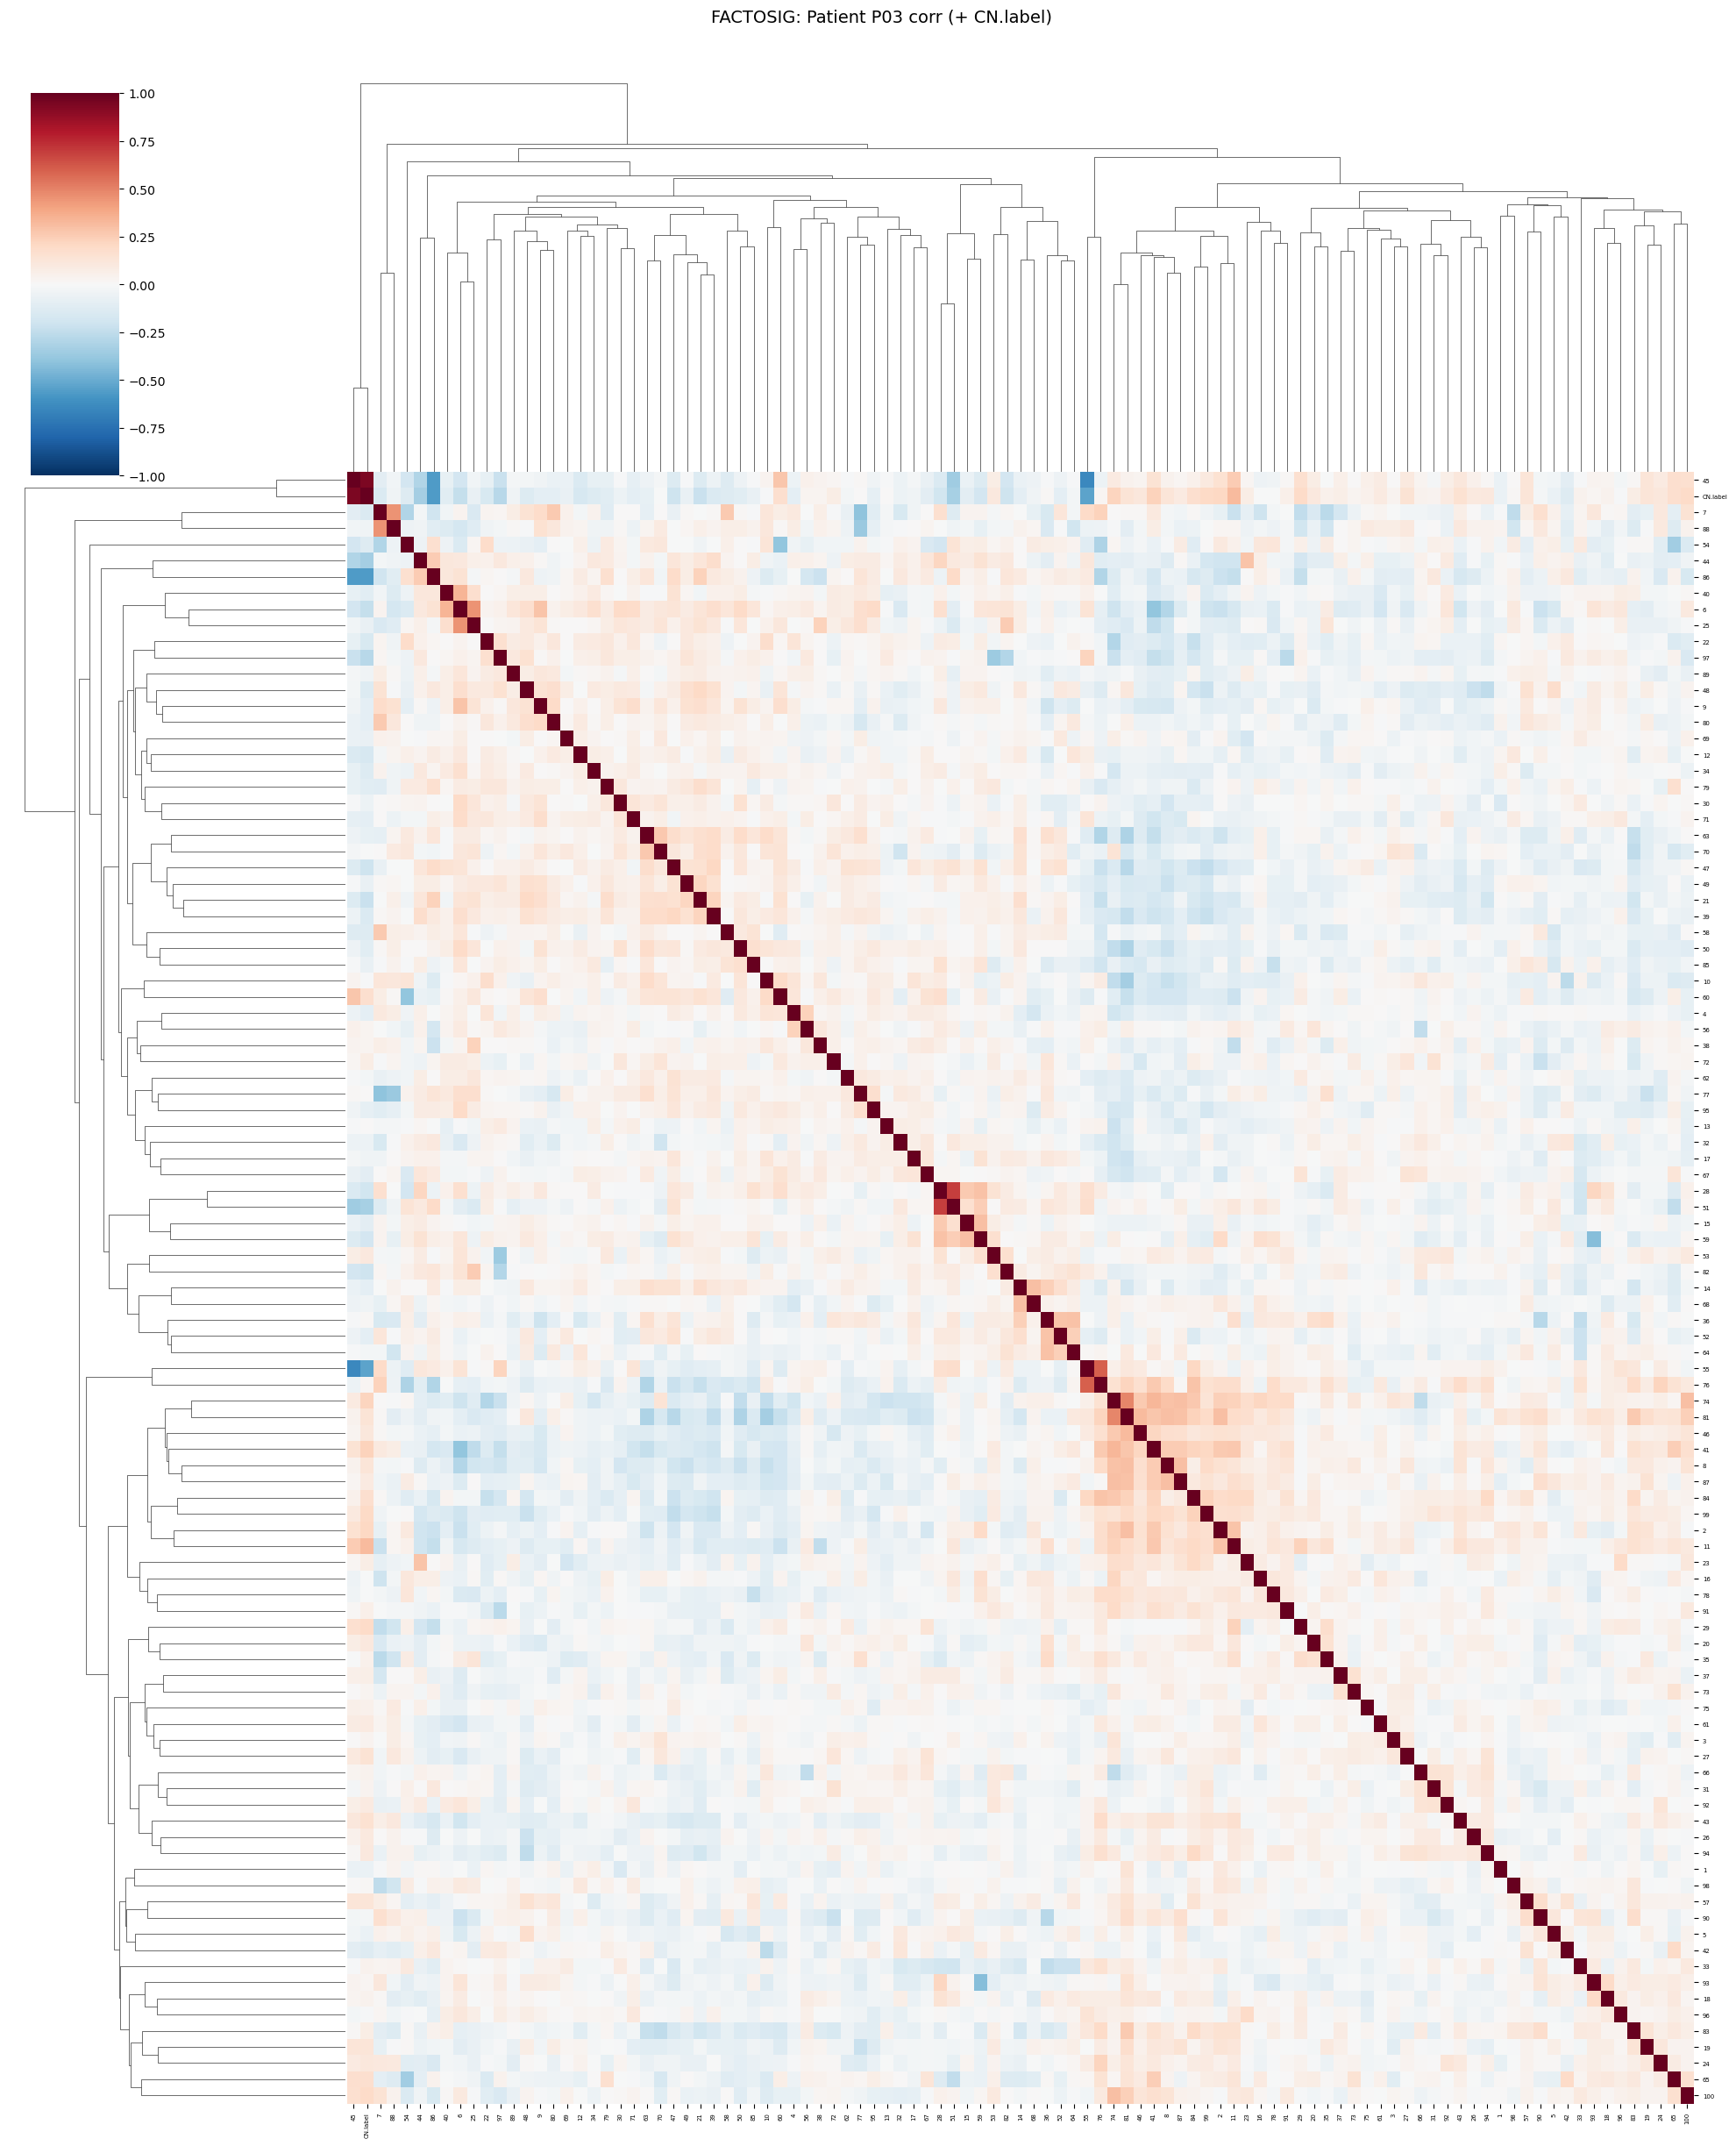

In [17]:
# Clustered correlation matrices (larger, smaller axis text)
from scipy.spatial.distance import pdist
from scipy.cluster.hierarchy import linkage
# Global corr with label appended as last column (label=1 for cancer)
def global_corr_matrix(method: str) -> pd.DataFrame:
    Z = AD.obsm[method_keys[method][0]]
    y = label.astype(float)
    Z_plus_y = np.column_stack([Z, y])
    cols = [*(map(str, range(1, Z.shape[1]+1))), 'CN.label']
    M = pd.DataFrame(Z_plus_y, columns=cols).corr()
    return M

def plot_corr_clustermap(M: pd.DataFrame, title: str = "",
                         size_scale=(0.18, 0.22), ticksize=6,
                         vmin=-1, vmax=1, center=0, cmap='RdBu_r'):
    n_rows, n_cols = M.shape
    w = max(12, n_cols * size_scale[0])
    h = max(10, n_rows * size_scale[1])
    cg = sns.clustermap(
        M,
        cmap=cmap,
        center=center,
        vmin=vmin, vmax=vmax,
        method='average', metric='euclidean',
        figsize=(w, h),
        xticklabels=True, yticklabels=True,
    )
    cg.fig.suptitle(title, fontsize=14, y=1.02)
    plt.setp(cg.ax_heatmap.get_xticklabels(), fontsize=ticksize, rotation=90)
    plt.setp(cg.ax_heatmap.get_yticklabels(), fontsize=ticksize)
    plt.show()

# Global clustered corr matrices
for m in METHODS:
    if method_keys[m][0] not in AD.obsm:
        continue
    M = global_corr_matrix(m)
    plot_corr_clustermap(M, title=f"{m.upper()}: corr matrix (+ CN.label)", size_scale=(0.20, 0.24), ticksize=5)

# Per-patient clustered corr matrices (subset up to 6 patients)
for m in METHODS:
    if method_keys[m][0] not in AD.obsm or 'patient' not in AD.obs.columns:
        continue
    Z = AD.obsm[method_keys[m][0]]
    p = AD.obs['patient'].astype(str)
    y = label.astype(float)
    # choose patients with most cells
    counts = p.value_counts().head(6)
    sel_patients = counts.index.astype(str).tolist()
    for pid in sel_patients:
        idx = np.flatnonzero(p == pid)
        if idx.size < 10:
            continue
        Zp = Z[idx, :]
        yp = y[idx]
        Z_plus_y = np.column_stack([Zp, yp])
        cols = [*(map(str, range(1, Zp.shape[1]+1))), 'CN.label']
        M = pd.DataFrame(Z_plus_y, columns=cols).corr()
        plot_corr_clustermap(M, title=f"{m.upper()}: Patient {pid} corr (+ CN.label)", size_scale=(0.20, 0.24), ticksize=5)


## Suggested additional diagnostics

- Factor sparsity: Compute proportion of near-zero loadings per factor (e.g., |loading| < 1e-3) and compare across methods.
- Gene-set coverage overlap: For each method, compute Jaccard overlap of significant pathways across factors; compare to others.
- Factor-patient association: If you attach scores back to AnnData, compare factor distributions across patients or CN.label groups.
- Stability across seeds: Run a second experiment with a different seed and compute factor alignment distributions (implemented above) across runs.
- Cross-method projection: Use saved models to project a held-out MRD subset and compare factor score consistency.


### Interpreting totals and reconstruction error
- total_ss: For PCA/FA/FactoSig we report sum of squared loadings per factor and then sum across factors. Its scale depends on preprocessing:
  - PCA on standardized genes yields components with unit-variance PCs; the SS across components sums to ~number of components (here ~100). That’s why PCA’s total_ss ~ 100.
  - FA/FactoSig loadings aren’t orthonormal like PCA; their magnitudes include unique variance structure, so total_ss is larger.
  - NMF uses nonnegative factors/components; the squared-components sum can be very large because it reflects the scale of the original nonnegative matrix and has no orthonormal constraint.
- Units: Squared loadings are in squared standardized units for methods run after z-scoring (PCA/FA/FactoSig). For NMF (nonnegative counts/log-normalized), units reflect the squared weight in that original scale.
- NMF reconstruction_error: This is the Frobenius norm ‖X − W H‖_F on the (possibly normalized/log1p) nonnegative matrix. It measures how well NMF reconstructs the input; lower is better, but it’s not directly comparable in magnitude to PCA/FA/FactoSig metrics because of different data scales and objectives.


In [1]:
import json
from pathlib import Path

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

EXP_DIR = Path("/home/minhang/mds_project/sc_classification/scripts/experiments/20251115_054547_factosig_only_100_none__ec10d437")
K = 100
METHODS = ["factosig"]

def load_method(exp_dir: Path, method: str, k: int):
    mdir = exp_dir / "models" / f"{method}_{k}"
    data = {"scores": None, "loadings": None, "extras": {}, "metrics": {}}

    scores_path = mdir / "scores.npy"
    loadings_path = mdir / "loadings.npy"
    if scores_path.exists():
        data["scores"] = np.load(scores_path)
    if loadings_path.exists():
        data["loadings"] = np.load(loadings_path)

    obs_names_path = mdir / "obs_names.txt"
    var_names_path = mdir / "var_names.txt"
    if obs_names_path.exists():
        with open(obs_names_path, "r") as f:
            data["obs_names"] = [ln.strip() for ln in f]
    if var_names_path.exists():
        with open(var_names_path, "r") as f:
            data["var_names"] = [ln.strip() for ln in f]

    for fname, key in [
        ("psi.npy", "psi"),
        ("explained_variance.npy", "explained_variance"),
        ("explained_variance_ratio.npy", "explained_variance_ratio"),
        ("singular_values.npy", "singular_values"),
    ]:
        p = mdir / fname
        if p.exists():
            data["extras"][key] = np.load(p)

    rec_json = mdir / "reconstruction_error.json"
    if rec_json.exists():
        try:
            data["extras"]["reconstruction_error"] = json.loads(rec_json.read_text()).get("reconstruction_error")
        except Exception:
            pass

    met_json = mdir / "dr_metrics.json"
    if met_json.exists():
        try:
            data["metrics"] = json.loads(met_json.read_text())
        except Exception:
            pass

    return data

DR = {m: load_method(EXP_DIR, m, K) for m in METHODS}
for m, d in DR.items():
    print(m, d["scores"].shape, d["loadings"].shape)

factosig (49480, 100) (15679, 100)


In [2]:
import scanpy as sc
from sc_classification.utils.experiment_manager import ExperimentManager
import yaml

# Load input h5ad path from config.yaml
with open(EXP_DIR / "config.yaml", "r") as f:
    cfg = yaml.safe_load(f)
input_h5ad = cfg.get("preprocessing", {}).get("used_input_h5ad")
print("Input h5ad:", input_h5ad)

adata0 = sc.read_h5ad(input_h5ad)

# Recreate the same cohort filtering as in run_factosig_only.py
if "timepoint_type" in adata0.obs.columns:
    adata0 = adata0[adata0.obs["timepoint_type"] == "MRD"].copy()
else:
    for c in ["sample", "Sample", "SAMPLE"]:
        if c in adata0.obs.columns:
            mask = adata0.obs[c].astype(str).str.contains("MRD", case=False, na=False)
            adata0 = adata0[mask].copy()
            break

label_col = next(c for c in ["CN.label", "cnLabel", "cn_label", "cnlabel"] if c in adata0.obs.columns)
adata0 = adata0[adata0.obs[label_col].isin(["cancer", "normal"])].copy()
if "patient" in adata0.obs.columns:
    has_mal = adata0.obs[adata0.obs[label_col] == "cancer"]["patient"].unique()
    adata0 = adata0[adata0.obs["patient"].isin(has_mal)].copy()
print("Cohort after filtering:", adata0.shape)

# Attach FactoSig DR arrays using ExperimentManager
em = ExperimentManager(str(EXP_DIR.parent))
exp_id = EXP_DIR.name
exp = em.load_experiment(exp_id)

method_keys = {
    "factosig": ("X_factosig", "FACTOSIG_loadings", "FACTOSIG_psi"),
}

adata = adata0.copy()
for m, (obsm_key, varm_key, var_psi_key) in method_keys.items():
    try:
        adata = exp.attach_dr_to_adata(
            adata,
            dr_method=m,
            n_components=K,
            obsm_key=obsm_key,
            varm_key=varm_key,
            var_psi_key=var_psi_key,
            strict_name_match=False,
        )
        print(f"Attached {m} to adata: {obsm_key}, {varm_key}")
    except Exception as e:
        print(f"Attach failed for {m}: {e}")

AD = adata  # keep handle

Input h5ad: /home/minhang/mds_project/data/cohort_adata/adata_mrd_standardized_oct7.h5ad
Cohort after filtering: (49480, 15679)
Loading experiment from: /home/minhang/mds_project/sc_classification/scripts/experiments/20251115_054547_factosig_only_100_none__ec10d437
Attached factosig to adata: X_factosig, FACTOSIG_loadings


Attributes available: ['CN.label', 'patient', 'predicted.annotation']


/home/minhang/miniconda3/envs/sc-factosig-gpu/lib/python3.10/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


Computed UMAP for FactoSig: (49480, 2)


/tmp/ipykernel_3429898/2369959595.py:28: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(col) or col.dtype == object:


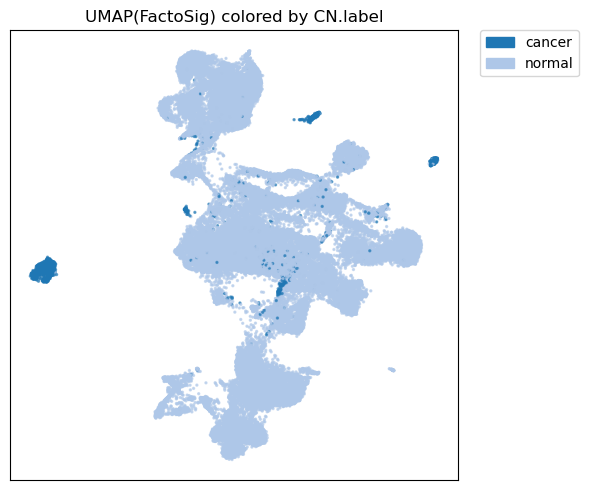

/tmp/ipykernel_3429898/2369959595.py:28: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(col) or col.dtype == object:


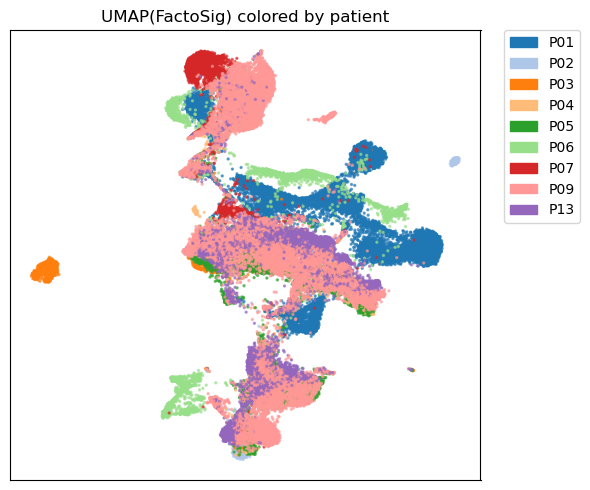

/tmp/ipykernel_3429898/2369959595.py:28: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(col) or col.dtype == object:


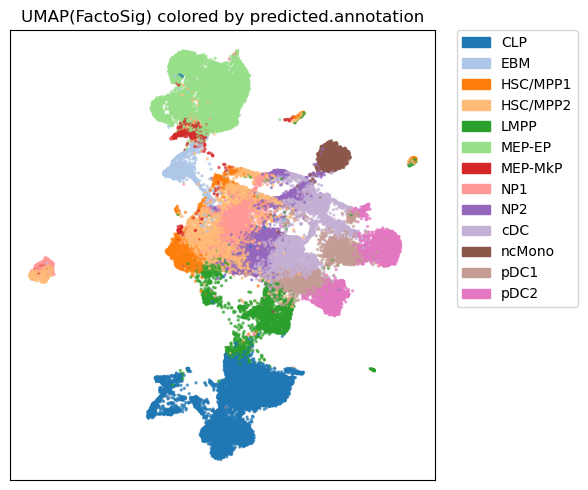

In [3]:
# UMAP based on FactoSig scores; color by CN.label, patient, etc.
import matplotlib.patches as mpatches

attrs = [c for c in ["CN.label", "patient", "predicted.annotation"] if c in AD.obs.columns]
print("Attributes available:", attrs)

try:
    import umap
except Exception:
    umap = None

if umap is None:
    print("umap-learn not installed; pip install umap-learn")
else:
    obsm_key, _, _ = method_keys["factosig"]
    if obsm_key not in AD.obsm:
        raise RuntimeError(f"Missing {obsm_key} in AD.obsm")

    Z = AD.obsm[obsm_key]
    reducer = umap.UMAP(n_neighbors=30, min_dist=0.3, random_state=42)
    emb = reducer.fit_transform(Z)
    AD.obsm["X_umap_factosig"] = emb
    print("Computed UMAP for FactoSig:", emb.shape)

    for a in attrs:
        plt.figure(figsize=(6, 5))
        col = AD.obs[a]
        if pd.api.types.is_categorical_dtype(col) or col.dtype == object:
            cats = col.astype(str)
            uniq = pd.Index(sorted(cats.unique()))
            cmap = dict(zip(uniq, sns.color_palette("tab20", n_colors=min(len(uniq), 20))))
            colors = cats.map(cmap).apply(
                lambda c: tuple(c) if isinstance(c, tuple) else (0.5, 0.5, 0.5)
            )
            colors = np.vstack(colors.values)
            plt.scatter(emb[:, 0], emb[:, 1], c=colors, s=2, alpha=0.6)

            legend_handles = [mpatches.Patch(color=c, label=l) for l, c in cmap.items()]
            plt.legend(
                handles=legend_handles,
                bbox_to_anchor=(1.05, 1),
                loc="upper left",
                borderaxespad=0.0,
            )

            plt.title(f"UMAP(FactoSig) colored by {a}")
        else:
            sca = plt.scatter(
                emb[:, 0], emb[:, 1], c=col.values, s=2, alpha=0.6, cmap="viridis"
            )
            plt.colorbar(sca)
            plt.title(f"UMAP(FactoSig) colored by {a}")
        plt.xticks([]); plt.yticks([])
        plt.tight_layout(); plt.show()

In [4]:
# Parameters for GSEA
from typing import Optional

GSEA_THREADS = 8
GSEA_PERM = 1000
GSEA_MIN_SIZE = 15
GSEA_MAX_SIZE = 500

# Path to Hallmark .gmt (adjust if your path is different)
HALLMARK_GMT = Path("/home/minhang/mds_project/resources/msigdb/h.all.v7.5.1.symbols.gmt")

FACTOR_INTP_DIR = EXP_DIR / "analysis" / "factor_interpretation"
FACTOR_INTP_DIR.mkdir(parents=True, exist_ok=True)

try:
    import gseapy as gp
except Exception as e:
    print("Install gseapy to run GSEA: pip install gseapy")
    gp = None


def run_or_read_prerank(series: pd.Series, gene_sets: str | Path, out_dir: Path) -> Optional[pd.DataFrame]:
    out_dir.mkdir(parents=True, exist_ok=True)
    report_csv = out_dir / "gseapy.gene_set.prerank.report.csv"
    if report_csv.exists():
        try:
            df = pd.read_csv(report_csv, sep="\t")
        except Exception:
            df = pd.read_csv(report_csv)
        return df
    if gp is None:
        return None
    df_rnk = series.reset_index()
    df_rnk.columns = ["gene", "score"]
    res = gp.prerank(
        rnk=df_rnk,
        gene_sets=str(gene_sets),
        threads=GSEA_THREADS,
        permutation_num=GSEA_PERM,
        outdir=str(out_dir),
        seed=0,
        min_size=GSEA_MIN_SIZE,
        max_size=GSEA_MAX_SIZE,
        no_plot=True,
        format="png",
    )
    return res.res2d.copy()

In [5]:
# Run/collect GSEA for FactoSig factors
GSEA_COUNTS = {}

for m in METHODS:
    print(f"Running/reading GSEA for {m} ...")
    L = DR[m]["loadings"]
    genes = np.array(DR[m]["var_names"])
    out_root = FACTOR_INTP_DIR / f"{m}_gsea"
    out_root.mkdir(parents=True, exist_ok=True)
    n_factors = L.shape[1]
    counts = []
    for j in range(n_factors):
        rank = pd.Series(L[:, j], index=genes).sort_values(ascending=False)
        out_dir = out_root / f"{m}{j+1}"
        df = run_or_read_prerank(rank, HALLMARK_GMT, out_dir)
        if df is None:
            continue
        qcols = [c for c in ["FDR q-val", "fdr", "fdr_q-val", "fdr_q_value"] if c in df.columns]
        if qcols:
            qcol = qcols[0]
            n_sig = int((df[qcol] < 0.05).sum())
        else:
            n_sig = np.nan
        counts.append({"factor": j, "n_sig": n_sig})
    GSEA_COUNTS[m] = pd.DataFrame(counts)

# Plot # significant Hallmark pathways per factor (FactoSig only)
fig, ax = plt.subplots(figsize=(8, 4))
dfc = GSEA_COUNTS.get("factosig", pd.DataFrame())
if dfc.empty:
    ax.text(0.5, 0.5, "No GSEA results for factosig", ha="center")
    ax.set_title("factosig")
else:
    ax.bar(dfc["factor"].values + 1, dfc["n_sig"].values)
    ax.set_title("FactoSig: # Hallmark pathways (FDR < 0.05) per factor")
    ax.set_xlabel("Factor (ordered)")
    ax.set_ylabel("# significant pathways")
plt.tight_layout(); plt.show()

2025-11-17 02:16:12,324 [WARNING] Duplicated values found in preranked stats: 0.01% of genes
The order of those genes will be arbitrary, which may produce unexpected results.


Running/reading GSEA for factosig ...


FileNotFoundError: [Errno 2] No such file or directory: '/home/minhang/mds_project/resources/msigdb/h.all.v7.5.1.symbols.gmt'

In [ ]:
# Optional: use ExperimentAnalyzer to create GSEA summary barplots per factor
from sc_classification.utils.experiment_analysis import ExperimentAnalyzer

experiments_base_dir = EXP_DIR.parent
analyzer = ExperimentAnalyzer(str(experiments_base_dir))

for m in METHODS:
    print(f"Creating GSEA summary plots for {m} ...")
    out_root = FACTOR_INTP_DIR / f"{m}_gsea"
    n_factors = DR[m]["loadings"].shape[1]
    for j in range(n_factors):
        factor_name = f"{m.upper()} Factor {j+1}"
        gsea_dir = out_root / f"{m}{j+1}"
        csv_path = gsea_dir / "gseapy.gene_set.prerank.report.csv"
        plot_path = gsea_dir / f"GSEA_summary_barplot_{m}{j+1}.png"
        if not csv_path.exists():
            continue
        analyzer._plot_gsea_results(
            csv_path=str(csv_path),
            factor_name=factor_name,
            gene_set=str(HALLMARK_GMT),
            output_path=str(plot_path),
        )
print("Done.")

In [ ]:
from sklearn.metrics import roc_auc_score

def signed_auc(y_true: np.ndarray, z: np.ndarray) -> float:
    # AUC in [0,1]; sign by median difference cancer - normal
    auc = roc_auc_score(y_true, z)
    sgn = np.sign(np.median(z[y_true == 1]) - np.median(z[y_true == 0]))
    auc_signed = sgn * (auc if auc >= 0.5 else (1 - auc))
    return float(auc_signed)

label_col = next(c for c in ["CN.label", "cnLabel", "cn_label", "cnlabel"] if c in AD.obs.columns)
label = AD.obs[label_col].astype(str).map({"normal": 0, "cancer": 1}).to_numpy()
patients = AD.obs["patient"].astype(str) if "patient" in AD.obs.columns else pd.Series(["ALL"] * AD.n_obs)

sep_all = {}
for m in METHODS:
    obsm_key, _, _ = method_keys[m]
    if obsm_key not in AD.obsm:
        continue
    Z = AD.obsm[obsm_key]
    sep_all[m] = [signed_auc(label, Z[:, j]) for j in range(Z.shape[1])]

sep_all_df = pd.DataFrame(sep_all)
display(sep_all_df.describe())

plt.figure(figsize=(8, 4))
plt.plot(np.arange(1, K+1), sep_all_df["factosig"].values, marker="o", ms=3)
plt.axhline(0, color="k", linewidth=0.5)
plt.xlabel("FactoSig factor (ordered by SS)")
plt.ylabel("Signed AUC (cancer vs normal)")
plt.title("Per-factor separation by CN.label (FactoSig)")
plt.tight_layout(); plt.show()

In [ ]:
# Per-patient separation score heatmap for FactoSig
def patient_separation_scores(method: str) -> pd.DataFrame:
    Z = AD.obsm[method_keys[method][0]]
    p = AD.obs["patient"].astype(str)
    y = label
    rows = {}
    for pid in sorted(p.unique()):
        idx = np.flatnonzero(p == pid)
        if idx.size < 10:
            continue
        y_p = y[idx]
        Zp = Z[idx, :]
        rows[pid] = [signed_auc(y_p, Zp[:, j]) for j in range(Zp.shape[1])]
    return pd.DataFrame.from_dict(rows, orient="index", columns=[f"f{j+1}" for j in range(Z.shape[1])])

method_for_heatmap = "factosig"
pat_df = patient_separation_scores(method_for_heatmap)
plt.figure(figsize=(12, max(6, pat_df.shape[0] * 0.25)))
sns.heatmap(pat_df, cmap="RdBu_r", center=0, vmin=-1, vmax=1)
plt.title(f"{method_for_heatmap} single-factor signed AUC per patient")
plt.xlabel("Factors (ordered by SS)")
plt.ylabel("Patient")
plt.tight_layout(); plt.show()

In [ ]:
# Clustered heatmaps for per-patient signed AUC, highlighting strong factors
def plot_clustered_signed_auc(scores_df: pd.DataFrame,
                              abs_threshold: float = 0.5,
                              patients_to_exclude=None,
                              title: str = "",
                              figsize_scale=(0.35, 0.5),
                              center=0):
    import seaborn as sns
    if patients_to_exclude is None:
        patients_to_exclude = []
    filt_df = scores_df.loc[:, (scores_df.abs() > abs_threshold).any(axis=0)]
    if filt_df.empty:
        print("No factors pass the |score| threshold; plotting all factors instead.")
        filt_df = scores_df.copy()
    filt_df = filt_df.drop(index=patients_to_exclude, errors="ignore")
    heatmap_data = filt_df.fillna(0.0)

    w = max(12, heatmap_data.shape[1] * figsize_scale[0])
    h = max(6, heatmap_data.shape[0] * figsize_scale[1])
    cg = sns.clustermap(
        heatmap_data,
        method="average",
        metric="euclidean",
        cmap="RdBu_r",
        center=center,
        vmin=-1, vmax=1,
        figsize=(w, h),
        cbar_kws={"label": "Separation Score (signed AUC)"},
    )
    cg.fig.suptitle(title or f"Factors with any |score| > {abs_threshold}", fontsize=16, y=1.03)
    cg.ax_heatmap.set_title("")
    plt.setp(cg.ax_heatmap.get_xticklabels(), fontsize=7, rotation=90)
    plt.setp(cg.ax_heatmap.get_yticklabels(), fontsize=8)
    cg.ax_heatmap.set_xlabel("Factors")
    cg.ax_heatmap.set_ylabel("Patients")
    plt.show()

# Build clustered heatmap for FactoSig
if "patient" in AD.obs.columns and method_keys["factosig"][0] in AD.obsm:
    df_pat = patient_separation_scores("factosig")
    plot_clustered_signed_auc(
        df_pat,
        abs_threshold=0.5,
        patients_to_exclude=[],
        title="FACTOSIG: Distinguishing Power (|score| > 0.5)",
        figsize_scale=(0.35, 0.6),
        center=0,
    )

In [ ]:
# Clustered correlation matrix of FactoSig factors + CN.label
from scipy.spatial.distance import pdist
from scipy.cluster.hierarchy import linkage

def global_corr_matrix(method: str) -> pd.DataFrame:
    Z = AD.obsm[method_keys[method][0]]
    y = label.astype(float)
    Z_plus_y = np.column_stack([Z, y])
    cols = [*(map(str, range(1, Z.shape[1] + 1))), "CN.label"]
    M = pd.DataFrame(Z_plus_y, columns=cols).corr()
    return M

def plot_corr_clustermap(M: pd.DataFrame, title: str = "",
                         size_scale=(0.18, 0.22), ticksize=6,
                         vmin=-1, vmax=1, center=0, cmap="RdBu_r"):
    n_rows, n_cols = M.shape
    w = max(12, n_cols * size_scale[0])
    h = max(10, n_rows * size_scale[1])
    cg = sns.clustermap(
        M,
        cmap=cmap,
        center=center,
        vmin=vmin, vmax=vmax,
        method="average", metric="euclidean",
        figsize=(w, h),
        xticklabels=True, yticklabels=True,
    )
    cg.fig.suptitle(title, fontsize=14, y=1.02)
    plt.setp(cg.ax_heatmap.get_xticklabels(), fontsize=ticksize, rotation=90)
    plt.setp(cg.ax_heatmap.get_yticklabels(), fontsize=ticksize)
    plt.show()

M_fs = global_corr_matrix("factosig")
plot_corr_clustermap(M_fs, title="FACTOSIG: corr matrix (+ CN.label)", size_scale=(0.20, 0.24), ticksize=5)